# Learning a SDE for the contact process

In this tutoral we train a two neural nets $\mu_\theta$ and $\sigma_\theta$ to be approxiamtions for the SDE governing the contact prcoess in one dimension.

At each site $i$ of a lattice, $i =0, 1,...,N$ a spin $s^i$ is either active $s^i=1$ or inactive $s^i=0$. 
Depending on the number
of active nearest neighbors $n^i$
the spin $s^i_t$ at time $t$ transitions to 0 or 1 at time $t+dt$ with rates 
$w[s^i_t\to s^i_{t+dt},n_i]$ defined as:
$$
\begin{align}
    & w[0\rightarrow 1,n_i(t)]=\kappa n_i(t) / 2 d\\
    & w[1\rightarrow 0,n_i(t)]=1,
\end{align}
$$
One can thus define the density of acrive sites $\rho_t = 1/N \sum_i s^i_t$.

We will train a neural SDE:
$$
d \rho_t
=
\mu_\theta(\rho_t)dt
+
\sigma_\theta(\rho_t)dW_t
$$
with a Browninan motion with correlations:
$$
\langle W_t W_{t'}\rangle = \delta(t-t')
$$



In [87]:
#Generate the data-set 
import os
kappa = 3.356 # infection rate
Size_system = N = t_step= 100
Num_traj = 100
t_final = 2000
dt=0.01
os.makedirs("./dataset",exist_ok=True)
# To generate the data-set, an installation of julia is needed, hte dataset at kappa = 3.356 is included

# If you want to generate your own data set, here is the code, on 2015 mac pro took 4 min (but most simulation were run on cluster)

#os.system("julia c_time_cp_resume.jl --kappa %f --Num_traj %d --N %d --t_final %d "%(kappa,Num_traj,N,t_final) )


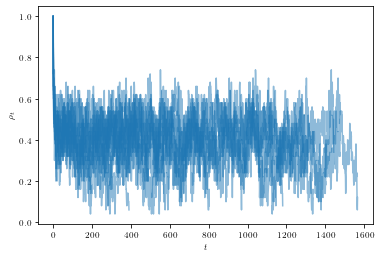

In [105]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
# Latex stile ricks and labels
plt.rcParams.update({
                "pgf.texsystem": "pdflatex",
                'font.family': 'serif',
                'text.usetex': True,
                'pgf.rcfonts': False,
                "font.size":9
             })

data_set = "./dataset/N_"+str(Size_system)+"_t_final"+str(t_final)+"_up0_ctime_cp_kappa_"+str(kappa)+"_gamma_1.0.h5"
f = h5py.File(data_set,"r")
[plt.plot(np.array(f["mag_"+str(n)])[0::N],c="tab:blue",alpha=0.5) for n in range(1,10)]
plt.xlabel(r"$t$")
plt.ylabel(r"$\rho_t$")
plt.show()

In [4]:
#create the model for the drift

import torch
from torch import nn
from torch.utils.data import Dataset
from torch import optim
import tqdm
class Mu(nn.Module):
    def __init__(self):
        super(Mu, self).__init__()
        self.mu_net =  nn.Sequential(
            nn.Linear(1, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, 1), 
        )   

    def forward(self,v):
           return self.mu_net(v) 


In [5]:
class AverageMu(nn.Module):
        """
        Module to compute a weighted average model for the Mu 
        in the hope of better results
        """
        def __init__(self,n_mu=10,weights=torch.ones(10)):
                super(AverageMu, self).__init__()
                if len(weights) != n_mu:
                        raise ValueError("weights must have length n_mu")
                self.funcs = nn.ModuleList([Mu() for _ in range(n_mu)])
                self.weights = weights
        def forward(self,x):
                y = torch.Tensor([0.])
                for w,f in zip(self.weights,self.funcs):
                        y = y + w*f(x) 
                return y/self.weights.sum() 

In [118]:
#The data are massaged here to become an approx to the inf genartor Wx
class dataset(Dataset):
    def __init__(self, file_name,thres=0.05,num_trajs=100,t_max = 100000,N=100):
        self.ds = h5py.File(file_name,'r')
        self.trajs = np.zeros(num_trajs*t_max).reshape( num_trajs,t_max  )
        #self.times = np.zeros(num_trajs*t_max).reshape( num_trajs,t_max  )
        for j in range(1,num_trajs+1):
                m = np.array(self.ds["mag_"+str(j)])[:t_max]
                t = np.array(self.ds["T_"+str(j)])[:t_max]
                #self.times[j-1,:][:len(m)]=t[:len(m)]
                self.trajs[j-1,:][:len(m)]=m[:len(m)]
        self.thres = thres
        self.max = np.max(self.trajs)#regulariztio ìn of the dataset
        self.min = np.min(self.trajs)+self.thres
        self.num_trajs = num_trajs
        self.t_max = t_max
    def __getitem__(self,idx):
        x=self.trajs[:self.num_trajs,:self.t_max]
        #t = self.times[:self.num_trajs,:self.t_max]
        x0=np.random.rand()*(self.max-self.min) + self.min
        idx = np.argwhere( np.abs(x[:,:-1]-x0)<self.thres  )
        x0s = x[idx[:,0],idx[:,1]]
        x_dt = x[:,1:][idx[:,0],idx[:,1]]
        #dt = t[:,1:][idx[:,0],idx[:,1]] - t[idx[:,0],idx[:,1]]
        mu_x = torch.mean( torch.from_numpy(x_dt-x0s))
        #mu_x = torch.mean( torch.from_numpy(x_dt))-x0
        _x0s_ = torch.from_numpy(x0.reshape(1,))
        return _x0s_.reshape(1,).float(), mu_x.reshape(1,).float()
    def __len__(self):
        return self.trajs.shape[0]


In [119]:
def train_avg_mu(avg_model,
             dataset,
             train_dir,
             batch_size=200,
             input_size=1,
             hidden_size=64,
             output_size=1,
             num_iters=5000,
             stop_every= 100,
             training_diff=False,
             dt=dt,
             ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)
    os.makedirs(os.path.dirname(train_dir),exist_ok=True)
    for idx in range(len(avg_model.funcs)):
            model_idx = avg_model.funcs[idx]
            optimizer = optim.RMSprop( model_idx.parameters()  , lr=0.3e-3)
            print("Training for model %d"%idx)
            x0, dx = next(iter(infinite_train_dataloader))
            for global_step in tqdm.tqdm(range(1, num_iters+1)):
                model_idx.zero_grad()
                loss = torch.abs(model_idx(x0)-dx/dt).mean()
                loss.backward()
                optimizer.step()
                if global_step%stop_every==0:
                    print(loss.item())
                    name = train_dir+"/mu_diff_trai_"+str(idx)+".pdf"
                    plot_results(model_idx,x0,dx,name,dt)
            avg_model.weights[idx] = (  (((model_idx(x0)*dt-dx)**2).mean()) **(-1)).detach()
            avg_model.funcs[idx] = model_idx
    return avg_model


In [120]:
def plot_results(model,x,y,name = "./images/mu_diff.pdf",dt = 0.01):
    plt.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
            "font.size":11
         })
    fig, ax = plt.subplots(1, 1)
    with torch.no_grad():

        x, indices = torch.sort(x.flatten())
        y = y.flatten()[indices]
        mu_x_model = model(x.reshape(len(x),1)).detach().numpy().flatten()
        ax.plot(x,y,label = "Data")
        ax.plot(x,mu_x_model*dt,label = "Network")
        ax.set_xlabel(r"$\rho$")
        ax.set_ylabel(r"$\mu(\rho)$")
        ax.legend(frameon=False)
        plt.savefig(name)
        plt.show()
        plt.close()

Training for model 0


  1%|▏         | 68/5000 [00:00<00:07, 677.76it/s]

0.06317616254091263


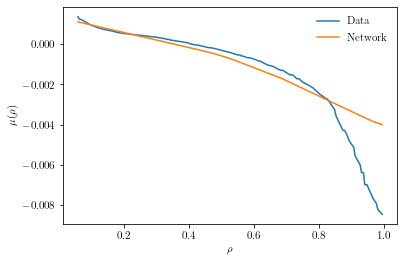

  3%|▎         | 173/5000 [00:00<00:17, 280.34it/s]

0.05668944492936134


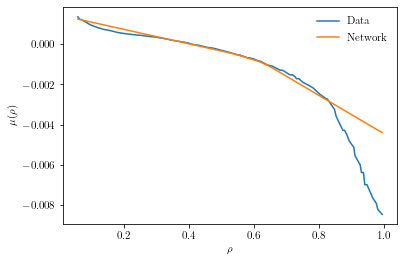

  5%|▌         | 261/5000 [00:01<00:20, 229.02it/s]

0.04745990410447121


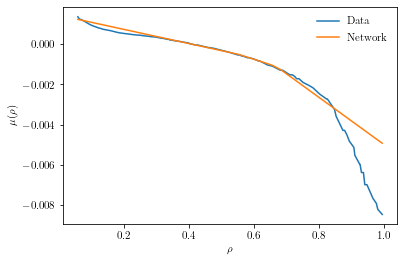

  7%|▋         | 371/5000 [00:01<00:20, 228.42it/s]

0.03826906904578209


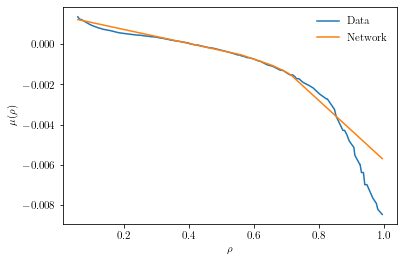

  9%|▉         | 472/5000 [00:02<00:23, 195.20it/s]

0.02981584519147873


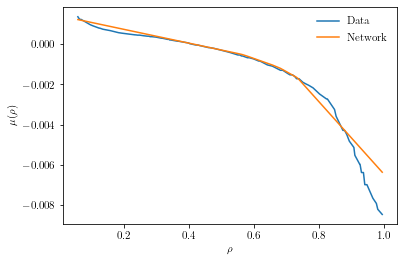

 12%|█▏        | 594/5000 [00:02<00:18, 235.28it/s]

0.022488482296466827


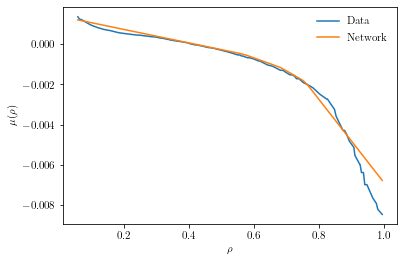

 13%|█▎        | 659/5000 [00:03<00:31, 138.61it/s]

0.02008572779595852


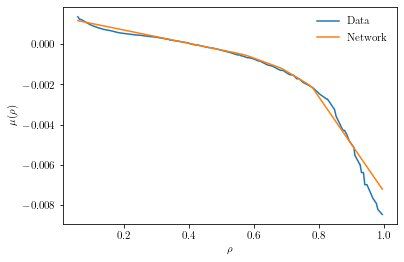

 15%|█▌        | 773/5000 [00:03<00:24, 174.16it/s]

0.0161970853805542


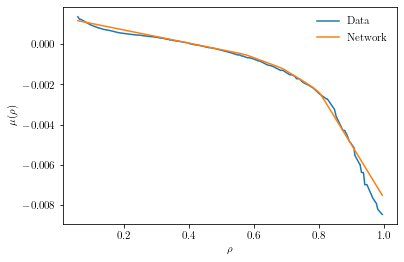

 17%|█▋        | 873/5000 [00:04<00:23, 176.47it/s]

0.014364218339323997


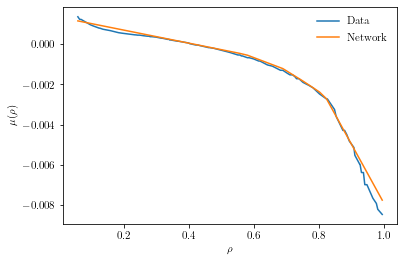

 20%|█▉        | 976/5000 [00:04<00:22, 178.65it/s]

0.01171948667615652


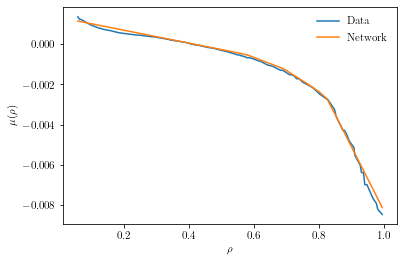

 22%|██▏       | 1092/5000 [00:05<00:20, 194.96it/s]

0.01185586117208004


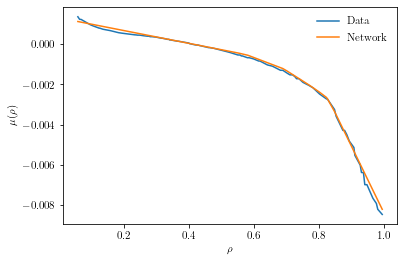

 23%|██▎       | 1137/5000 [00:05<00:25, 149.63it/s]

0.01084858551621437


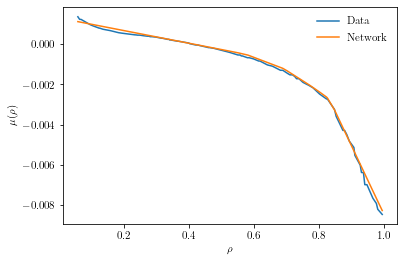

 25%|██▌       | 1264/5000 [00:06<00:19, 195.48it/s]

0.010323080234229565


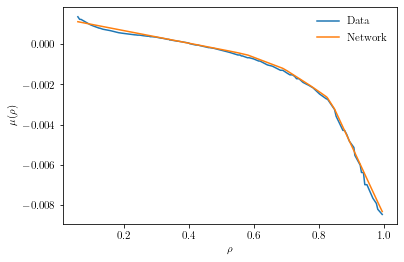

 28%|██▊       | 1379/5000 [00:06<00:17, 205.28it/s]

0.010438296012580395


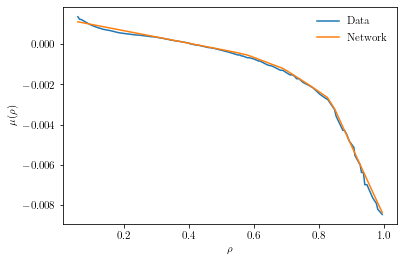

 30%|██▉       | 1481/5000 [00:07<00:17, 203.72it/s]

0.009235533885657787


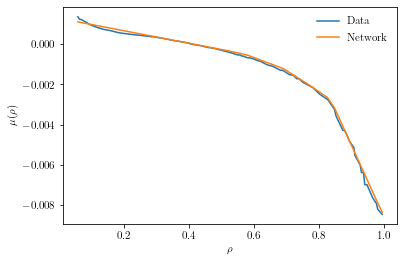

 30%|███       | 1522/5000 [00:07<00:21, 164.25it/s]

0.009832514449954033


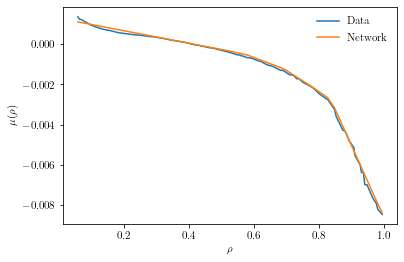

 33%|███▎      | 1655/5000 [00:08<00:15, 211.03it/s]

0.00968692172318697


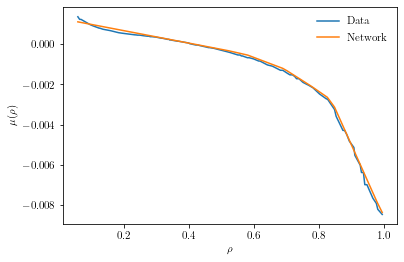

 36%|███▌      | 1778/5000 [00:08<00:15, 207.64it/s]

0.009573107585310936


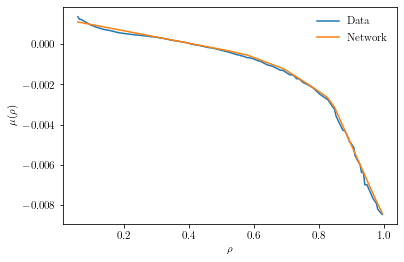

 38%|███▊      | 1880/5000 [00:09<00:15, 205.94it/s]

0.008114974945783615


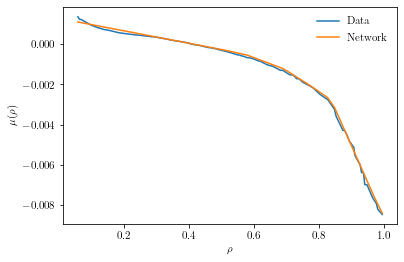

 40%|███▉      | 1996/5000 [00:09<00:14, 212.26it/s]

0.010021006688475609


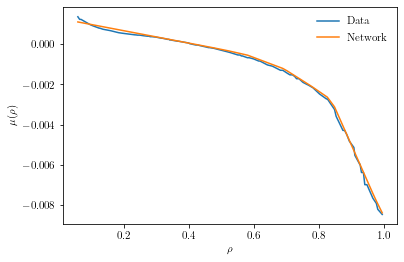

 42%|████▏     | 2089/5000 [00:10<00:13, 209.68it/s]

0.009424014016985893


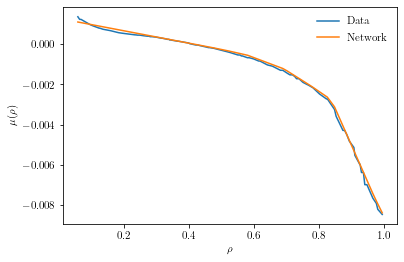

 44%|████▍     | 2190/5000 [00:10<00:14, 190.78it/s]

0.009290209971368313


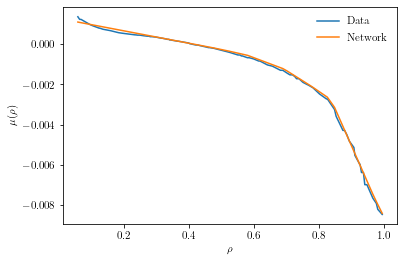

 46%|████▌     | 2295/5000 [00:11<00:14, 188.93it/s]

0.00924549251794815


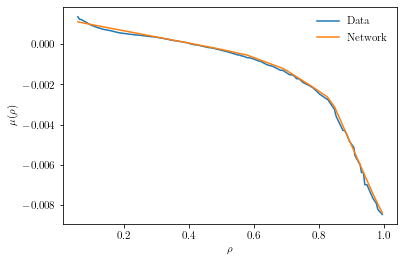

 47%|████▋     | 2336/5000 [00:11<00:17, 148.96it/s]

0.009137739427387714


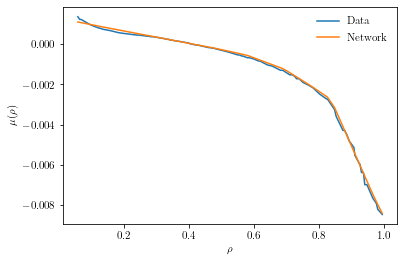

 49%|████▉     | 2473/5000 [00:12<00:12, 199.27it/s]

0.008977753110229969


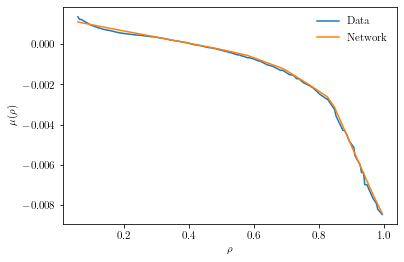

 52%|█████▏    | 2578/5000 [00:13<00:15, 156.05it/s]

0.009328367188572884


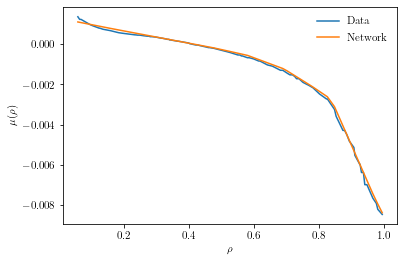

 54%|█████▍    | 2696/5000 [00:13<00:12, 183.80it/s]

0.008768427185714245


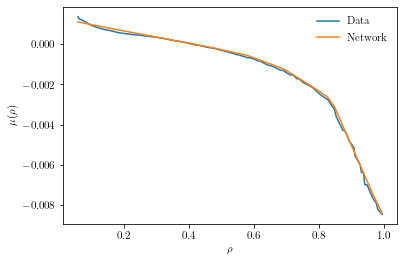

 55%|█████▍    | 2742/5000 [00:13<00:14, 159.18it/s]

0.008760449476540089


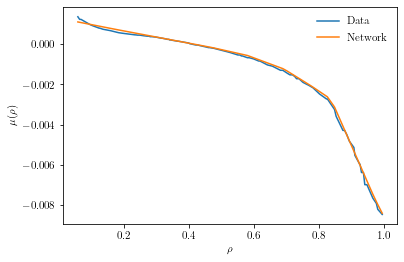

 58%|█████▊    | 2879/5000 [00:14<00:10, 210.34it/s]

0.009821907617151737


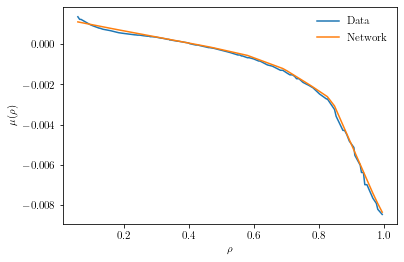

 60%|█████▉    | 2999/5000 [00:14<00:09, 219.60it/s]

0.008817345835268497


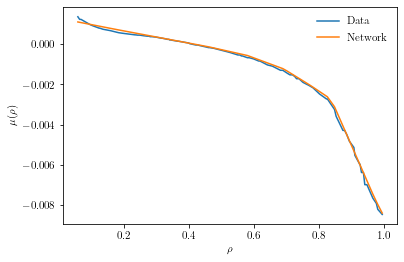

 61%|██████    | 3046/5000 [00:15<00:13, 143.36it/s]

0.008642610162496567


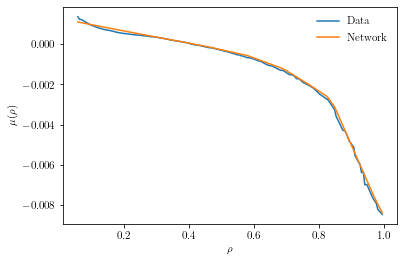

 63%|██████▎   | 3149/5000 [00:15<00:10, 182.49it/s]

0.008372281678020954


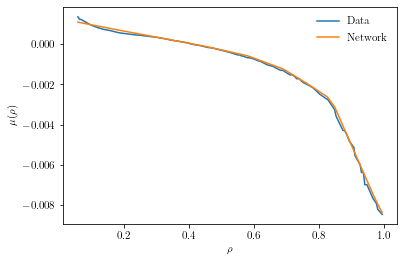

 65%|██████▌   | 3272/5000 [00:16<00:08, 207.31it/s]

0.008134447038173676


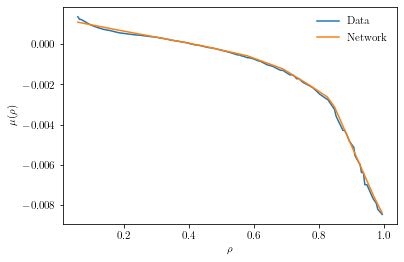

 67%|██████▋   | 3373/5000 [00:16<00:07, 206.18it/s]

0.00842253491282463


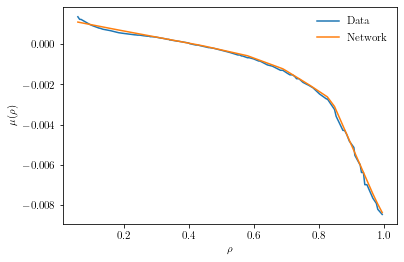

 69%|██████▉   | 3473/5000 [00:17<00:07, 191.26it/s]

0.009696855209767818


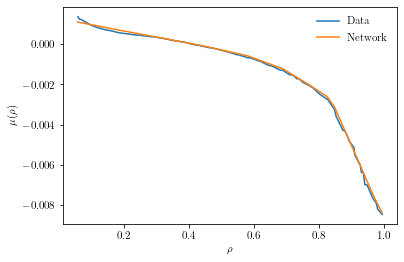

 71%|███████▏  | 3572/5000 [00:17<00:07, 192.64it/s]

0.009970991872251034


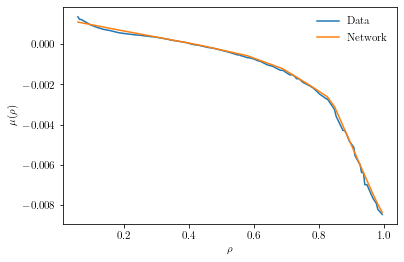

 74%|███████▍  | 3688/5000 [00:18<00:06, 200.23it/s]

0.008410973474383354


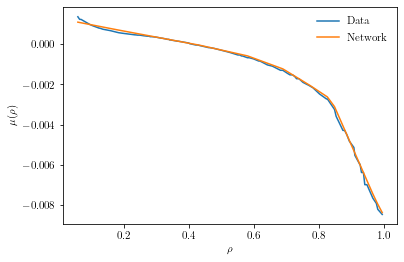

 76%|███████▌  | 3798/5000 [00:18<00:05, 211.70it/s]

0.008437427692115307


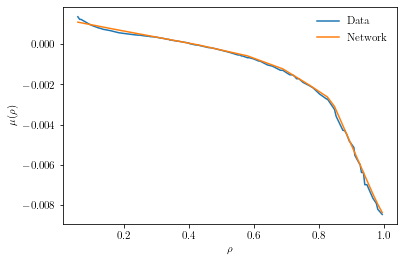

 77%|███████▋  | 3842/5000 [00:19<00:06, 168.88it/s]

0.010178187862038612


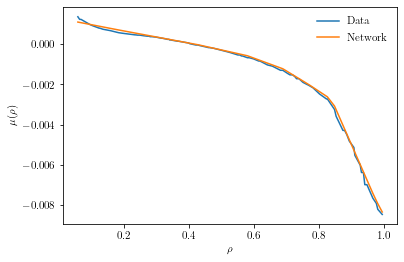

 79%|███████▉  | 3961/5000 [00:19<00:05, 202.32it/s]

0.008445990271866322


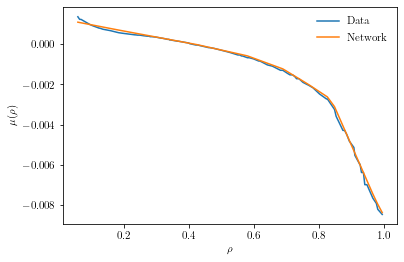

 82%|████████▏ | 4077/5000 [00:20<00:04, 214.28it/s]

0.008429317735135555


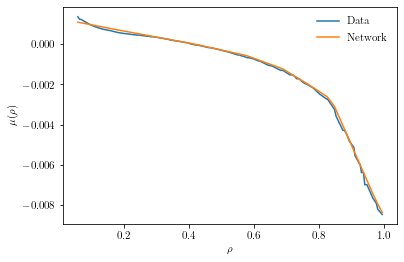

 84%|████████▍ | 4192/5000 [00:20<00:03, 207.81it/s]

0.008417817763984203


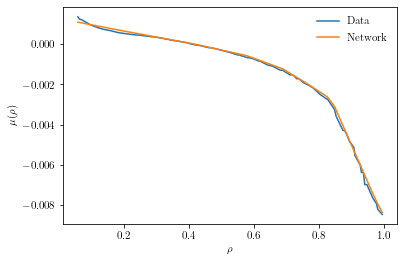

 86%|████████▌ | 4297/5000 [00:21<00:03, 209.74it/s]

0.009645993821322918


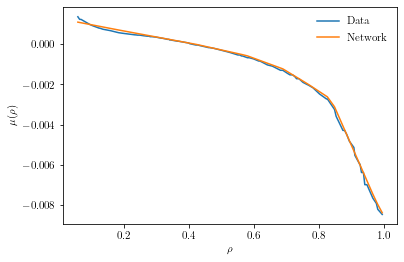

 87%|████████▋ | 4339/5000 [00:21<00:04, 152.82it/s]

0.009672753512859344


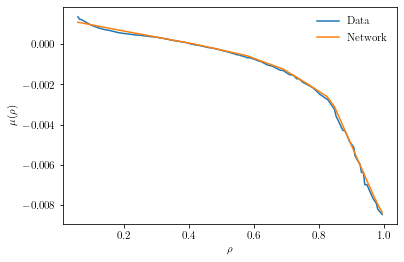

 89%|████████▉ | 4465/5000 [00:22<00:02, 187.39it/s]

0.008392270654439926


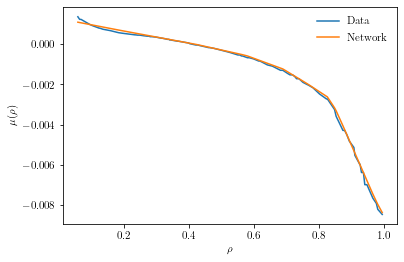

 92%|█████████▏| 4586/5000 [00:22<00:01, 214.92it/s]

0.008375395089387894


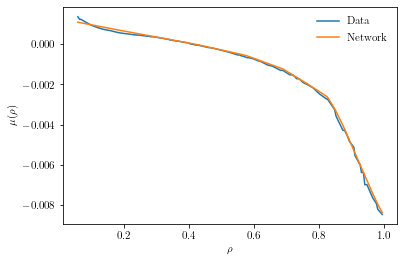

 94%|█████████▍| 4694/5000 [00:23<00:01, 204.38it/s]

0.008451584726572037


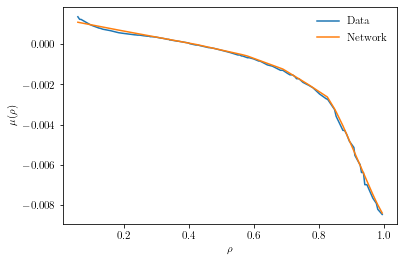

 96%|█████████▌| 4788/5000 [00:23<00:01, 190.59it/s]

0.009381840005517006


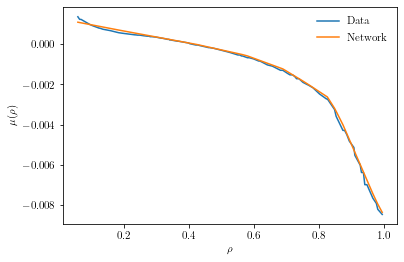

 97%|█████████▋| 4826/5000 [00:24<00:01, 146.52it/s]

0.009246575646102428


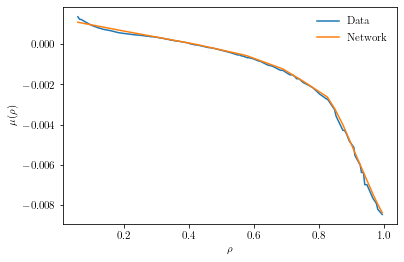

 99%|█████████▉| 4963/5000 [00:24<00:00, 196.06it/s]

0.008179311640560627


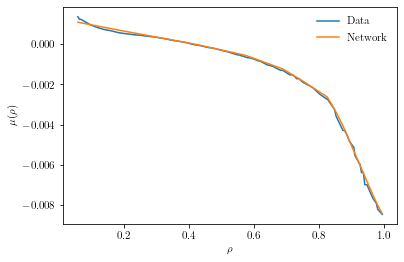

100%|██████████| 5000/5000 [00:25<00:00, 196.92it/s]


Training for model 1


  2%|▏         | 79/5000 [00:00<00:06, 788.60it/s]

0.05750981345772743


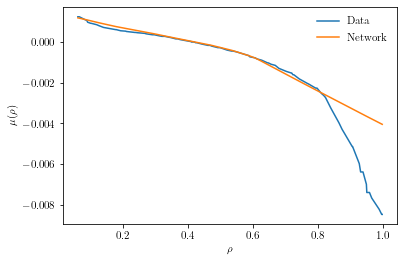

  4%|▎         | 176/5000 [00:00<00:19, 243.41it/s]

0.04499750956892967


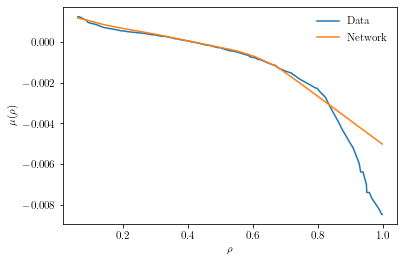

  6%|▌         | 279/5000 [00:00<00:21, 220.70it/s]

0.03341660276055336


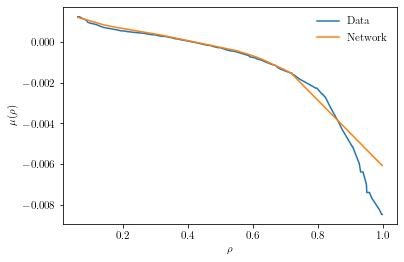

  8%|▊         | 390/5000 [00:01<00:21, 212.21it/s]

0.02396244928240776


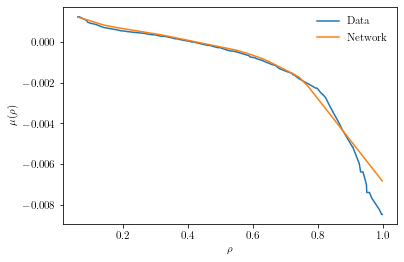

  9%|▊         | 433/5000 [00:01<00:26, 169.36it/s]

0.016666991636157036


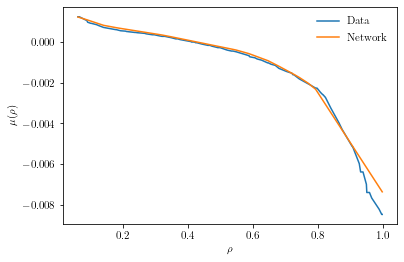

 11%|█▏        | 564/5000 [00:02<00:20, 217.70it/s]

0.010767435654997826


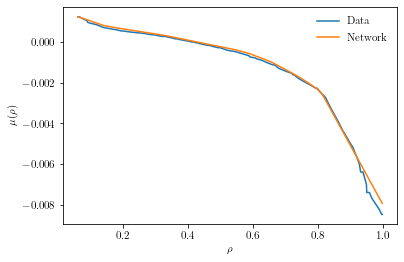

 14%|█▎        | 678/5000 [00:03<00:24, 178.44it/s]

0.009452089667320251


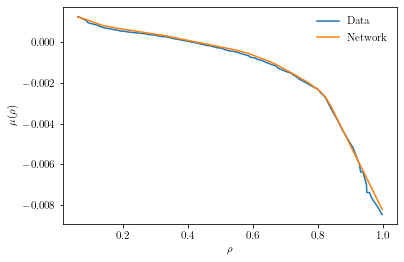

 16%|█▌        | 793/5000 [00:03<00:20, 200.70it/s]

0.007925949990749359


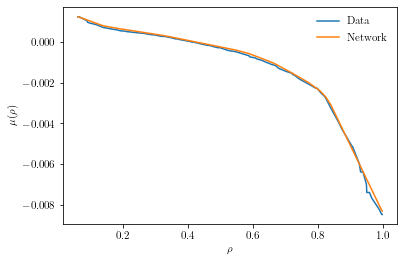

 17%|█▋        | 838/5000 [00:03<00:24, 172.28it/s]

0.008051324635744095


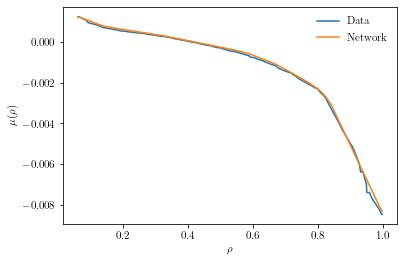

 20%|█▉        | 981/5000 [00:04<00:18, 217.29it/s]

0.007505910471081734


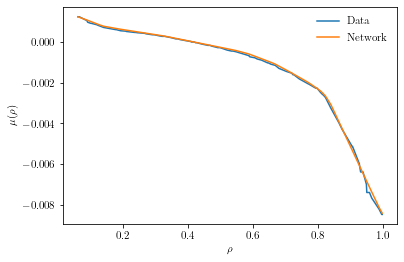

 21%|██        | 1026/5000 [00:04<00:22, 179.29it/s]

0.007217711769044399


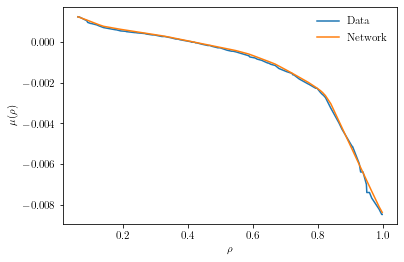

 24%|██▎       | 1183/5000 [00:05<00:15, 242.33it/s]

0.007837892509996891


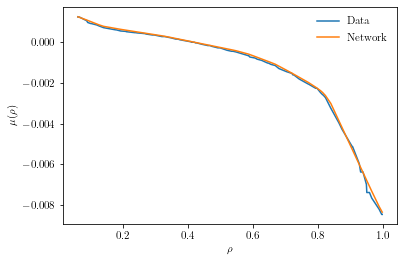

 25%|██▍       | 1230/5000 [00:05<00:19, 194.37it/s]

0.007652852684259415


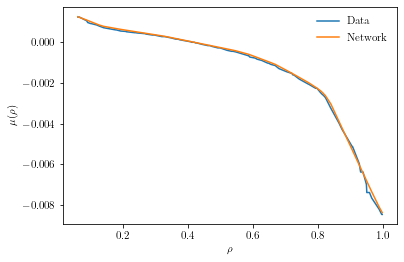

 28%|██▊       | 1381/5000 [00:06<00:14, 247.31it/s]

0.007598081137984991


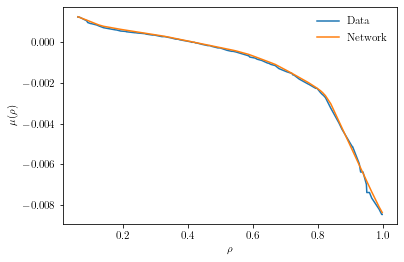

 30%|██▉       | 1493/5000 [00:06<00:14, 247.79it/s]

0.007214349694550037


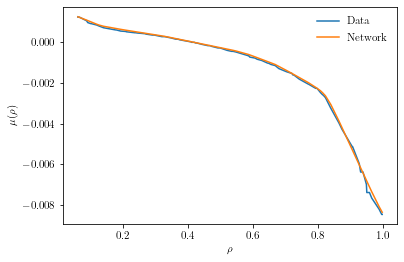

 31%|███       | 1539/5000 [00:06<00:17, 195.45it/s]

0.00735181849449873


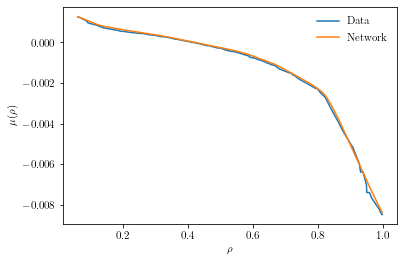

 34%|███▎      | 1679/5000 [00:07<00:13, 243.85it/s]

0.007090186700224876


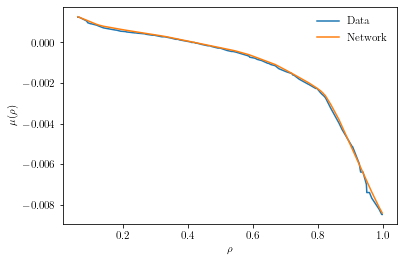

 34%|███▍      | 1724/5000 [00:07<00:16, 196.06it/s]

0.0070173065178096294


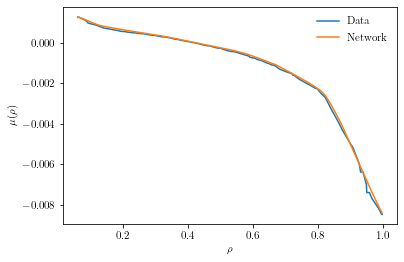

 38%|███▊      | 1882/5000 [00:08<00:12, 251.18it/s]

0.006882199086248875


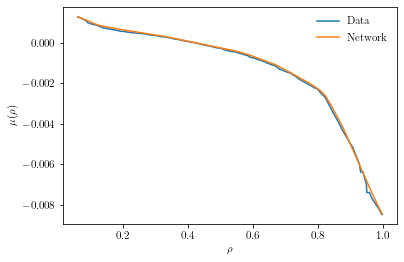

 39%|███▊      | 1928/5000 [00:08<00:16, 182.65it/s]

0.006921322550624609


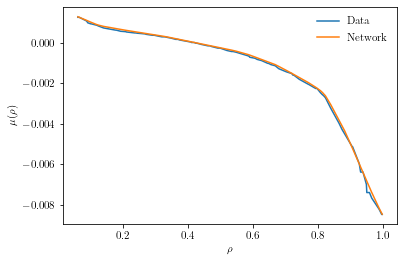

 42%|████▏     | 2079/5000 [00:08<00:12, 239.99it/s]

0.006457387004047632


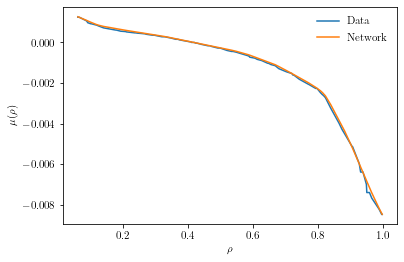

 42%|████▏     | 2124/5000 [00:09<00:15, 190.96it/s]

0.006988752633333206


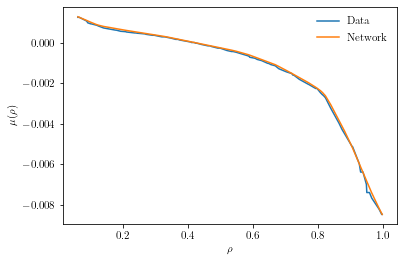

 46%|████▌     | 2280/5000 [00:09<00:10, 248.94it/s]

0.006224049720913172


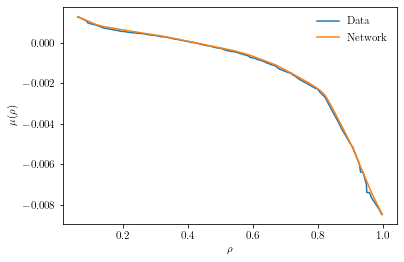

 47%|████▋     | 2326/5000 [00:10<00:13, 198.01it/s]

0.0061728088185191154


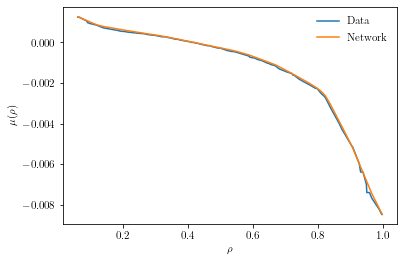

 50%|████▉     | 2478/5000 [00:10<00:09, 255.77it/s]

0.00729060173034668


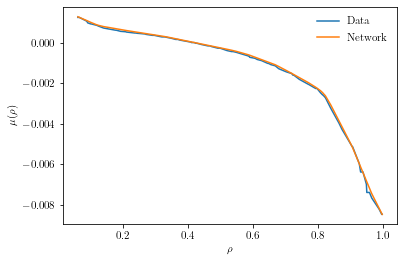

 50%|█████     | 2524/5000 [00:10<00:12, 200.82it/s]

0.0068907421082258224


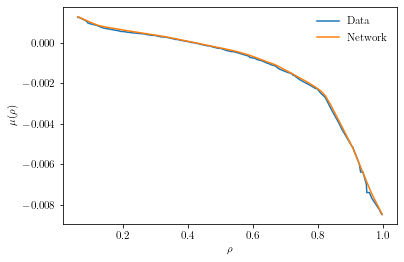

 54%|█████▎    | 2683/5000 [00:11<00:08, 261.41it/s]

0.006556093692779541


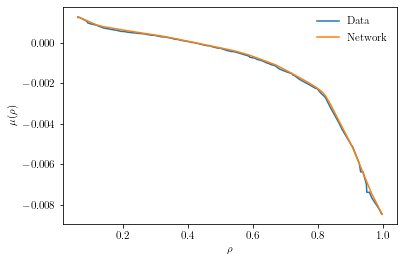

 56%|█████▌    | 2791/5000 [00:11<00:09, 239.03it/s]

0.007090358529239893


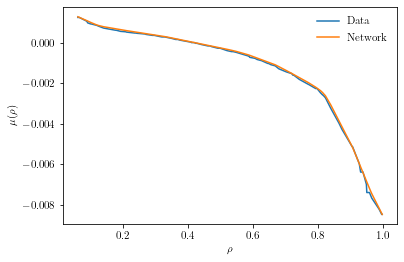

 57%|█████▋    | 2835/5000 [00:12<00:12, 173.20it/s]

0.007035825401544571


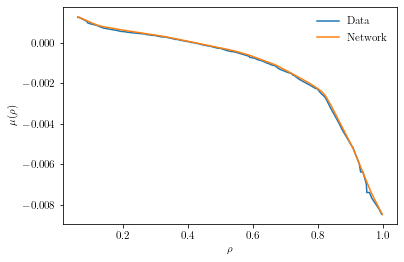

 60%|█████▉    | 2975/5000 [00:12<00:09, 215.14it/s]

0.006027825642377138


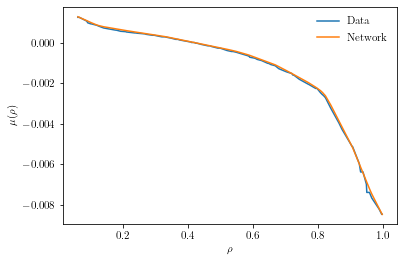

 62%|██████▏   | 3091/5000 [00:13<00:08, 224.43it/s]

0.006033291108906269


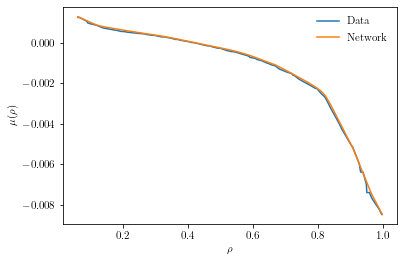

 63%|██████▎   | 3137/5000 [00:13<00:11, 163.50it/s]

0.006503066048026085


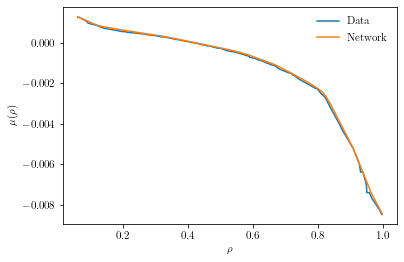

 65%|██████▌   | 3268/5000 [00:14<00:09, 190.91it/s]

0.006312037818133831


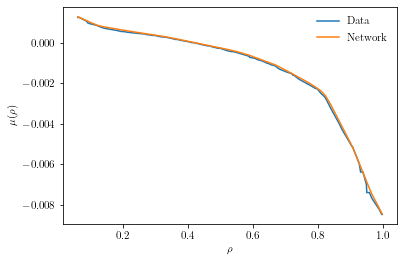

 68%|██████▊   | 3375/5000 [00:14<00:08, 198.34it/s]

0.006047917529940605


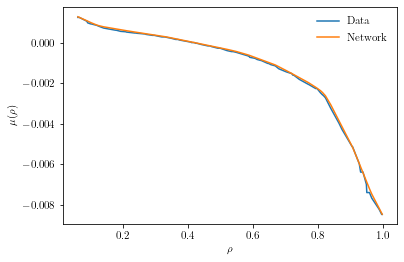

 70%|██████▉   | 3496/5000 [00:15<00:07, 206.90it/s]

0.00605618255212903


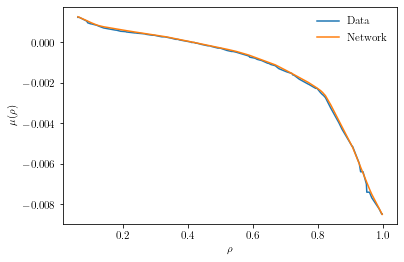

 71%|███████   | 3542/5000 [00:15<00:09, 161.43it/s]

0.006677955389022827


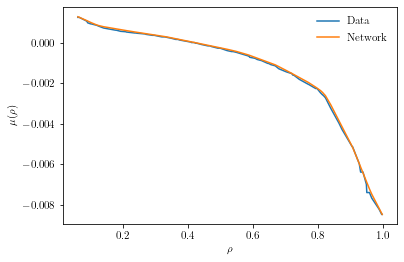

 73%|███████▎  | 3672/5000 [00:16<00:06, 205.18it/s]

0.006435810122638941


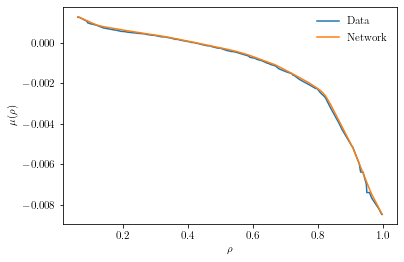

 76%|███████▌  | 3791/5000 [00:16<00:06, 198.59it/s]

0.006556862033903599


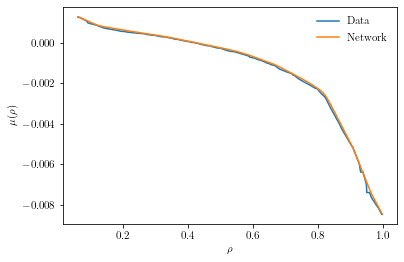

 77%|███████▋  | 3837/5000 [00:17<00:07, 159.51it/s]

0.006902328692376614


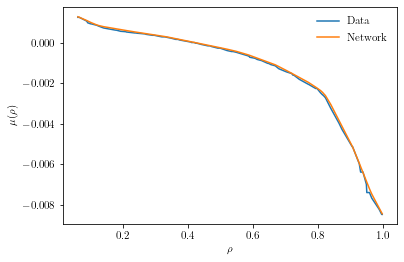

 80%|███████▉  | 3997/5000 [00:18<00:04, 226.62it/s]

0.005698700435459614


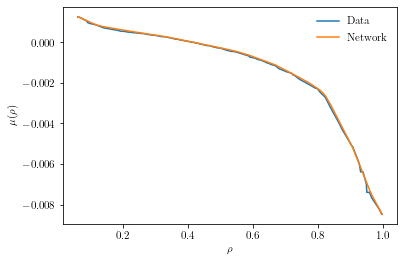

 82%|████████▏ | 4082/5000 [00:18<00:04, 193.78it/s]

0.0058259195648133755


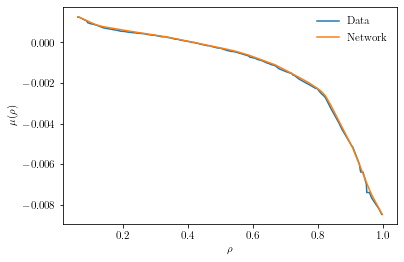

 83%|████████▎ | 4168/5000 [00:19<00:04, 179.21it/s]

0.0057570841163396835


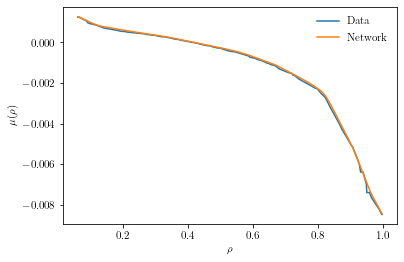

 86%|████████▌ | 4275/5000 [00:19<00:04, 180.04it/s]

0.00621172646060586


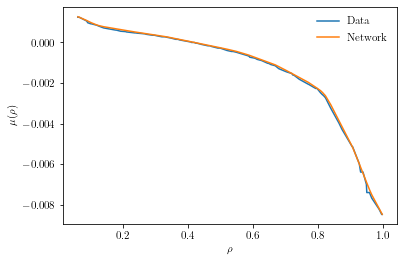

 88%|████████▊ | 4384/5000 [00:20<00:03, 177.02it/s]

0.006336729973554611


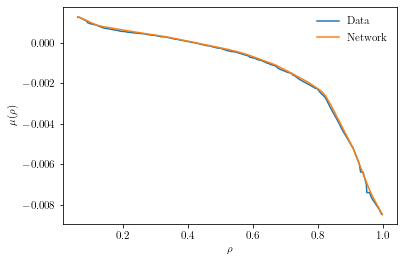

 90%|████████▉ | 4485/5000 [00:20<00:02, 189.79it/s]

0.0053868163377046585


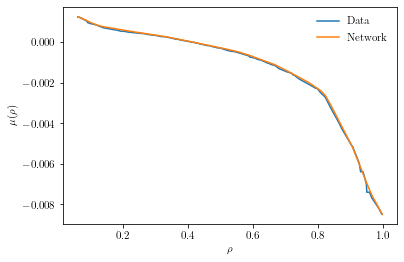

 92%|█████████▏| 4583/5000 [00:21<00:02, 177.75it/s]

0.005950138438493013


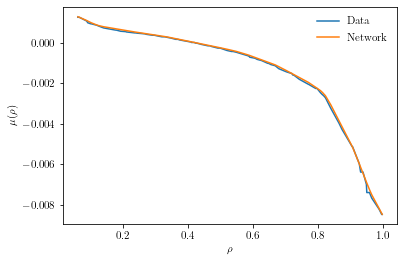

 94%|█████████▎| 4681/5000 [00:21<00:01, 180.19it/s]

0.005820722784847021


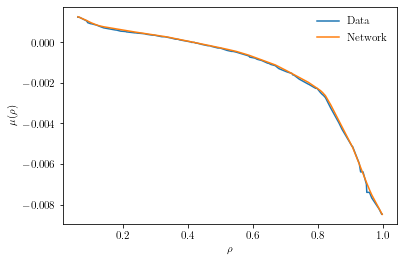

 95%|█████████▌| 4774/5000 [00:22<00:01, 173.62it/s]

0.006368338596075773


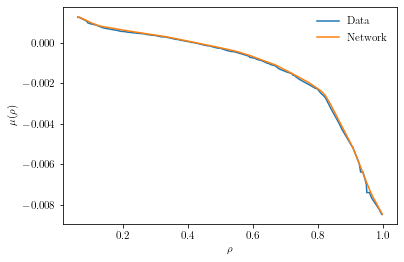

 97%|█████████▋| 4874/5000 [00:22<00:00, 171.73it/s]

0.005992874503135681


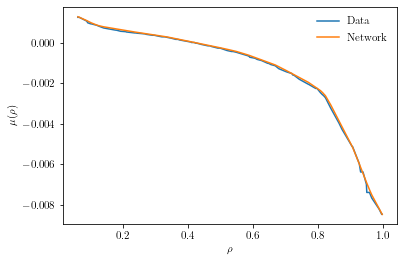

100%|█████████▉| 4988/5000 [00:23<00:00, 190.81it/s]

0.005860283505171537


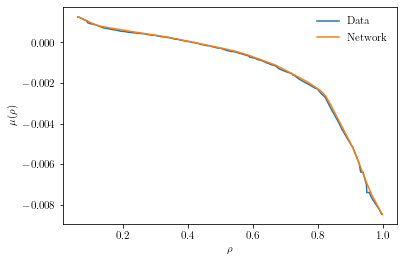

100%|██████████| 5000/5000 [00:23<00:00, 210.21it/s]


Training for model 2


  2%|▏         | 75/5000 [00:00<00:06, 741.85it/s]

0.042952489107847214


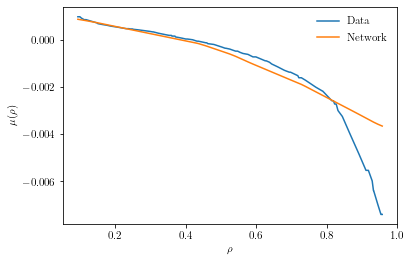

  3%|▎         | 159/5000 [00:00<00:23, 205.24it/s]

0.03333631157875061


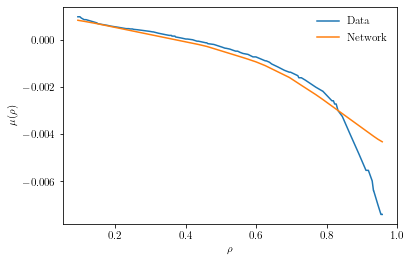

  5%|▌         | 253/5000 [00:01<00:25, 188.95it/s]

0.028423354029655457


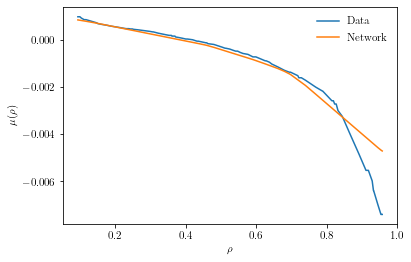

  7%|▋         | 358/5000 [00:01<00:22, 206.56it/s]

0.025360099971294403


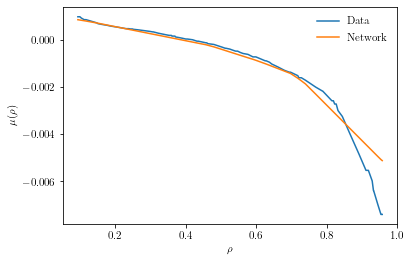

  9%|▉         | 473/5000 [00:02<00:20, 224.81it/s]

0.022339124232530594


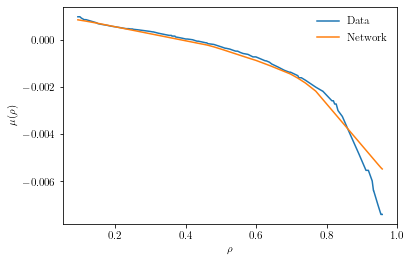

 12%|█▏        | 586/5000 [00:02<00:18, 232.95it/s]

0.01823028177022934


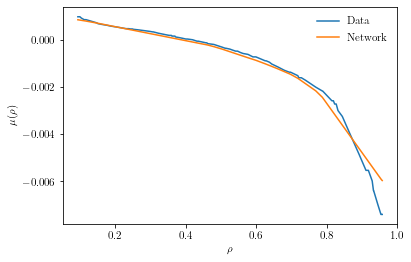

 14%|█▎        | 683/5000 [00:03<00:19, 220.45it/s]

0.014594106934964657


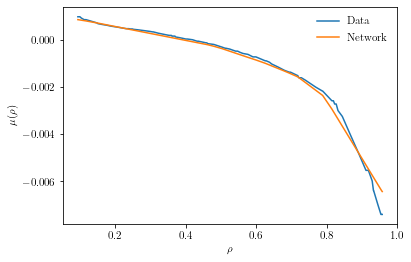

 14%|█▍        | 723/5000 [00:03<00:24, 175.87it/s]

0.010957709513604641


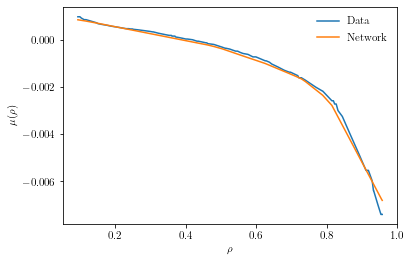

 18%|█▊        | 875/5000 [00:03<00:17, 235.64it/s]

0.008346263319253922


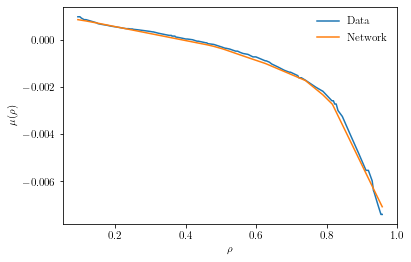

 20%|█▉        | 993/5000 [00:04<00:17, 224.99it/s]

0.008239108137786388


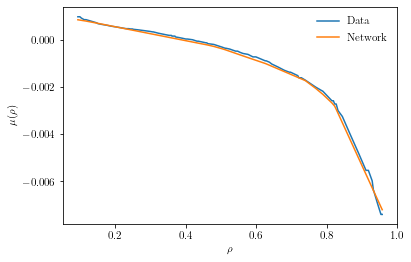

 21%|██        | 1028/5000 [00:05<00:28, 138.06it/s]

0.007081425283104181


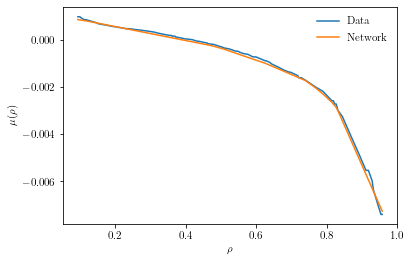

 23%|██▎       | 1168/5000 [00:05<00:19, 194.04it/s]

0.007287392392754555


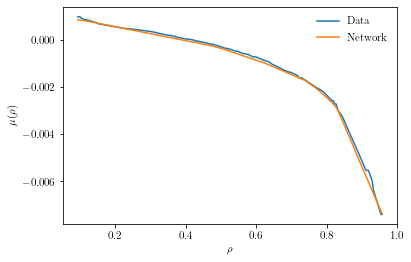

 26%|██▌       | 1281/5000 [00:05<00:17, 210.07it/s]

0.007317869458347559


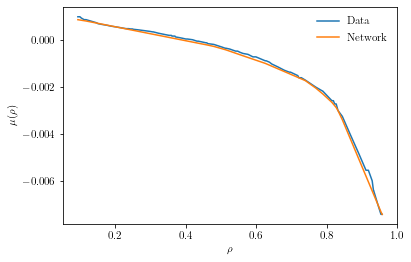

 26%|██▋       | 1325/5000 [00:06<00:20, 178.13it/s]

0.006913879886269569


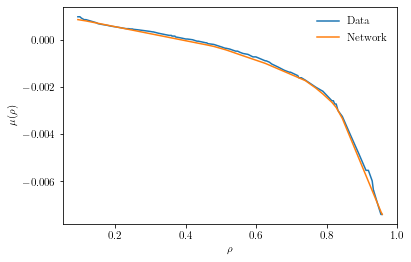

 30%|██▉       | 1483/5000 [00:06<00:14, 243.50it/s]

0.007138431072235107


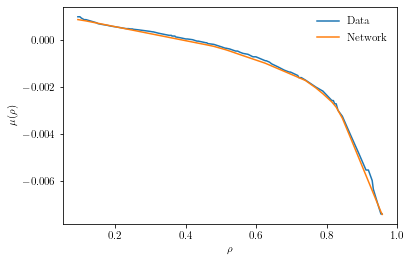

 31%|███       | 1530/5000 [00:07<00:19, 178.80it/s]

0.006895767524838448


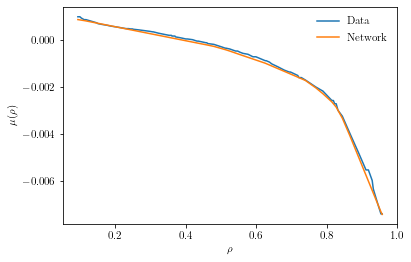

 34%|███▎      | 1677/5000 [00:07<00:14, 230.68it/s]

0.00699101947247982


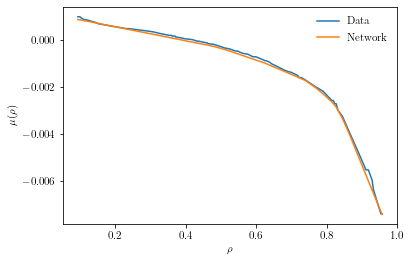

 34%|███▍      | 1722/5000 [00:07<00:17, 189.67it/s]

0.006789990700781345


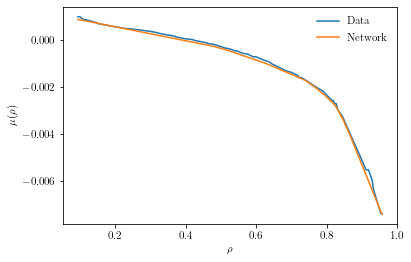

 38%|███▊      | 1883/5000 [00:08<00:12, 254.39it/s]

0.006828867364674807


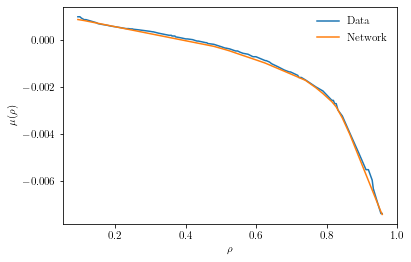

 39%|███▊      | 1930/5000 [00:08<00:14, 205.61it/s]

0.006038137245923281


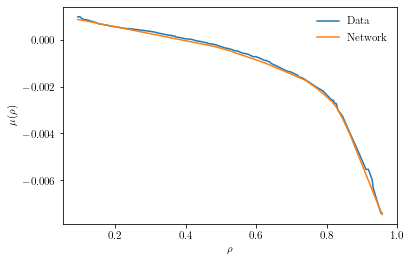

 42%|████▏     | 2083/5000 [00:09<00:11, 263.20it/s]

0.006377364508807659


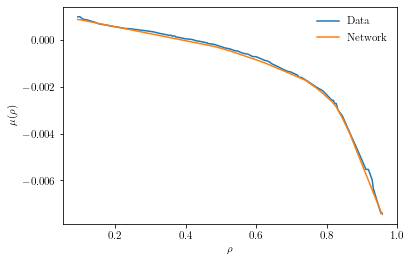

 43%|████▎     | 2130/5000 [00:09<00:14, 200.57it/s]

0.006441995967179537


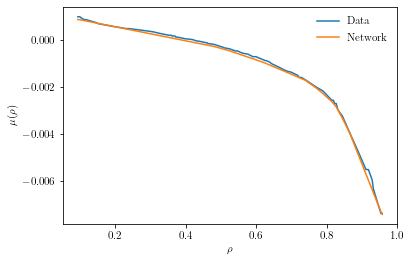

 46%|████▌     | 2284/5000 [00:10<00:10, 260.31it/s]

0.006298852153122425


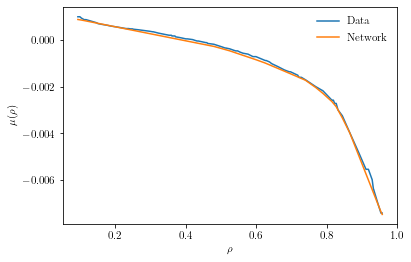

 47%|████▋     | 2332/5000 [00:10<00:13, 193.84it/s]

0.006099814549088478


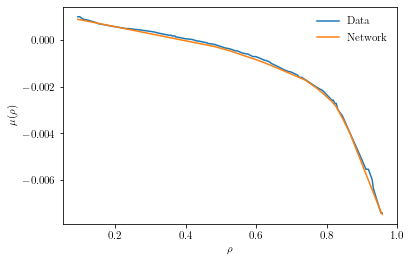

 50%|████▉     | 2481/5000 [00:10<00:10, 250.69it/s]

0.006261083297431469


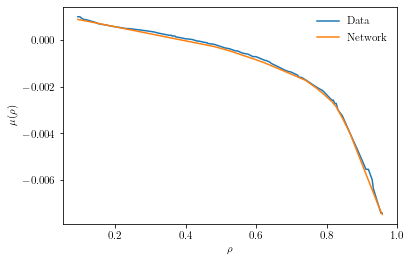

 51%|█████     | 2528/5000 [00:11<00:12, 203.60it/s]

0.005653109401464462


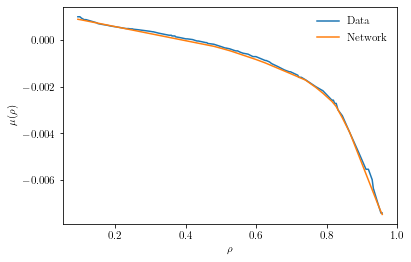

 54%|█████▎    | 2681/5000 [00:11<00:08, 260.87it/s]

0.005517659243196249


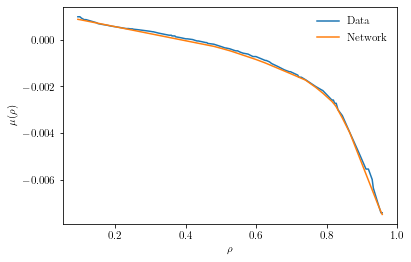

 55%|█████▍    | 2728/5000 [00:12<00:11, 206.11it/s]

0.00558121083304286


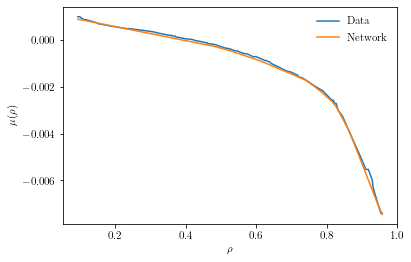

 58%|█████▊    | 2880/5000 [00:12<00:08, 259.60it/s]

0.00593419186770916


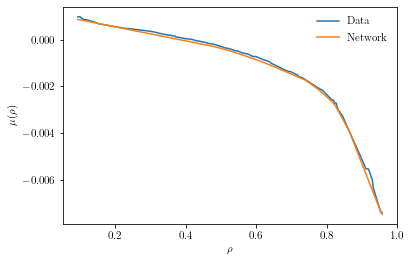

 59%|█████▊    | 2926/5000 [00:12<00:10, 204.28it/s]

0.006142509635537863


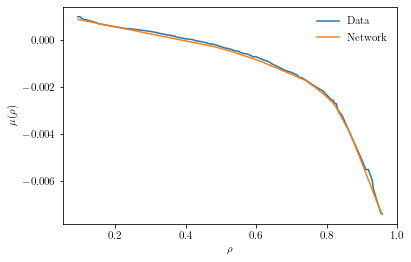

 61%|██████▏   | 3069/5000 [00:13<00:09, 201.05it/s]

0.0057557434774935246


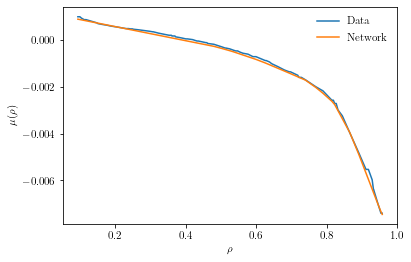

 64%|██████▍   | 3197/5000 [00:14<00:08, 210.52it/s]

0.006053760182112455


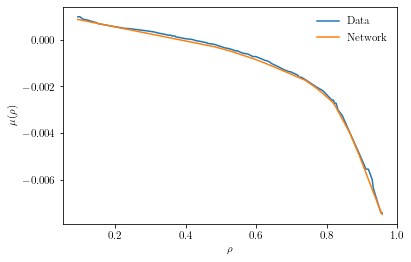

 65%|██████▌   | 3272/5000 [00:14<00:10, 164.04it/s]

0.00583965377882123


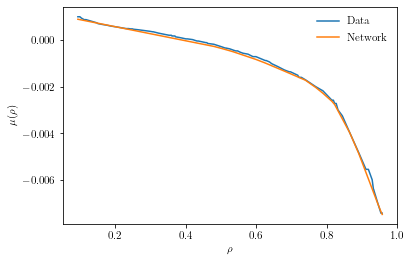

 67%|██████▋   | 3362/5000 [00:16<00:15, 108.92it/s]

0.006087015382945538


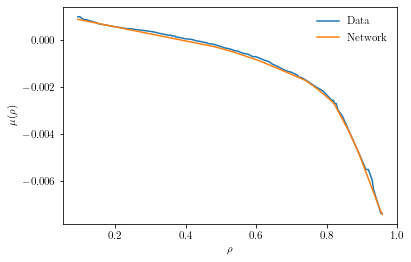

 70%|██████▉   | 3482/5000 [00:16<00:11, 132.44it/s]

0.006571775767952204


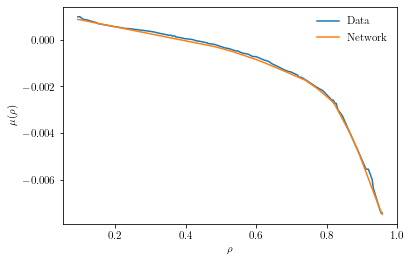

 70%|███████   | 3521/5000 [00:17<00:11, 126.47it/s]

0.006238388828933239


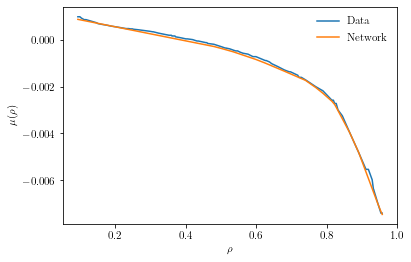

 73%|███████▎  | 3673/5000 [00:17<00:07, 181.06it/s]

0.006567637901753187


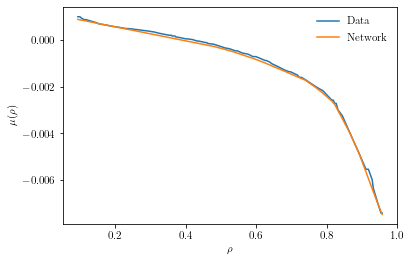

 75%|███████▌  | 3770/5000 [00:18<00:10, 121.89it/s]

0.006194862071424723


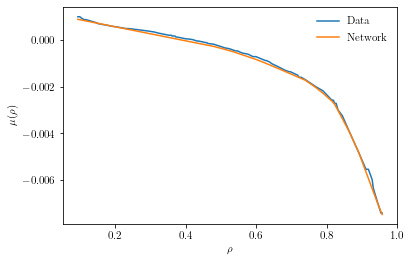

 77%|███████▋  | 3855/5000 [00:19<00:12, 93.94it/s] 

0.005572608206421137


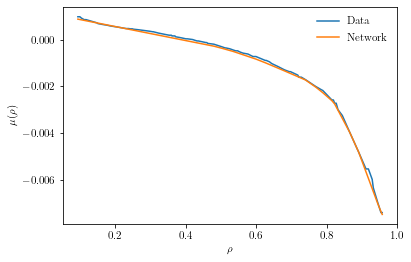

 79%|███████▉  | 3966/5000 [00:20<00:07, 131.38it/s]

0.005459947045892477


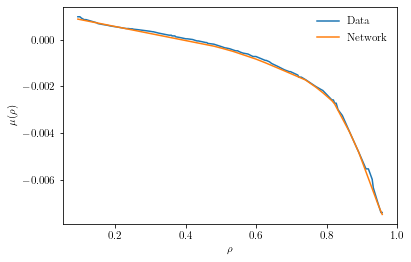

 82%|████████▏ | 4076/5000 [00:21<00:06, 140.86it/s]

0.006273353472352028


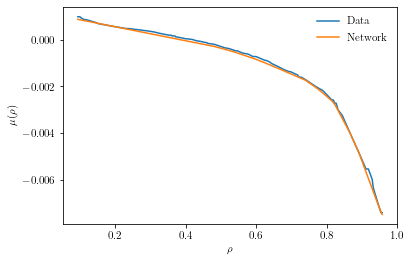

 84%|████████▍ | 4190/5000 [00:22<00:06, 128.16it/s]

0.006323560606688261


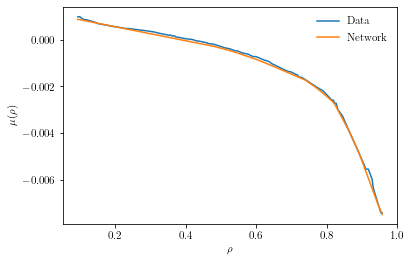

 86%|████████▌ | 4281/5000 [00:22<00:06, 114.41it/s]

0.006042504217475653


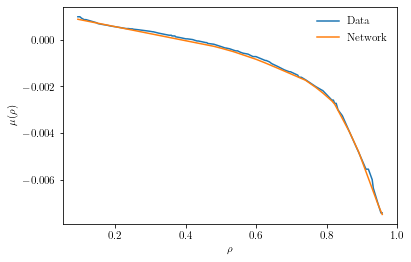

 87%|████████▋ | 4362/5000 [00:23<00:05, 119.72it/s]

0.006296183913946152


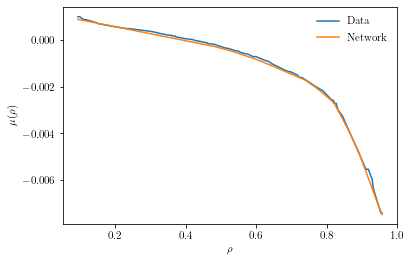

 90%|████████▉ | 4499/5000 [00:24<00:03, 144.01it/s]

0.005415318999439478


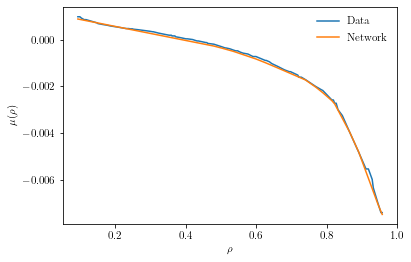

 92%|█████████▏| 4588/5000 [00:25<00:03, 123.78it/s]

0.005711164325475693


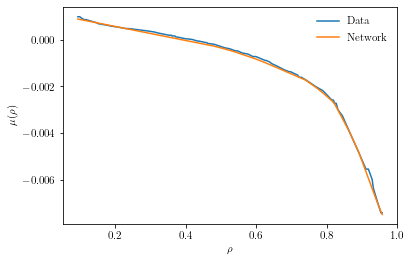

 94%|█████████▎| 4679/5000 [00:26<00:02, 121.56it/s]

0.005291602574288845


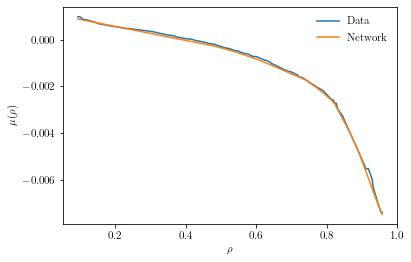

 96%|█████████▌| 4787/5000 [00:28<00:01, 110.00it/s]

0.00573068019002676


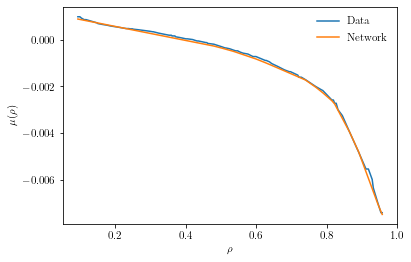

 98%|█████████▊| 4890/5000 [00:30<00:01, 73.92it/s] 

0.005147325806319714


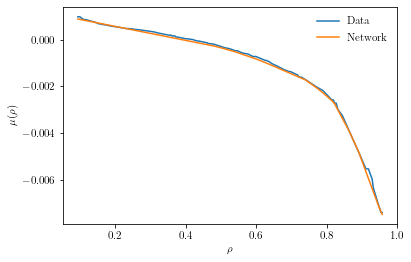

100%|█████████▉| 4985/5000 [00:31<00:00, 68.08it/s]

0.0060049742460250854


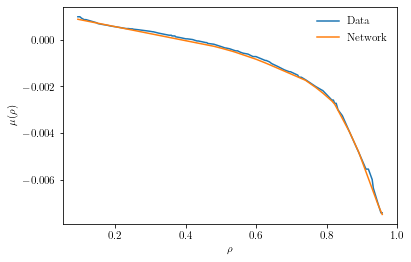

100%|██████████| 5000/5000 [00:32<00:00, 152.88it/s]


Training for model 3


  1%|          | 61/5000 [00:00<00:08, 598.59it/s]

0.03808007761836052


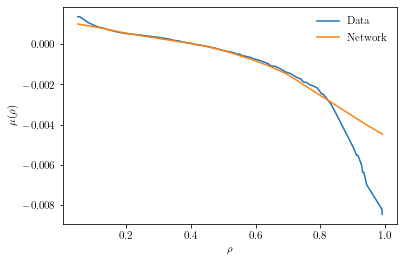

  4%|▎         | 182/5000 [00:00<00:18, 265.38it/s]

0.02943013422191143


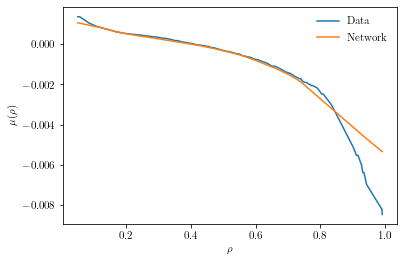

  6%|▌         | 298/5000 [00:01<00:20, 230.39it/s]

0.021683592349290848


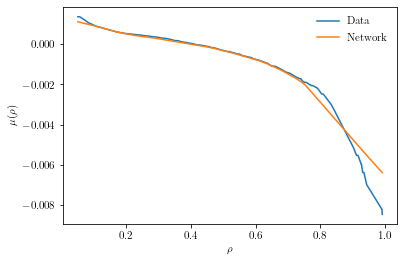

  7%|▋         | 342/5000 [00:01<00:27, 169.97it/s]

0.013402394950389862


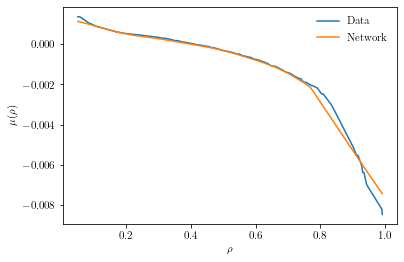

 10%|▉         | 488/5000 [00:02<00:21, 207.91it/s]

0.00893485452979803


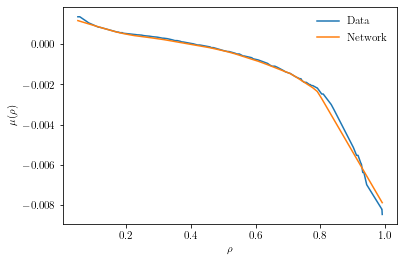

 12%|█▏        | 593/5000 [00:02<00:25, 172.86it/s]

0.0068421922624111176


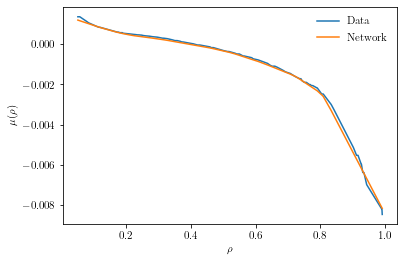

 14%|█▍        | 695/5000 [00:03<00:24, 172.64it/s]

0.005485678091645241


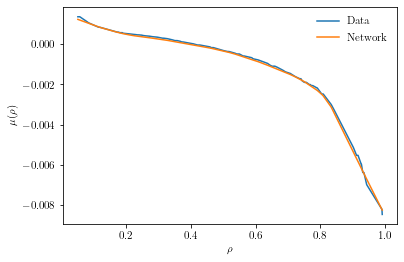

 16%|█▌        | 780/5000 [00:03<00:24, 175.61it/s]

0.005643084179610014


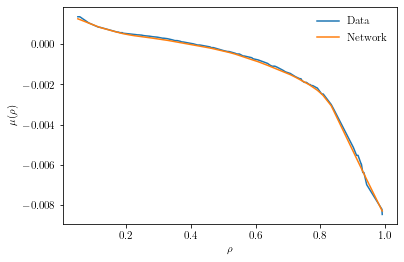

 17%|█▋        | 873/5000 [00:04<00:26, 156.75it/s]

0.005051727872341871


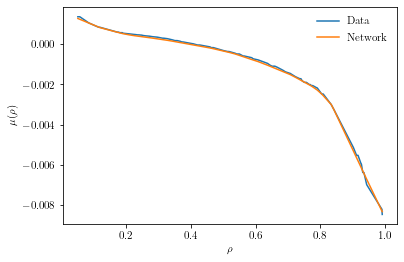

 20%|█▉        | 977/5000 [00:05<00:21, 188.95it/s]

0.004830450285226107


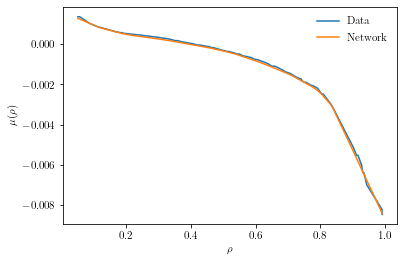

 22%|██▏       | 1090/5000 [00:05<00:22, 172.49it/s]

0.00490379985421896


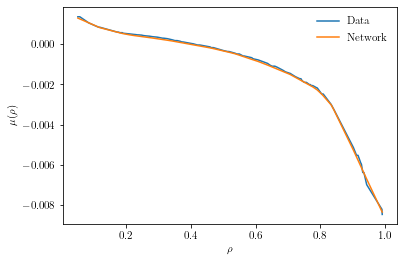

 23%|██▎       | 1131/5000 [00:05<00:26, 143.46it/s]

0.004738136660307646


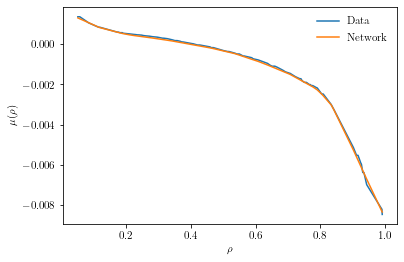

 26%|██▌       | 1277/5000 [00:06<00:18, 200.28it/s]

0.004770522005856037


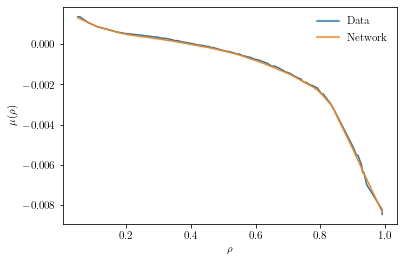

 28%|██▊       | 1389/5000 [00:07<00:18, 191.33it/s]

0.004895559977740049


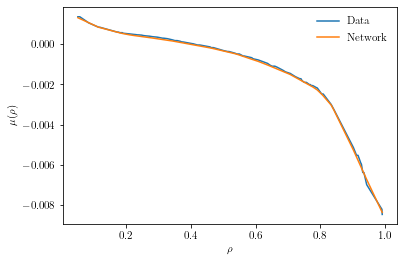

 29%|██▉       | 1464/5000 [00:08<00:30, 114.23it/s]

0.004828751552850008


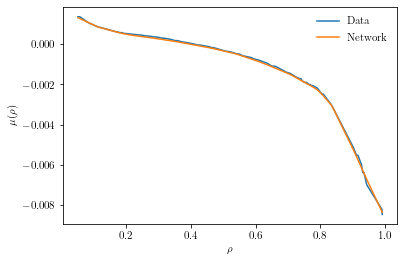

 31%|███▏      | 1564/5000 [00:08<00:27, 125.06it/s]

0.00491976598277688


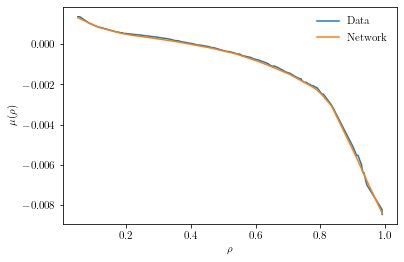

 33%|███▎      | 1663/5000 [00:09<00:23, 142.37it/s]

0.004949824418872595


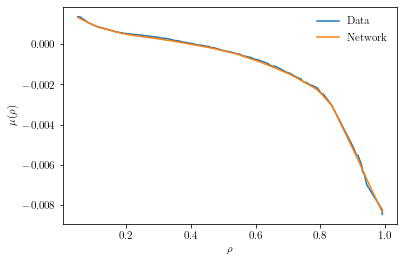

 35%|███▌      | 1753/5000 [00:09<00:21, 151.79it/s]

0.0047226822935044765


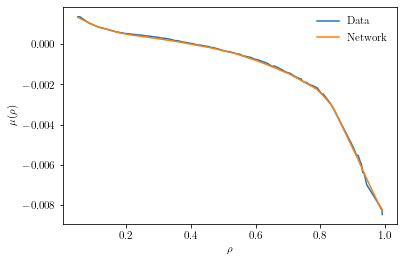

 37%|███▋      | 1850/5000 [00:10<00:18, 168.72it/s]

0.0048024957068264484


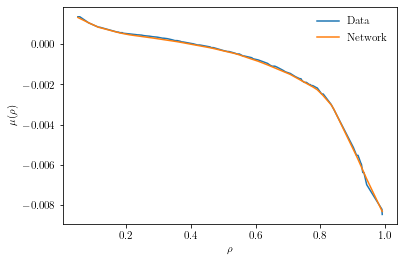

 39%|███▉      | 1962/5000 [00:11<00:16, 181.08it/s]

0.004884133115410805


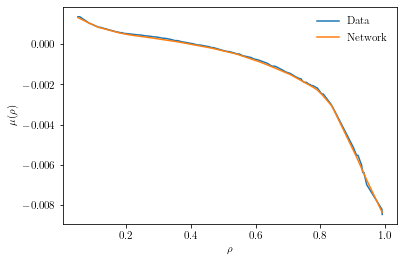

 41%|████▏     | 2070/5000 [00:11<00:19, 152.03it/s]

0.004735416267067194


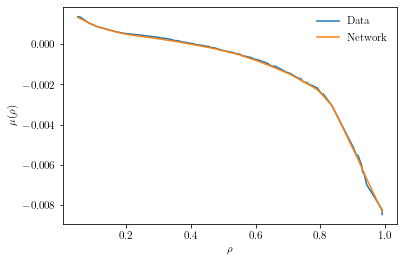

 43%|████▎     | 2174/5000 [00:12<00:20, 138.31it/s]

0.004648197442293167


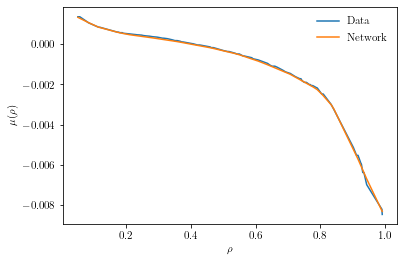

 45%|████▌     | 2265/5000 [00:13<00:17, 158.22it/s]

0.004598336759954691


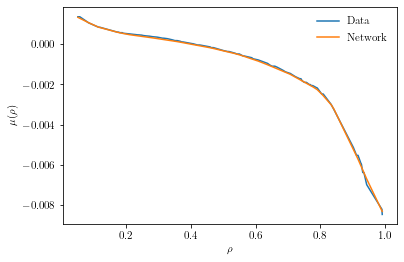

 47%|████▋     | 2353/5000 [00:13<00:16, 164.59it/s]

0.004588384181261063


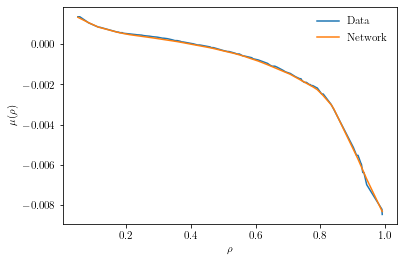

 50%|████▉     | 2478/5000 [00:14<00:12, 195.22it/s]

0.004609999712556601


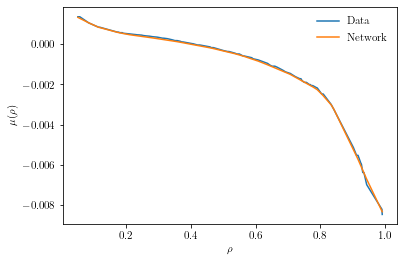

 52%|█████▏    | 2593/5000 [00:14<00:12, 195.55it/s]

0.004637431353330612


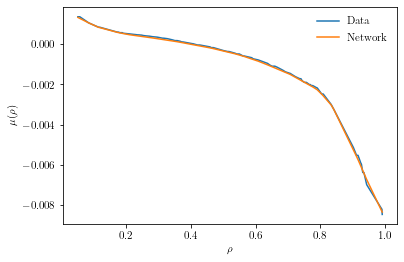

 53%|█████▎    | 2638/5000 [00:15<00:15, 151.22it/s]

0.004528975114226341


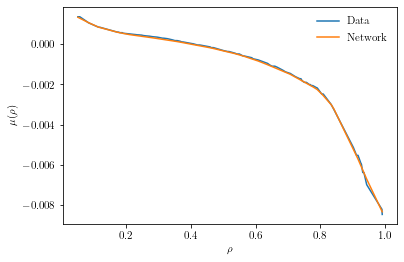

 55%|█████▌    | 2765/5000 [00:15<00:12, 182.29it/s]

0.0046050637029111385


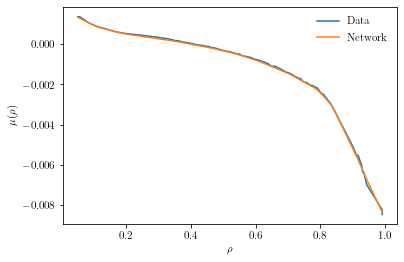

 57%|█████▋    | 2869/5000 [00:16<00:11, 177.87it/s]

0.004559851251542568


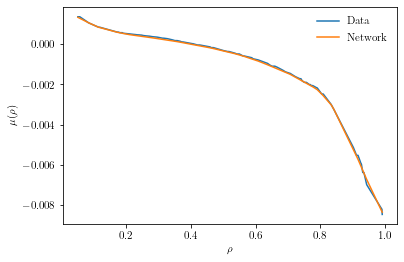

 60%|█████▉    | 2977/5000 [00:16<00:11, 177.58it/s]

0.004584531299769878


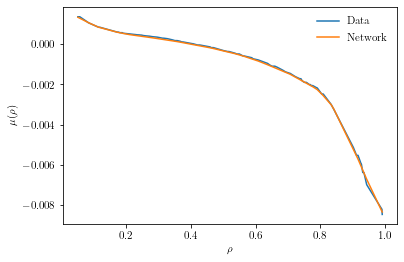

 61%|██████▏   | 3066/5000 [00:17<00:10, 181.63it/s]

0.0046538482420146465


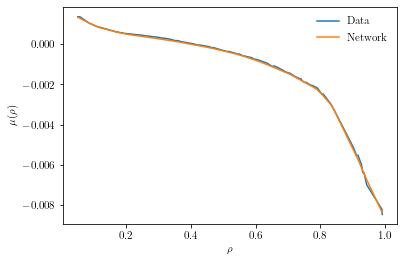

 63%|██████▎   | 3148/5000 [00:17<00:10, 168.63it/s]

0.004626477137207985


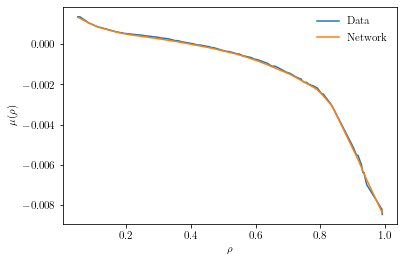

 65%|██████▌   | 3254/5000 [00:18<00:08, 194.85it/s]

0.004556849133223295


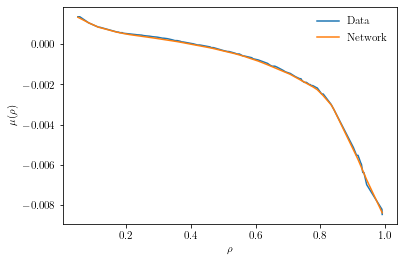

 67%|██████▋   | 3349/5000 [00:18<00:08, 197.30it/s]

0.004443778656423092


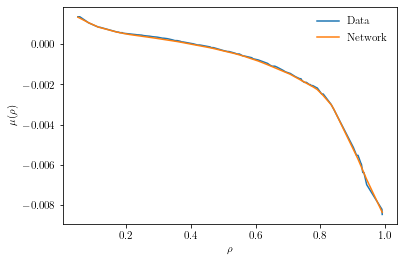

 70%|██████▉   | 3479/5000 [00:19<00:06, 228.14it/s]

0.004397210199385881


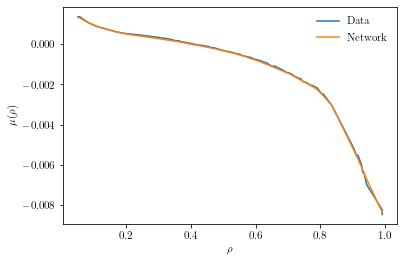

 72%|███████▏  | 3599/5000 [00:19<00:06, 225.09it/s]

0.0045122988522052765


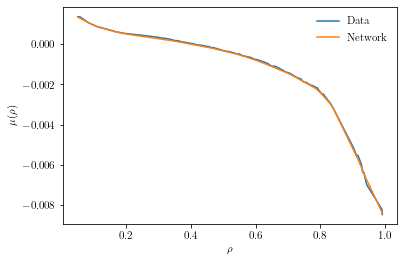

 73%|███████▎  | 3646/5000 [00:20<00:08, 167.43it/s]

0.004824792966246605


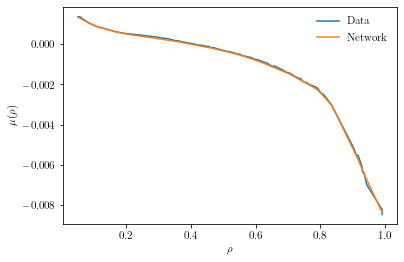

 75%|███████▌  | 3771/5000 [00:20<00:05, 210.86it/s]

0.0044798655435442924


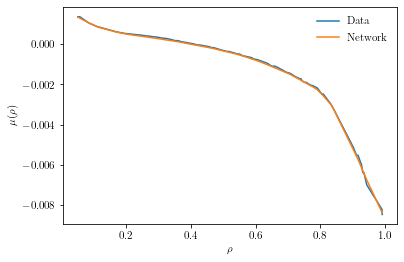

 78%|███████▊  | 3883/5000 [00:21<00:05, 214.44it/s]

0.0046022809110581875


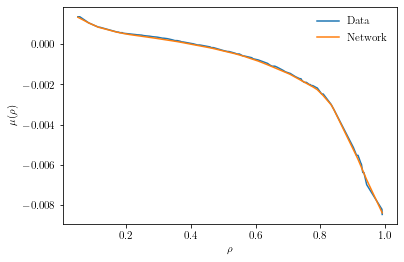

 80%|███████▉  | 3994/5000 [00:21<00:04, 217.25it/s]

0.004583355970680714


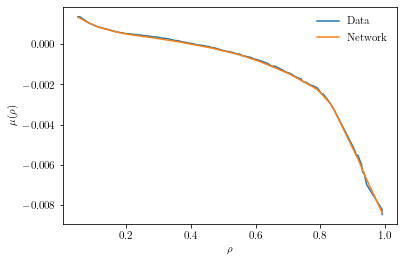

 81%|████████  | 4038/5000 [00:22<00:06, 149.75it/s]

0.004526335280388594


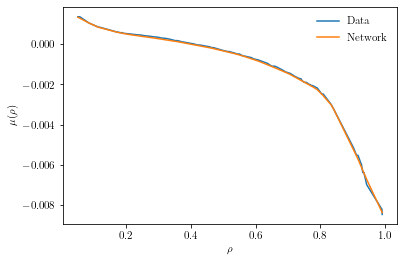

 83%|████████▎ | 4164/5000 [00:22<00:04, 196.91it/s]

0.004448919557034969


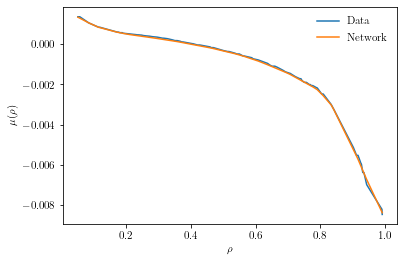

 85%|████████▌ | 4272/5000 [00:23<00:03, 188.70it/s]

0.0049968441016972065


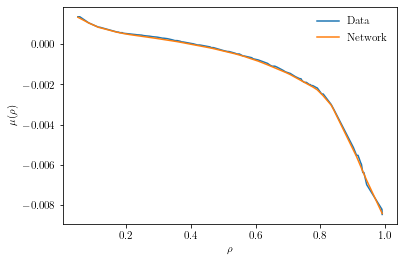

 88%|████████▊ | 4380/5000 [00:23<00:02, 209.47it/s]

0.005042091477662325


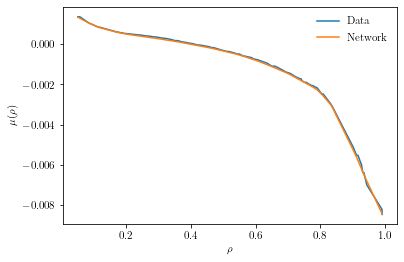

 90%|████████▉ | 4489/5000 [00:24<00:02, 198.65it/s]

0.0045934999361634254


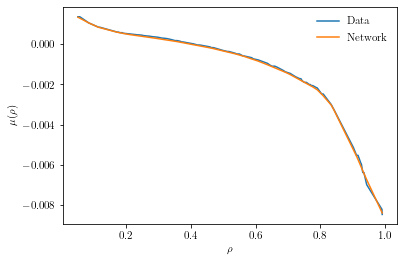

 91%|█████████ | 4532/5000 [00:24<00:02, 167.09it/s]

0.004716690629720688


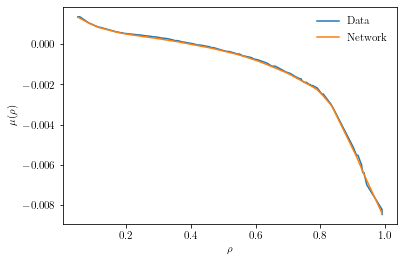

 93%|█████████▎| 4670/5000 [00:25<00:01, 205.69it/s]

0.004627362824976444


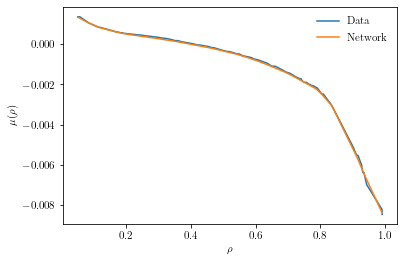

 96%|█████████▌| 4775/5000 [00:25<00:01, 215.92it/s]

0.0047707208432257175


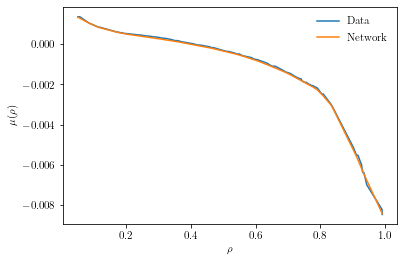

 98%|█████████▊| 4886/5000 [00:26<00:00, 195.76it/s]

0.004440177232027054


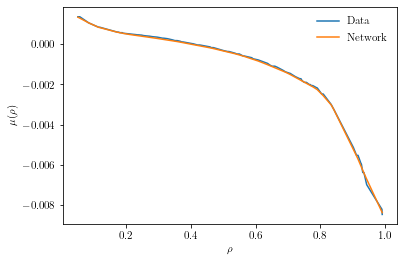

100%|█████████▉| 4986/5000 [00:26<00:00, 205.33it/s]

0.0044770375825464725


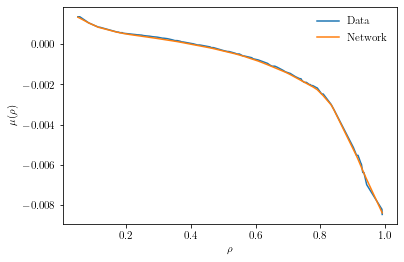

100%|██████████| 5000/5000 [00:27<00:00, 183.63it/s]


Training for model 4


  1%|▏         | 69/5000 [00:00<00:07, 685.71it/s]

0.04971669614315033


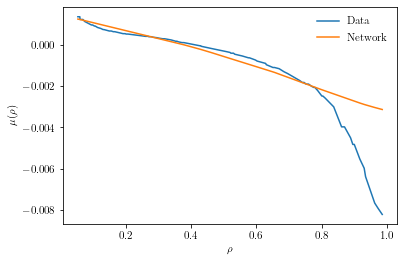

  3%|▎         | 156/5000 [00:00<00:19, 252.61it/s]

0.04067564010620117


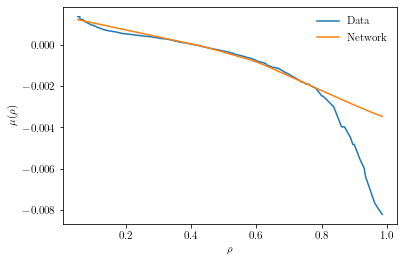

  5%|▌         | 272/5000 [00:01<00:19, 241.13it/s]

0.039924927055835724


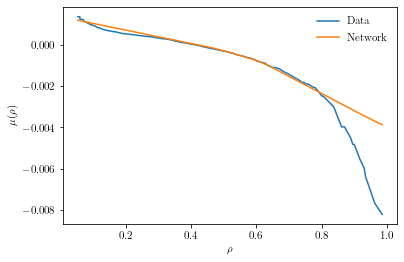

  8%|▊         | 378/5000 [00:01<00:24, 190.51it/s]

0.034411586821079254


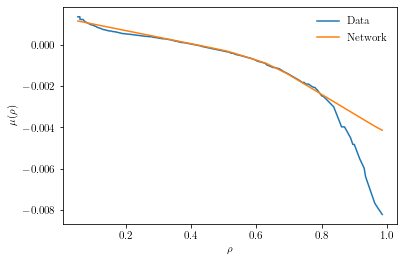

 10%|▉         | 482/5000 [00:02<00:22, 197.75it/s]

0.03138178959488869


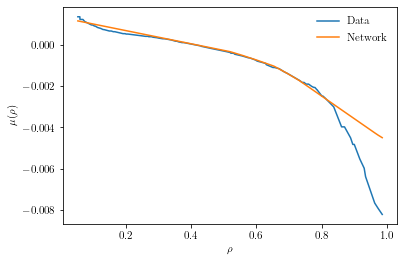

 12%|█▏        | 599/5000 [00:02<00:20, 211.68it/s]

0.029311275109648705


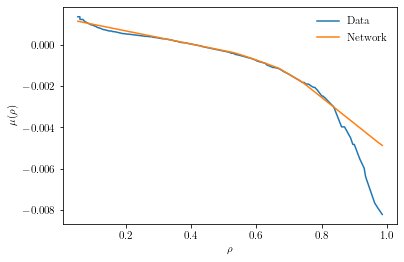

 13%|█▎        | 645/5000 [00:03<00:27, 157.05it/s]

0.024855999276041985


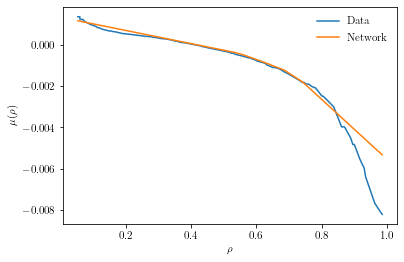

 15%|█▌        | 760/5000 [00:03<00:23, 183.66it/s]

0.02364836446940899


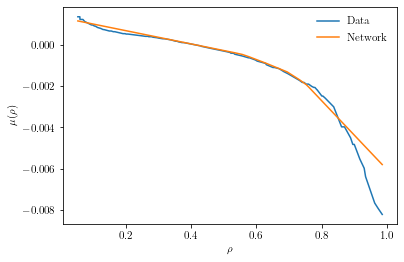

 17%|█▋        | 874/5000 [00:04<00:20, 201.14it/s]

0.020038137212395668


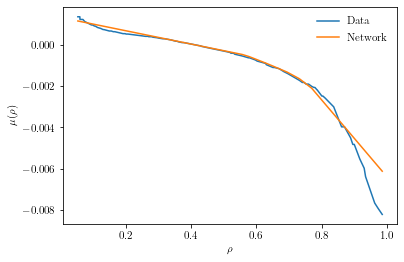

 19%|█▉        | 974/5000 [00:04<00:18, 214.63it/s]

0.01715768873691559


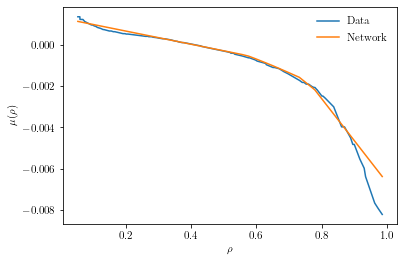

 20%|██        | 1015/5000 [00:04<00:23, 170.70it/s]

0.016956107690930367


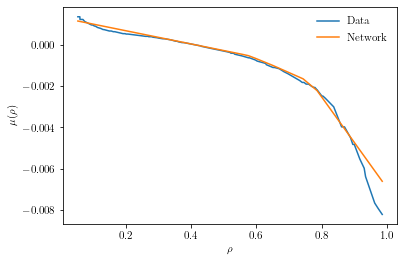

 24%|██▍       | 1189/5000 [00:05<00:15, 239.62it/s]

0.013506350107491016


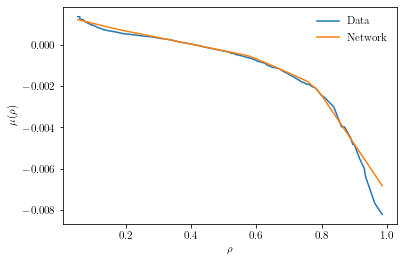

 25%|██▍       | 1236/5000 [00:05<00:21, 172.92it/s]

0.013230052776634693


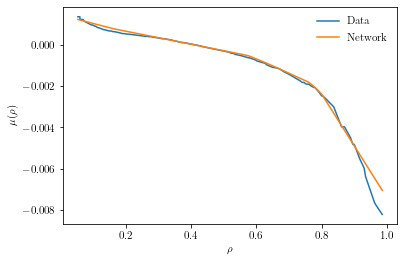

 28%|██▊       | 1379/5000 [00:06<00:16, 224.20it/s]

0.012991015799343586


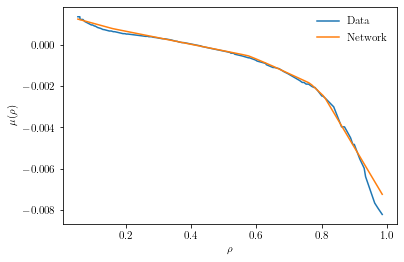

 28%|██▊       | 1424/5000 [00:06<00:19, 185.65it/s]

0.013351377099752426


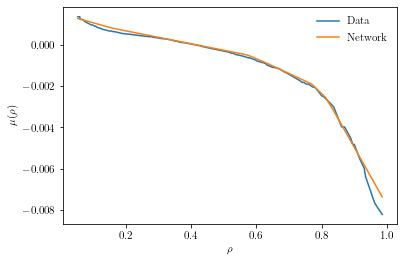

 32%|███▏      | 1577/5000 [00:07<00:13, 247.50it/s]

0.011954231187701225


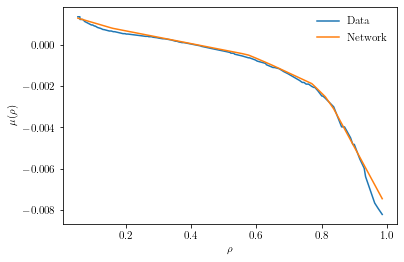

 34%|███▎      | 1684/5000 [00:07<00:14, 225.76it/s]

0.010847900062799454


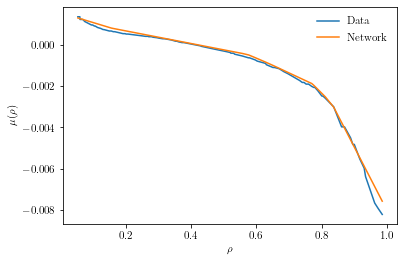

 35%|███▍      | 1727/5000 [00:08<00:18, 180.83it/s]

0.00905962847173214


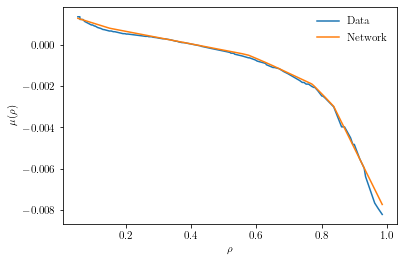

 37%|███▋      | 1870/5000 [00:08<00:13, 235.50it/s]

0.006762698758393526


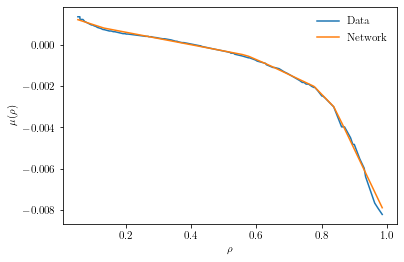

 40%|███▉      | 1987/5000 [00:08<00:12, 241.68it/s]

0.009442017413675785


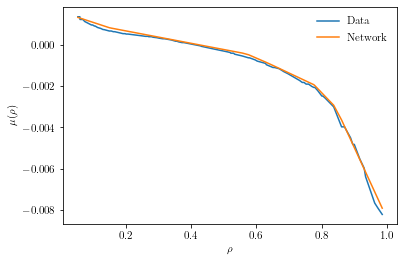

 41%|████      | 2033/5000 [00:09<00:15, 186.54it/s]

0.008790334686636925


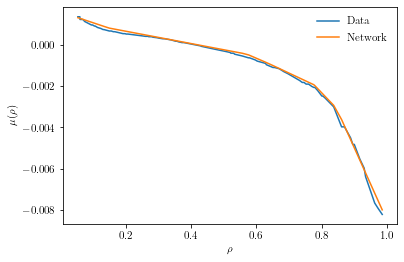

 43%|████▎     | 2162/5000 [00:10<00:14, 191.01it/s]

0.008317717351019382


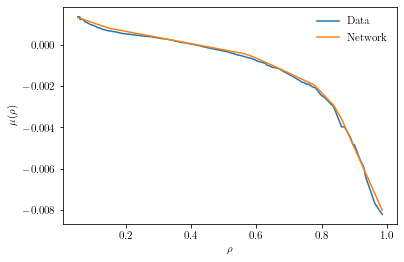

 45%|████▌     | 2269/5000 [00:10<00:13, 195.58it/s]

0.0058821565471589565


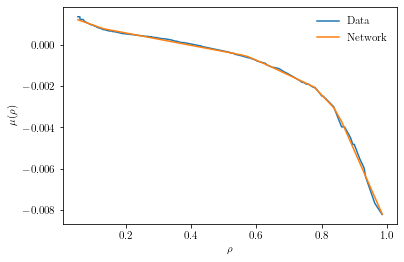

 48%|████▊     | 2390/5000 [00:11<00:11, 217.84it/s]

0.010253307409584522


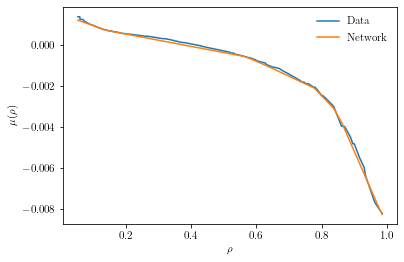

 49%|████▊     | 2437/5000 [00:11<00:14, 182.75it/s]

0.00944153405725956


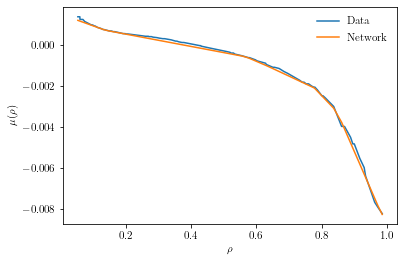

 52%|█████▏    | 2580/5000 [00:11<00:10, 234.02it/s]

0.009309540502727032


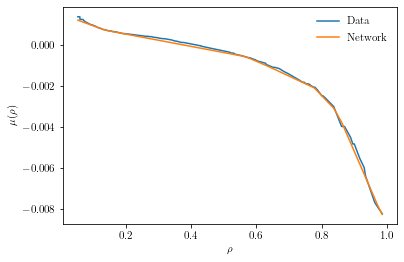

 53%|█████▎    | 2626/5000 [00:12<00:12, 184.77it/s]

0.009299036115407944


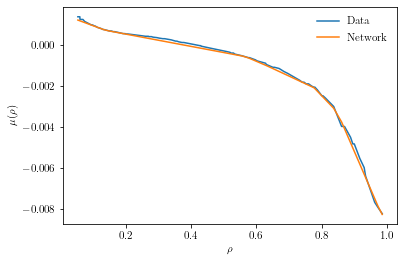

 55%|█████▌    | 2756/5000 [00:12<00:09, 226.86it/s]

0.00732985557988286


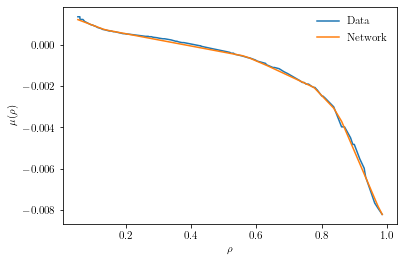

 58%|█████▊    | 2881/5000 [00:13<00:08, 242.47it/s]

0.009887080639600754


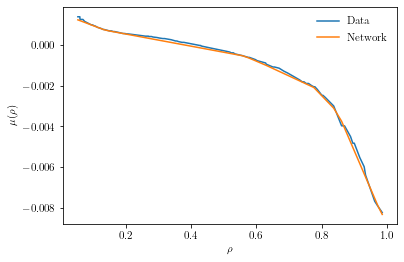

 59%|█████▊    | 2927/5000 [00:13<00:12, 170.92it/s]

0.009313392452895641


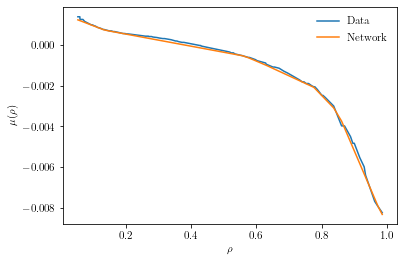

 62%|██████▏   | 3079/5000 [00:14<00:08, 229.14it/s]

0.009732894599437714


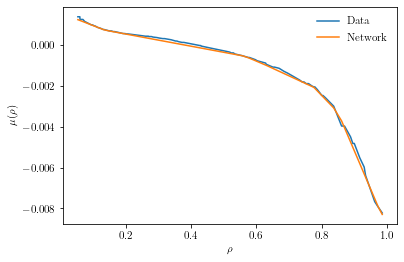

 64%|██████▎   | 3176/5000 [00:14<00:08, 208.13it/s]

0.009276851080358028


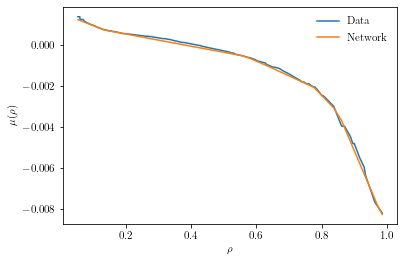

 66%|██████▌   | 3276/5000 [00:15<00:08, 209.00it/s]

0.0087769515812397


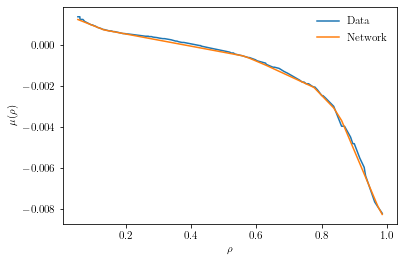

 67%|██████▋   | 3374/5000 [00:15<00:07, 204.41it/s]

0.009877934120595455


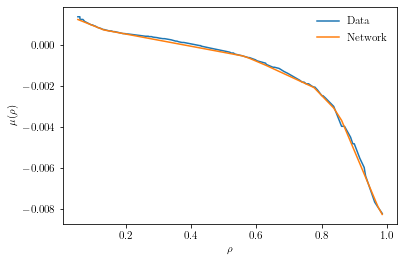

 70%|██████▉   | 3491/5000 [00:16<00:06, 218.72it/s]

0.008909737691283226


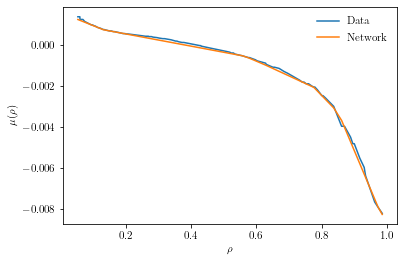

 72%|███████▏  | 3596/5000 [00:16<00:06, 218.21it/s]

0.009607554413378239


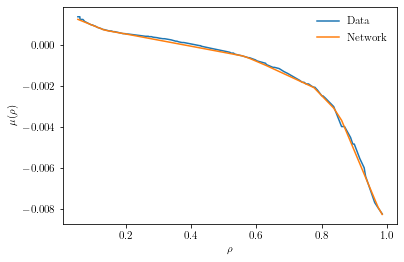

 73%|███████▎  | 3639/5000 [00:16<00:08, 159.86it/s]

0.008616792969405651


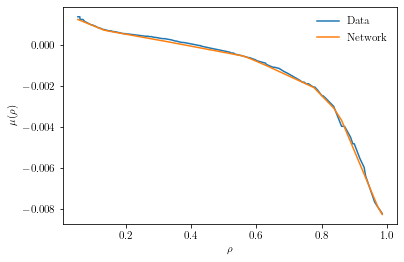

 75%|███████▌  | 3765/5000 [00:17<00:08, 152.76it/s]

0.009269511327147484


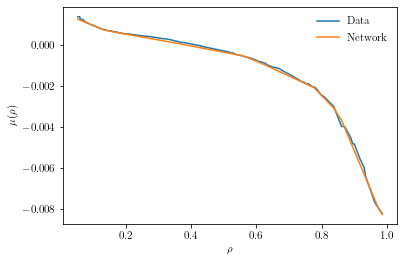

 78%|███████▊  | 3882/5000 [00:18<00:07, 157.31it/s]

0.007839019410312176


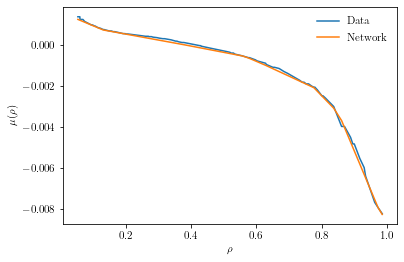

 79%|███████▊  | 3926/5000 [00:18<00:07, 139.47it/s]

0.00887538306415081


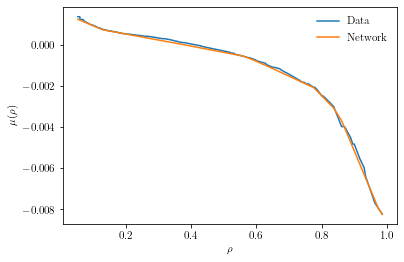

 82%|████████▏ | 4089/5000 [00:19<00:04, 202.60it/s]

0.007833060808479786


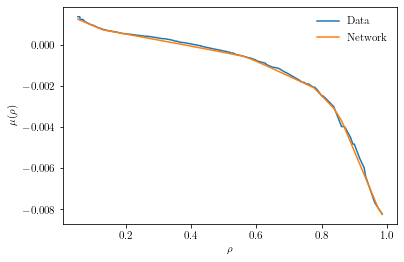

 83%|████████▎ | 4137/5000 [00:19<00:05, 165.56it/s]

0.009049109183251858


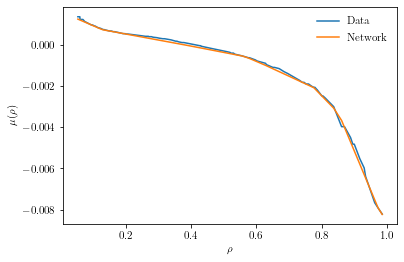

 86%|████████▌ | 4279/5000 [00:20<00:03, 202.55it/s]

0.009467310272157192


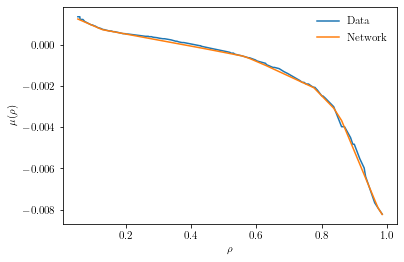

 88%|████████▊ | 4390/5000 [00:21<00:03, 163.46it/s]

0.008021430112421513


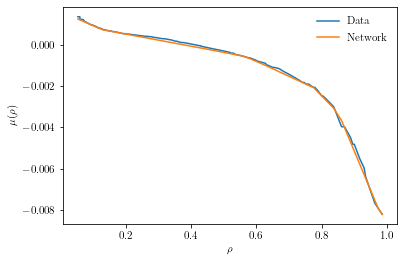

 90%|████████▉ | 4494/5000 [00:22<00:03, 134.76it/s]

0.009563240222632885


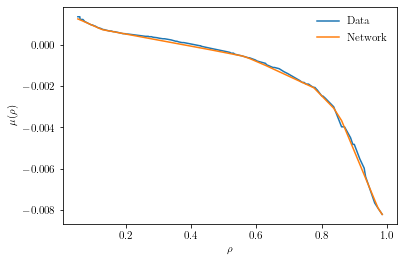

 92%|█████████▏| 4587/5000 [00:23<00:03, 126.73it/s]

0.008970489725470543


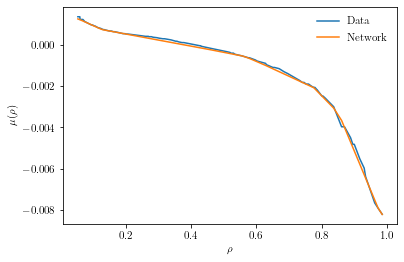

 93%|█████████▎| 4674/5000 [00:24<00:02, 111.88it/s]

0.009075202979147434


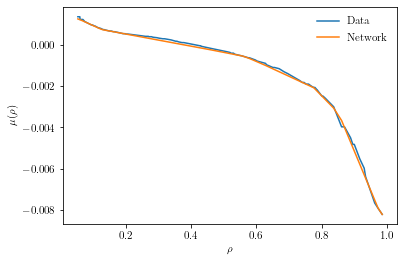

 96%|█████████▌| 4783/5000 [00:25<00:01, 117.26it/s]

0.008335761725902557


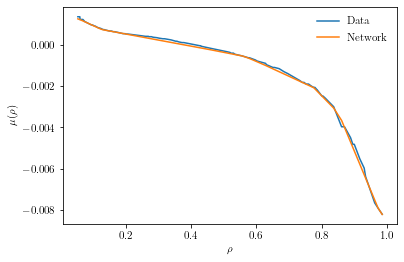

 98%|█████████▊| 4881/5000 [00:26<00:01, 118.32it/s]

0.009672781452536583


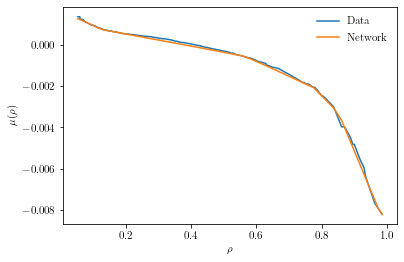

100%|█████████▉| 4978/5000 [00:27<00:00, 106.65it/s]

0.008040972985327244


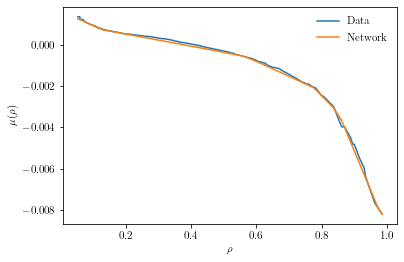

100%|██████████| 5000/5000 [00:28<00:00, 176.23it/s]


Training for model 5


  2%|▏         | 92/5000 [00:00<00:05, 919.47it/s]

0.054889559745788574


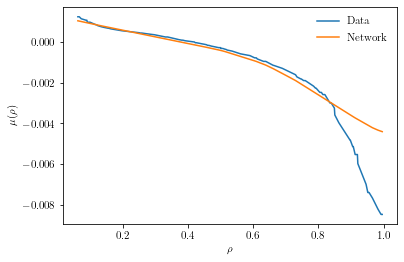

  2%|▏         | 120/5000 [00:00<00:20, 241.18it/s]

0.04375471919775009


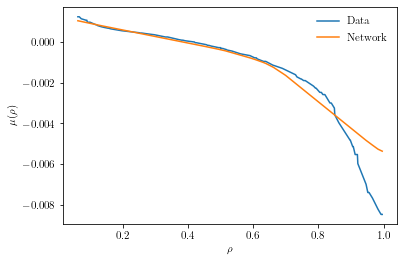

  6%|▌         | 287/5000 [00:00<00:15, 297.68it/s]

0.03630902245640755


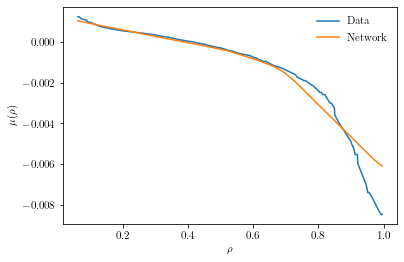

  7%|▋         | 328/5000 [00:01<00:22, 208.81it/s]

0.02885044738650322


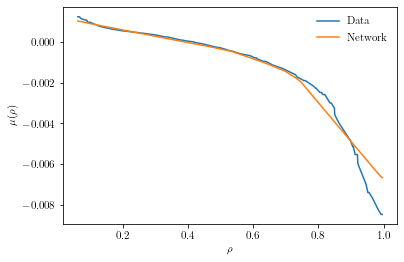

 10%|▉         | 487/5000 [00:01<00:17, 250.90it/s]

0.022985661402344704


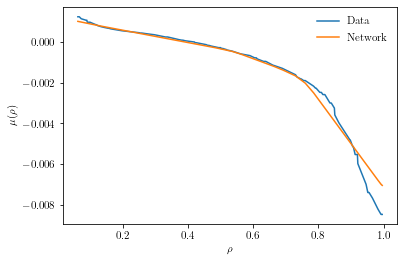

 11%|█         | 533/5000 [00:02<00:25, 174.87it/s]

0.018387848511338234


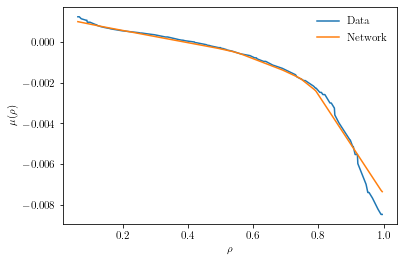

 14%|█▎        | 683/5000 [00:02<00:18, 232.86it/s]

0.015101272612810135


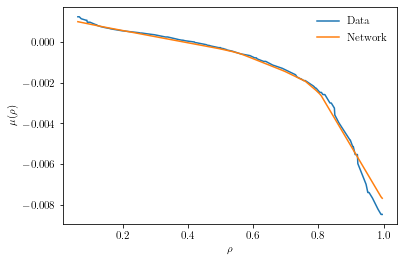

 16%|█▌        | 783/5000 [00:03<00:17, 238.04it/s]

0.012491685338318348


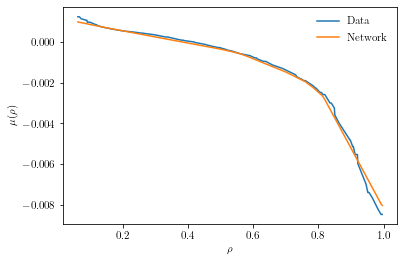

 18%|█▊        | 880/5000 [00:03<00:20, 200.46it/s]

0.009969066828489304


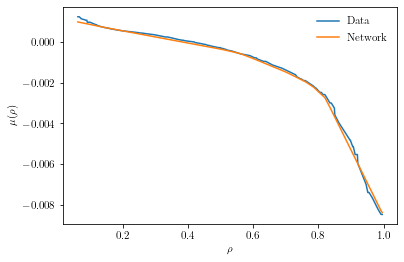

 20%|█▉        | 991/5000 [00:04<00:21, 189.97it/s]

0.008383309468626976


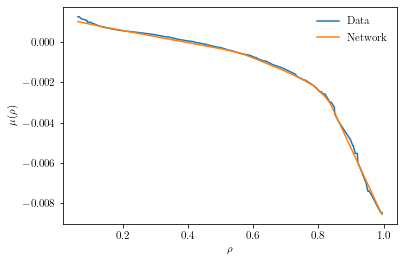

 21%|██        | 1034/5000 [00:04<00:25, 157.36it/s]

0.007984795607626438


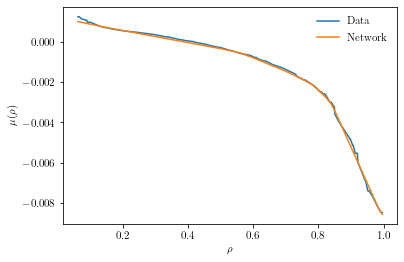

 24%|██▎       | 1184/5000 [00:05<00:18, 207.39it/s]

0.00822257436811924


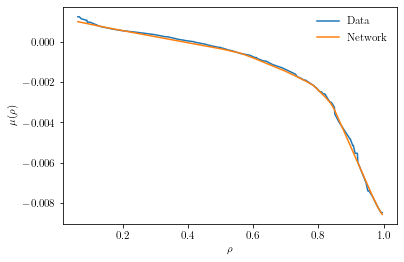

 25%|██▍       | 1229/5000 [00:05<00:23, 157.38it/s]

0.007694624830037355


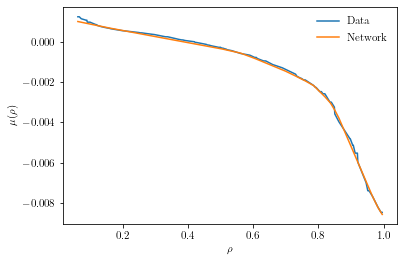

 28%|██▊       | 1389/5000 [00:06<00:16, 221.37it/s]

0.007769563235342503


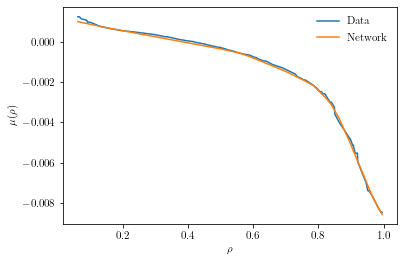

 29%|██▊       | 1437/5000 [00:06<00:20, 172.23it/s]

0.00665577407926321


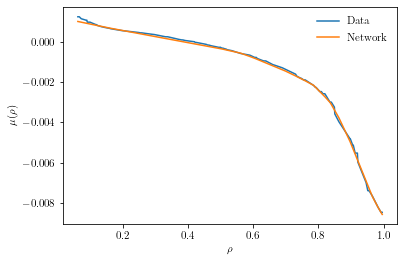

 32%|███▏      | 1586/5000 [00:06<00:15, 224.52it/s]

0.0064132120460271835


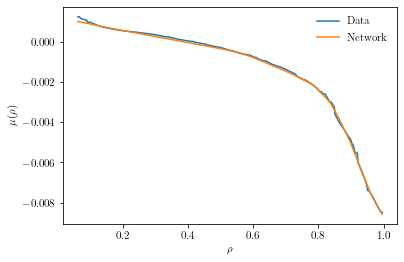

 33%|███▎      | 1634/5000 [00:07<00:17, 191.67it/s]

0.007043678779155016


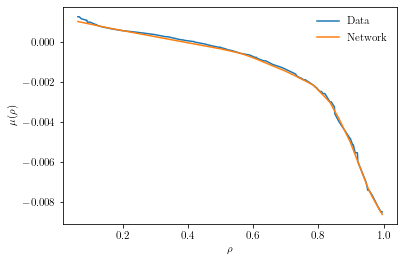

 35%|███▌      | 1771/5000 [00:07<00:15, 213.01it/s]

0.006540596950799227


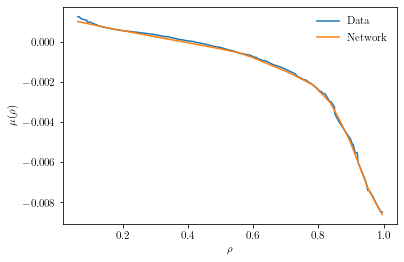

 36%|███▋      | 1814/5000 [00:08<00:22, 141.48it/s]

0.006431156303733587


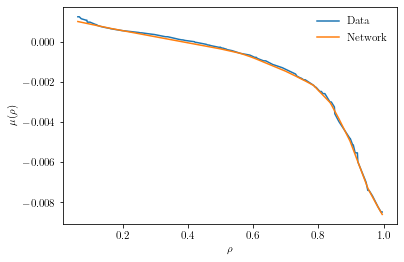

 40%|███▉      | 1986/5000 [00:08<00:14, 211.83it/s]

0.0062554036267101765


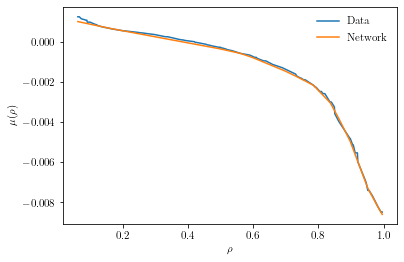

 41%|████      | 2032/5000 [00:09<00:17, 168.38it/s]

0.006520746275782585


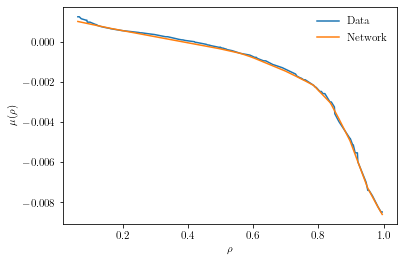

 44%|████▎     | 2182/5000 [00:09<00:12, 228.71it/s]

0.005932616535574198


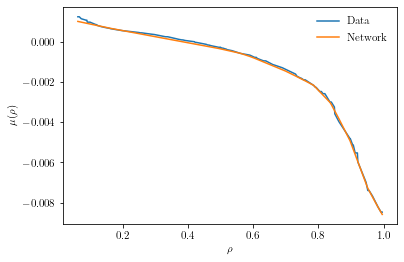

 45%|████▍     | 2228/5000 [00:10<00:15, 174.97it/s]

0.005879444070160389


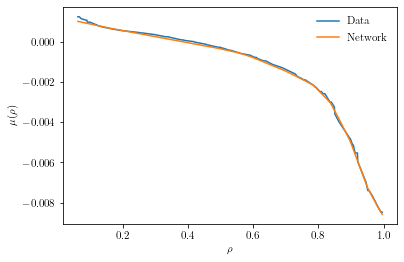

 48%|████▊     | 2384/5000 [00:10<00:11, 232.15it/s]

0.0059851049445569515


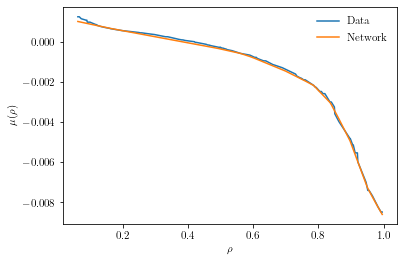

 49%|████▊     | 2431/5000 [00:11<00:13, 193.08it/s]

0.00619341479614377


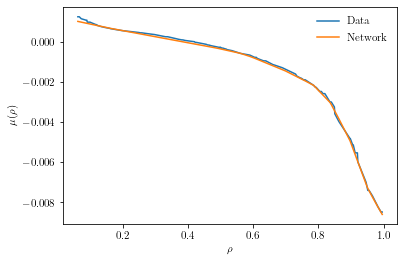

 52%|█████▏    | 2587/5000 [00:11<00:09, 253.37it/s]

0.0058159311302006245


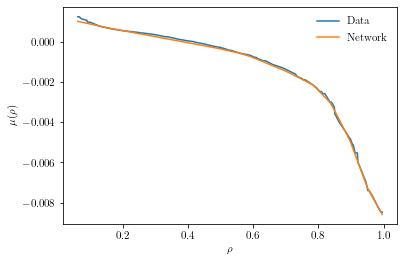

 53%|█████▎    | 2636/5000 [00:11<00:11, 206.88it/s]

0.0058384970761835575


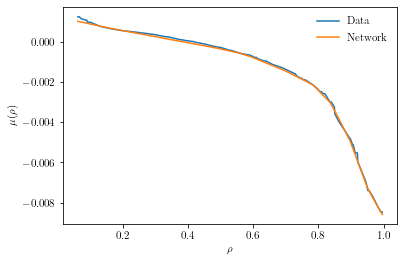

 56%|█████▌    | 2777/5000 [00:12<00:08, 248.12it/s]

0.005927442107349634


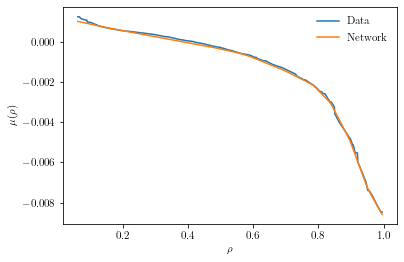

 56%|█████▋    | 2823/5000 [00:12<00:11, 196.37it/s]

0.00640830397605896


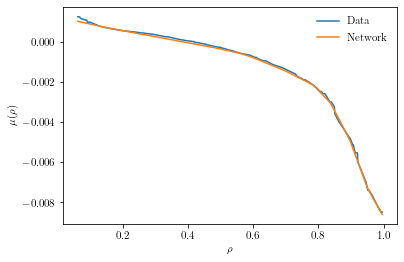

 60%|█████▉    | 2988/5000 [00:13<00:07, 260.83it/s]

0.006055011879652739


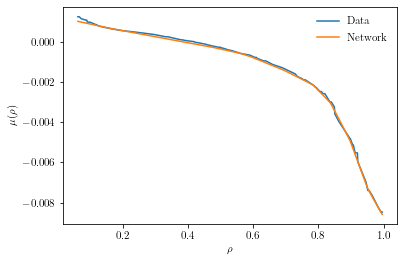

 61%|██████    | 3037/5000 [00:13<00:09, 212.91it/s]

0.006172650493681431


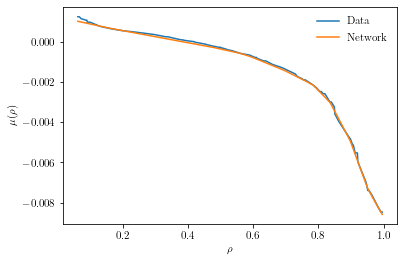

 63%|██████▎   | 3162/5000 [00:13<00:07, 236.34it/s]

0.006169606000185013


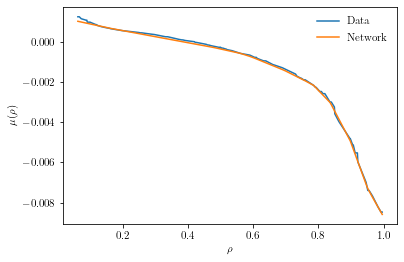

 65%|██████▌   | 3272/5000 [00:14<00:07, 223.99it/s]

0.00622453261166811


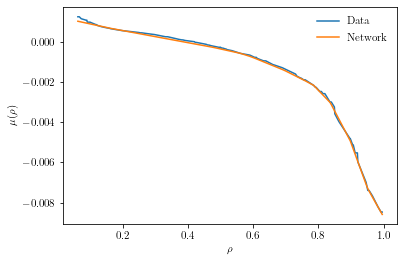

 68%|██████▊   | 3388/5000 [00:14<00:07, 225.40it/s]

0.006049342919141054


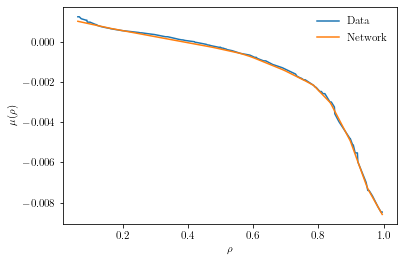

 69%|██████▊   | 3434/5000 [00:15<00:08, 178.87it/s]

0.006004808004945517


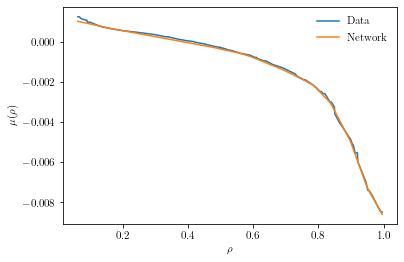

 72%|███████▏  | 3589/5000 [00:15<00:05, 239.37it/s]

0.005755094811320305


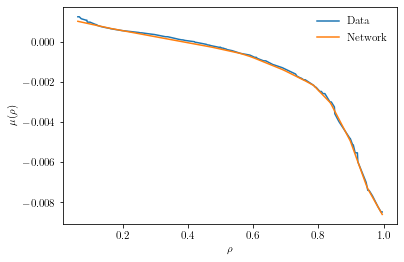

 73%|███████▎  | 3637/5000 [00:16<00:06, 198.86it/s]

0.006145481951534748


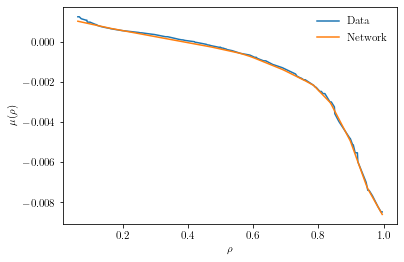

 76%|███████▌  | 3782/5000 [00:16<00:04, 248.90it/s]

0.006157299503684044


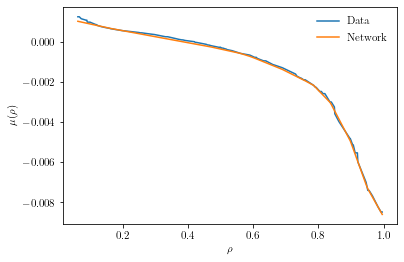

 77%|███████▋  | 3829/5000 [00:16<00:06, 184.60it/s]

0.005716420244425535


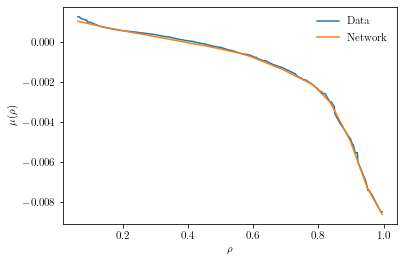

 80%|███████▉  | 3987/5000 [00:17<00:04, 242.57it/s]

0.005805575288832188


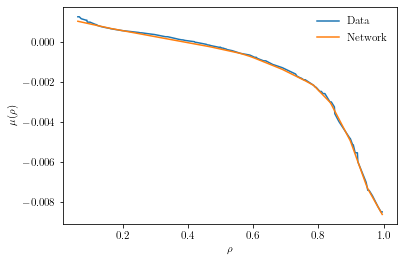

 82%|████████▏ | 4092/5000 [00:18<00:04, 198.48it/s]

0.005849254783242941


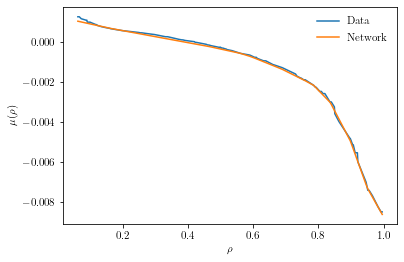

 83%|████████▎ | 4135/5000 [00:18<00:05, 168.69it/s]

0.0055617112666368484


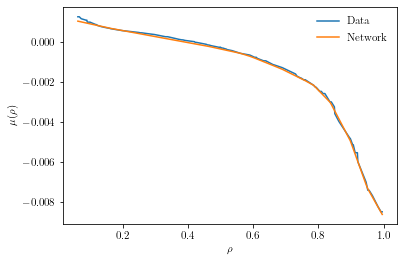

 85%|████████▌ | 4272/5000 [00:18<00:03, 212.65it/s]

0.005885445047169924


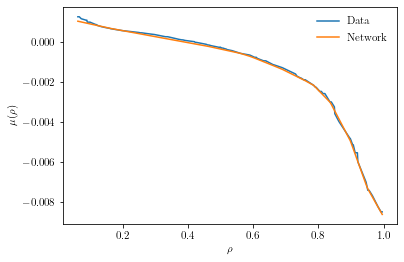

 88%|████████▊ | 4394/5000 [00:19<00:03, 197.58it/s]

0.005755500867962837


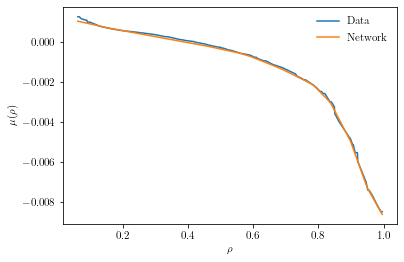

 89%|████████▉ | 4441/5000 [00:19<00:03, 162.54it/s]

0.005930789280682802


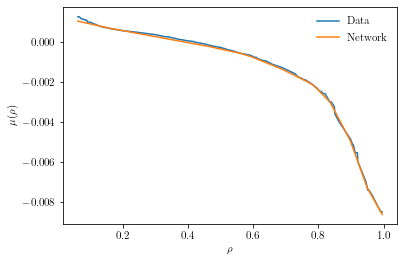

 92%|█████████▏| 4586/5000 [00:20<00:01, 216.66it/s]

0.0059400866739451885


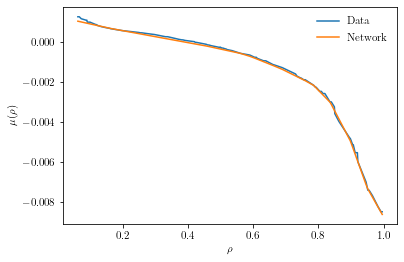

 93%|█████████▎| 4633/5000 [00:20<00:01, 184.01it/s]

0.005584786646068096


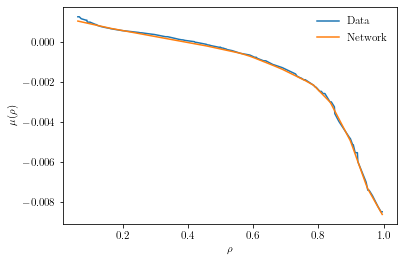

 96%|█████████▌| 4783/5000 [00:21<00:00, 239.44it/s]

0.005904155783355236


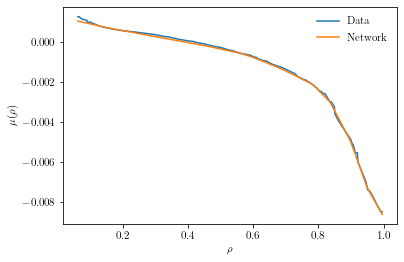

 98%|█████████▊| 4899/5000 [00:21<00:00, 246.23it/s]

0.005536131095141172


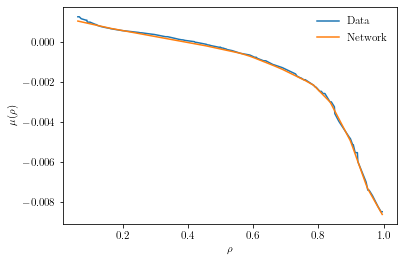

 99%|█████████▉| 4945/5000 [00:22<00:00, 170.53it/s]

0.005927748046815395


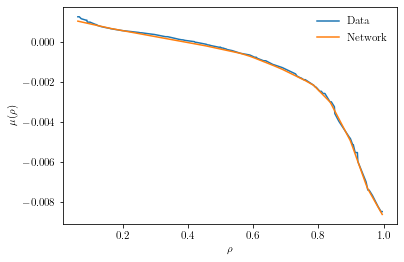

100%|██████████| 5000/5000 [00:22<00:00, 221.55it/s]


Training for model 6


  1%|          | 49/5000 [00:00<00:10, 489.04it/s]

0.052333053201436996


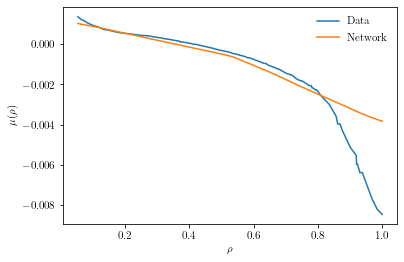

  3%|▎         | 152/5000 [00:00<00:17, 278.77it/s]

0.04311427101492882


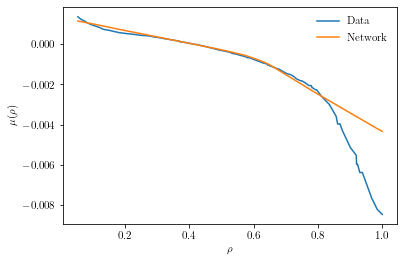

  6%|▌         | 277/5000 [00:01<00:20, 227.13it/s]

0.034225936979055405


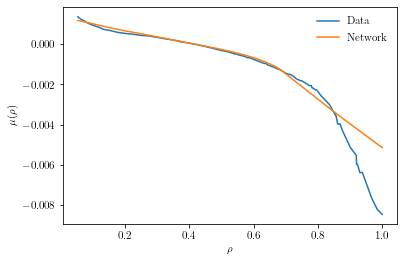

  8%|▊         | 385/5000 [00:02<00:26, 174.36it/s]

0.026227720081806183


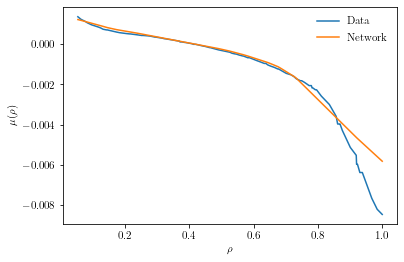

  8%|▊         | 424/5000 [00:02<00:29, 154.57it/s]

0.018404824659228325


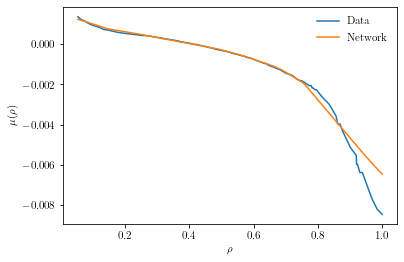

 12%|█▏        | 589/5000 [00:02<00:19, 222.25it/s]

0.016131989657878876


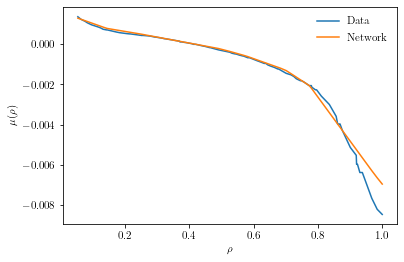

 13%|█▎        | 635/5000 [00:03<00:22, 191.63it/s]

0.012760676443576813


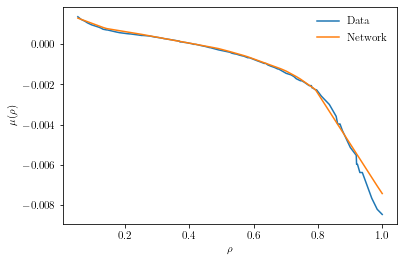

 15%|█▍        | 747/5000 [00:03<00:20, 211.43it/s]

0.009413216263055801


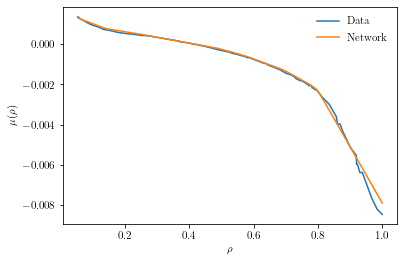

 18%|█▊        | 879/5000 [00:04<00:16, 244.24it/s]

0.007798819337040186


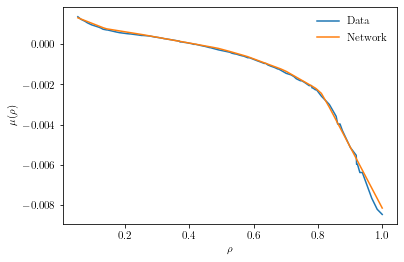

 20%|█▉        | 995/5000 [00:04<00:17, 226.60it/s]

0.006757198367267847


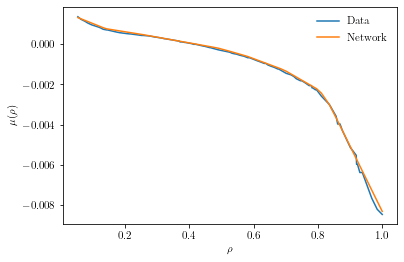

 21%|██        | 1040/5000 [00:05<00:27, 142.11it/s]

0.006271280813962221


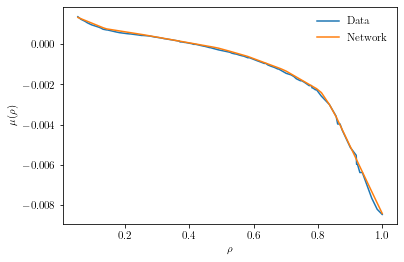

 24%|██▎       | 1184/5000 [00:05<00:19, 195.35it/s]

0.0057764514349401


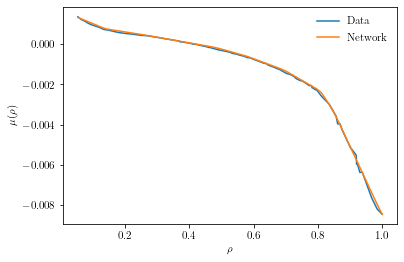

 26%|██▌       | 1291/5000 [00:06<00:17, 206.06it/s]

0.005973713472485542


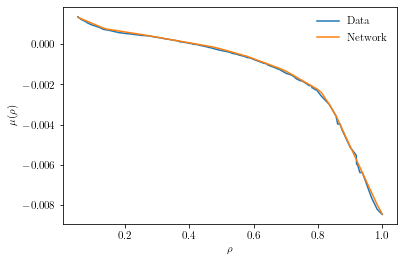

 27%|██▋       | 1334/5000 [00:06<00:22, 166.48it/s]

0.006194014102220535


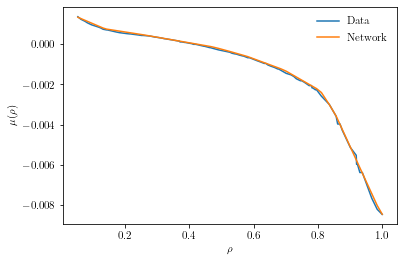

 30%|██▉       | 1486/5000 [00:07<00:15, 227.75it/s]

0.006108647678047419


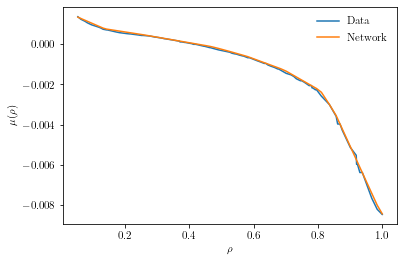

 31%|███       | 1533/5000 [00:07<00:17, 193.39it/s]

0.00588948605582118


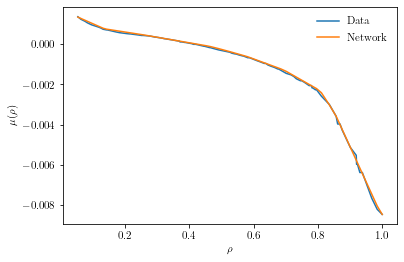

 34%|███▍      | 1689/5000 [00:07<00:13, 252.72it/s]

0.0059728799387812614


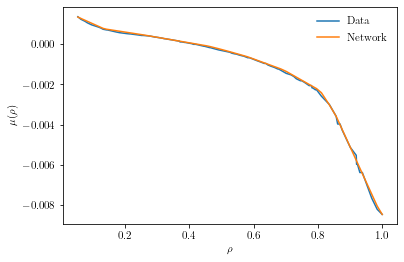

 35%|███▍      | 1738/5000 [00:08<00:15, 211.39it/s]

0.005968702025711536


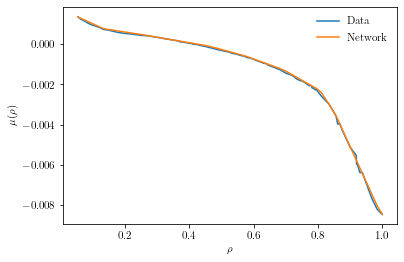

 38%|███▊      | 1886/5000 [00:08<00:11, 263.58it/s]

0.005803481210023165


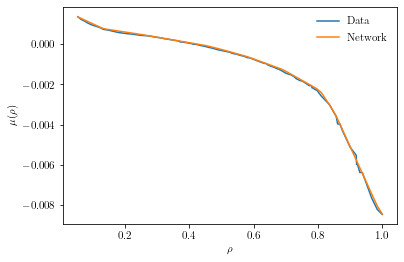

 39%|███▊      | 1935/5000 [00:08<00:14, 214.35it/s]

0.005914556793868542


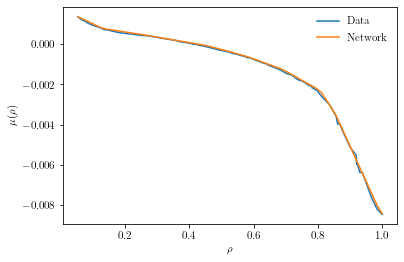

 42%|████▏     | 2076/5000 [00:09<00:11, 245.80it/s]

0.005673789884895086


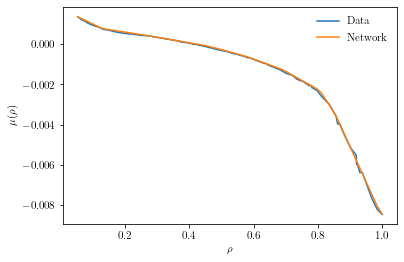

 44%|████▍     | 2198/5000 [00:09<00:11, 239.10it/s]

0.0056455861777067184


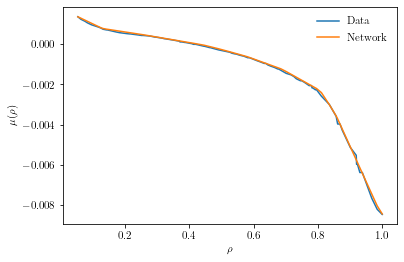

 45%|████▍     | 2246/5000 [00:10<00:14, 191.51it/s]

0.005865444429218769


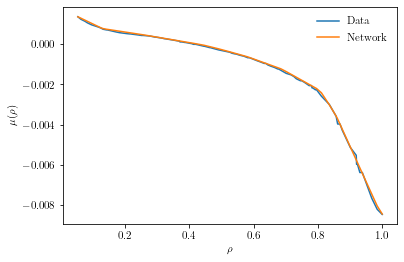

 48%|████▊     | 2382/5000 [00:10<00:11, 225.10it/s]

0.005665491800755262


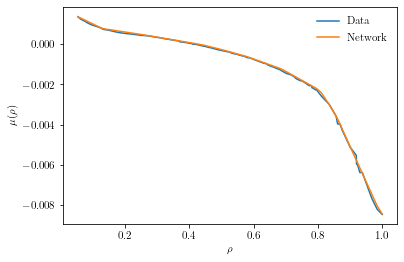

 48%|████▊     | 2417/5000 [00:11<00:16, 153.54it/s]

0.005576836410909891


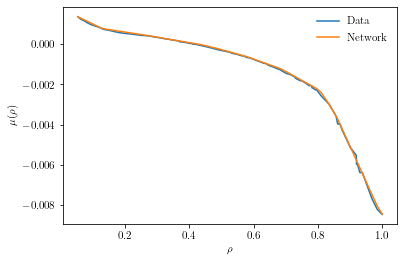

 52%|█████▏    | 2586/5000 [00:11<00:10, 222.88it/s]

0.005809633061289787


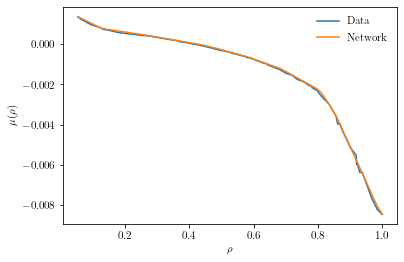

 53%|█████▎    | 2630/5000 [00:12<00:12, 184.15it/s]

0.005792765412479639


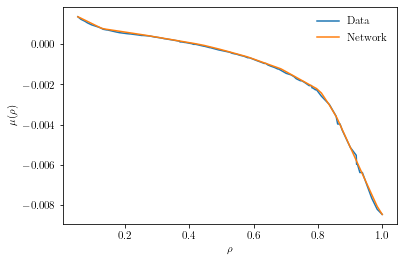

 56%|█████▌    | 2781/5000 [00:12<00:09, 244.95it/s]

0.005781716667115688


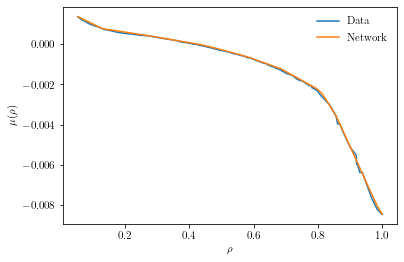

 57%|█████▋    | 2827/5000 [00:12<00:10, 199.64it/s]

0.005759879481047392


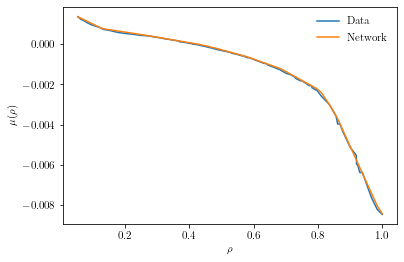

 60%|█████▉    | 2989/5000 [00:13<00:07, 262.40it/s]

0.006179737858474255


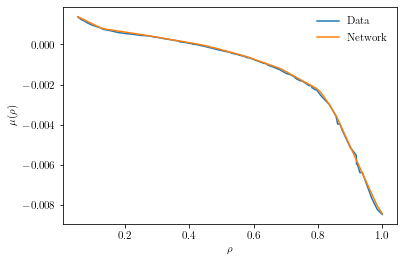

 61%|██████    | 3038/5000 [00:13<00:09, 212.91it/s]

0.005957187619060278


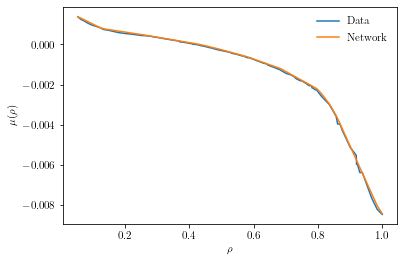

 63%|██████▎   | 3131/5000 [00:14<00:10, 184.68it/s]

0.005604104604572058


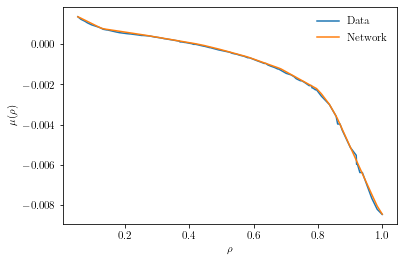

 66%|██████▌   | 3285/5000 [00:14<00:07, 237.16it/s]

0.005675415974110365


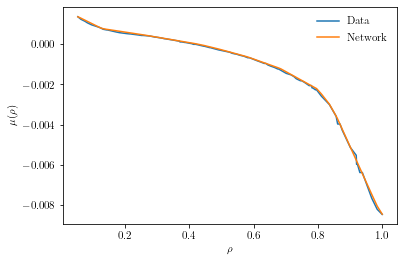

 67%|██████▋   | 3328/5000 [00:15<00:10, 160.48it/s]

0.005156371742486954


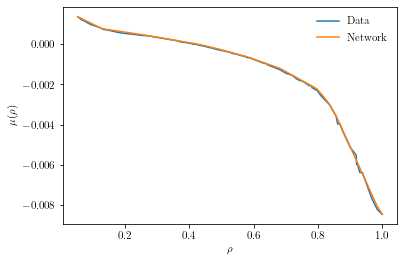

 69%|██████▉   | 3472/5000 [00:15<00:07, 217.54it/s]

0.005323884543031454


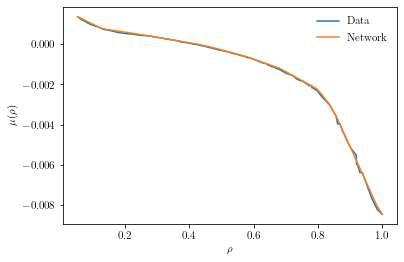

 72%|███████▏  | 3594/5000 [00:16<00:06, 232.94it/s]

0.004983747377991676


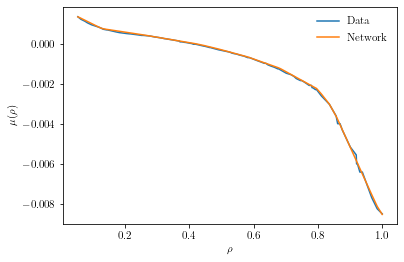

 73%|███████▎  | 3641/5000 [00:16<00:07, 185.48it/s]

0.005220615770667791


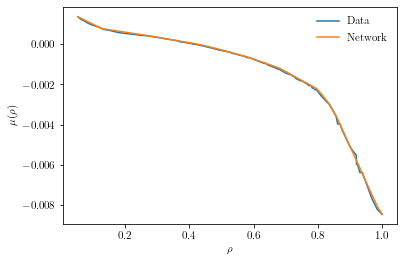

 76%|███████▌  | 3779/5000 [00:17<00:05, 232.56it/s]

0.00582180917263031


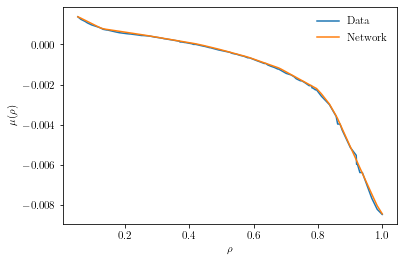

 76%|███████▋  | 3824/5000 [00:17<00:06, 188.17it/s]

0.005922737531363964


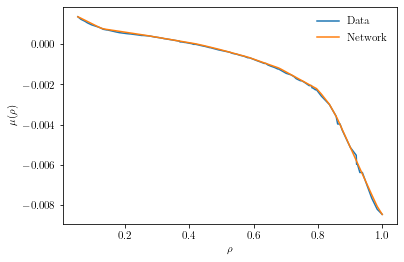

 79%|███████▉  | 3972/5000 [00:17<00:04, 238.62it/s]

0.005806629545986652


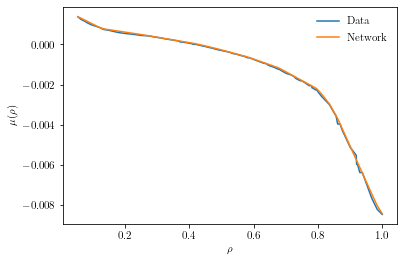

 82%|████████▏ | 4099/5000 [00:18<00:03, 240.53it/s]

0.005866141524165869


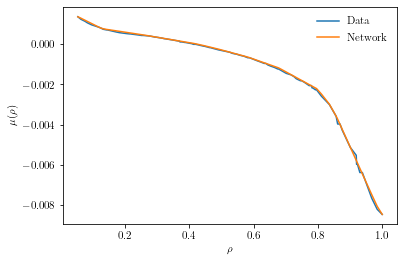

 83%|████████▎ | 4148/5000 [00:18<00:04, 199.39it/s]

0.005846153479069471


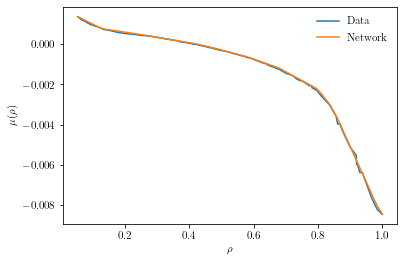

 86%|████████▌ | 4277/5000 [00:19<00:03, 238.09it/s]

0.006011060439050198


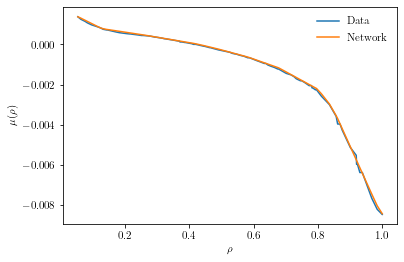

 86%|████████▋ | 4322/5000 [00:19<00:03, 195.59it/s]

0.005791853182017803


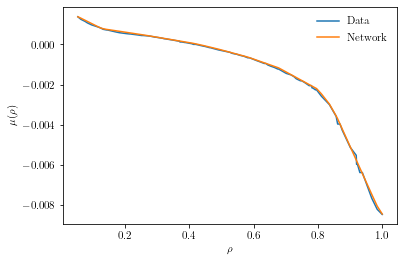

 89%|████████▉ | 4467/5000 [00:20<00:02, 251.86it/s]

0.005794330965727568


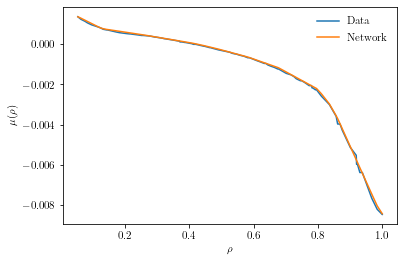

 92%|█████████▏| 4585/5000 [00:20<00:01, 240.49it/s]

0.005701311398297548


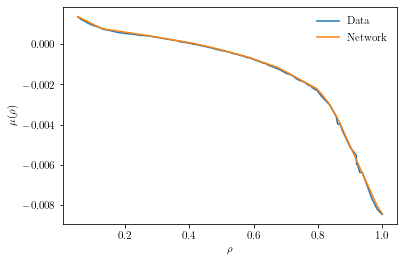

 94%|█████████▍| 4688/5000 [00:21<00:01, 209.80it/s]

0.0056426506489515305


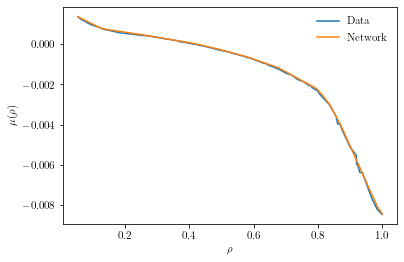

 95%|█████████▍| 4730/5000 [00:21<00:01, 171.72it/s]

0.005674424581229687


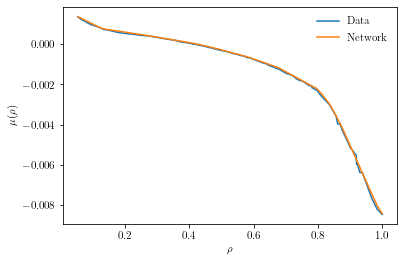

 98%|█████████▊| 4884/5000 [00:21<00:00, 233.61it/s]

0.005358059890568256


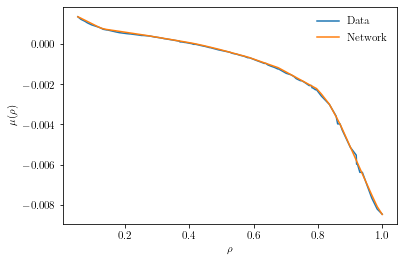

 99%|█████████▊| 4929/5000 [00:22<00:00, 189.19it/s]

0.004293510224670172


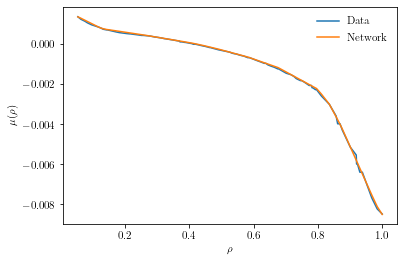

100%|██████████| 5000/5000 [00:22<00:00, 221.48it/s]


Training for model 7


  2%|▏         | 93/5000 [00:00<00:05, 923.76it/s]

0.04990015923976898


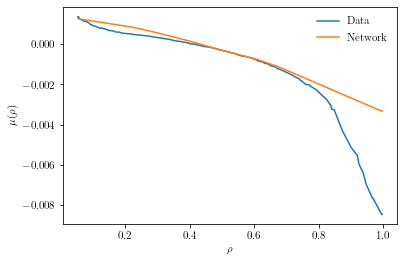

  2%|▏         | 121/5000 [00:00<00:20, 234.74it/s]

0.040321312844753265


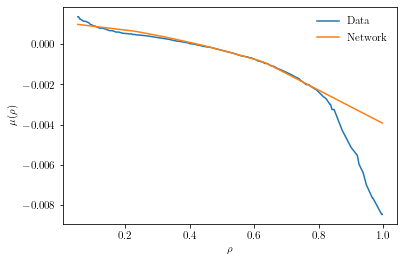

  6%|▌         | 286/5000 [00:00<00:16, 293.61it/s]

0.039892226457595825


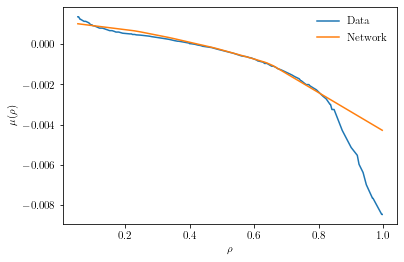

  8%|▊         | 378/5000 [00:01<00:17, 258.55it/s]

0.03552659600973129


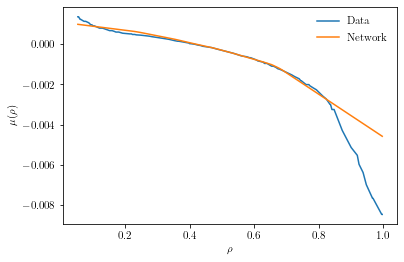

 10%|▉         | 484/5000 [00:01<00:18, 241.20it/s]

0.034232255071401596


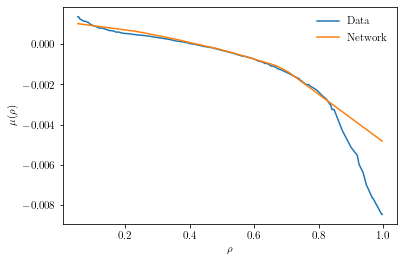

 11%|█         | 526/5000 [00:02<00:31, 141.88it/s]

0.031938452273607254


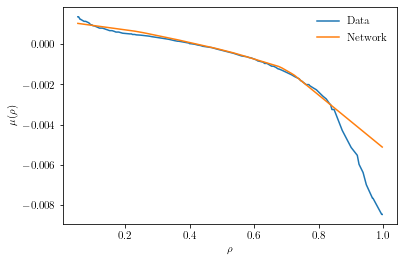

 14%|█▎        | 675/5000 [00:02<00:21, 197.67it/s]

0.030187420547008514


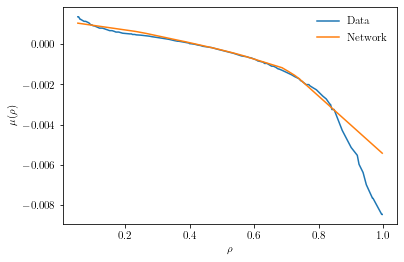

 14%|█▍        | 717/5000 [00:03<00:25, 168.06it/s]

0.028097644448280334


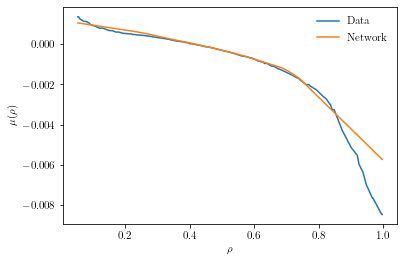

 18%|█▊        | 879/5000 [00:03<00:17, 234.47it/s]

0.026305852457880974


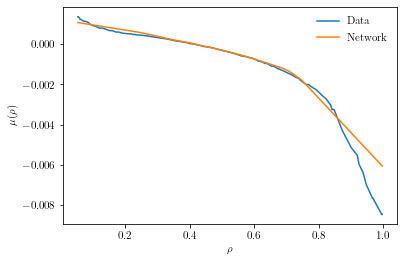

 18%|█▊        | 924/5000 [00:04<00:24, 166.64it/s]

0.02451302297413349


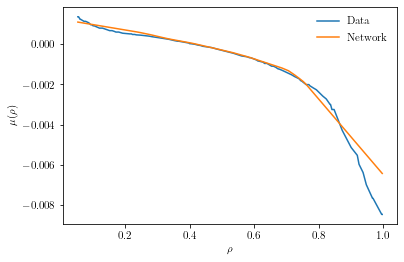

 22%|██▏       | 1078/5000 [00:04<00:17, 226.42it/s]

0.022373028099536896


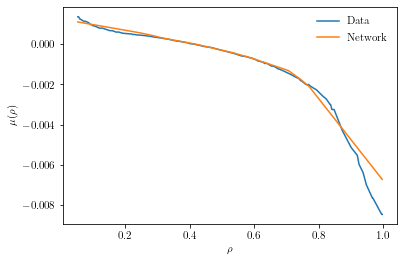

 24%|██▍       | 1194/5000 [00:05<00:16, 223.90it/s]

0.01953684352338314


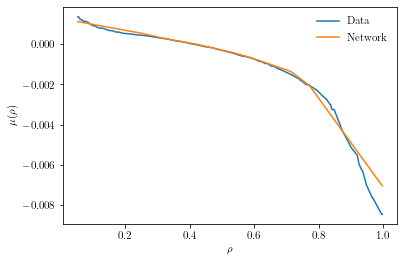

 25%|██▍       | 1240/5000 [00:05<00:20, 180.85it/s]

0.0170951709151268


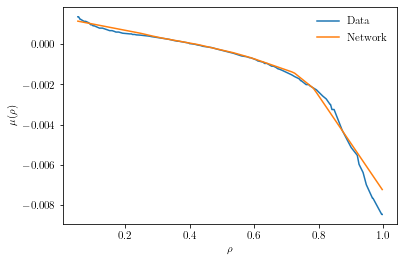

 28%|██▊       | 1391/5000 [00:06<00:15, 227.10it/s]

0.01610562577843666


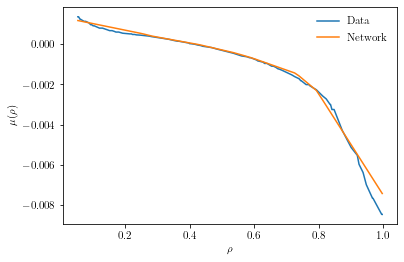

 29%|██▊       | 1428/5000 [00:06<00:21, 167.23it/s]

0.016148386523127556


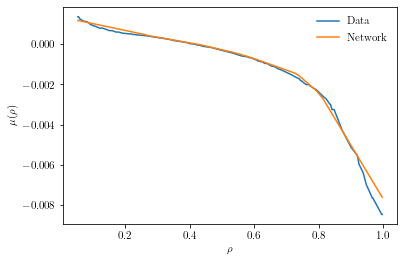

 32%|███▏      | 1582/5000 [00:07<00:15, 227.48it/s]

0.014230554923415184


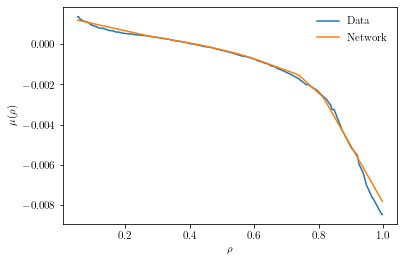

 32%|███▎      | 1625/5000 [00:07<00:18, 183.55it/s]

0.011117029935121536


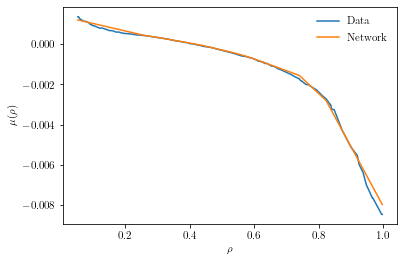

 36%|███▌      | 1779/5000 [00:07<00:13, 245.07it/s]

0.013184032402932644


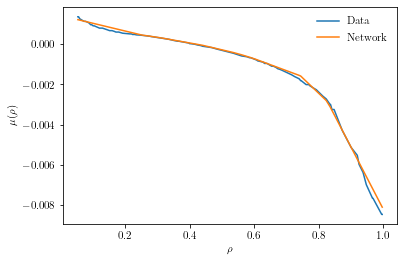

 36%|███▋      | 1824/5000 [00:08<00:16, 197.93it/s]

0.012675737030804157


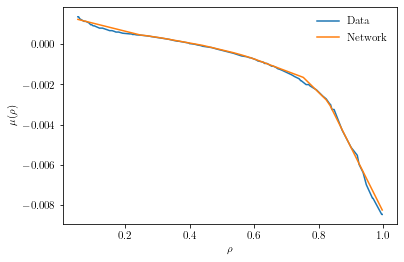

 40%|███▉      | 1989/5000 [00:08<00:11, 260.88it/s]

0.012000002898275852


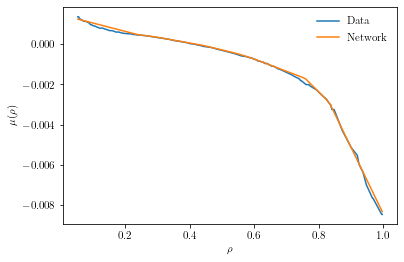

 41%|████      | 2038/5000 [00:09<00:14, 208.22it/s]

0.010735636577010155


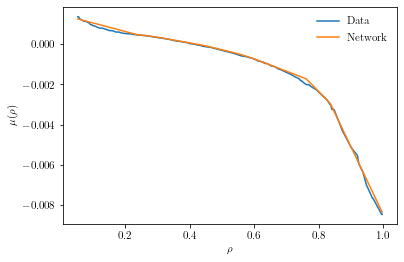

 43%|████▎     | 2172/5000 [00:09<00:11, 239.35it/s]

0.01160095352679491


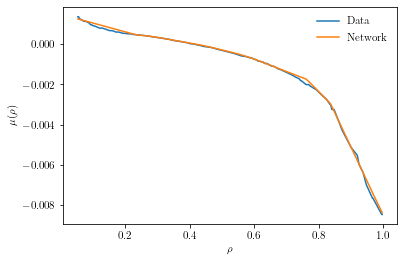

 44%|████▍     | 2216/5000 [00:10<00:20, 136.04it/s]

0.01035965047776699


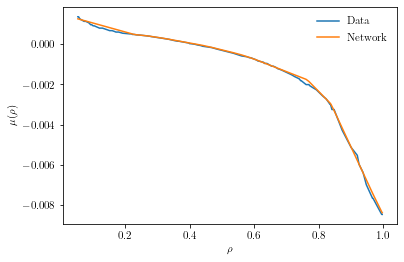

 47%|████▋     | 2367/5000 [00:10<00:13, 189.45it/s]

0.011793186888098717


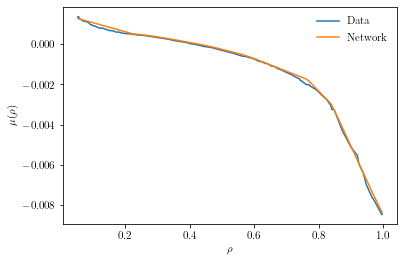

 50%|████▉     | 2483/5000 [00:11<00:12, 202.76it/s]

0.010108720511198044


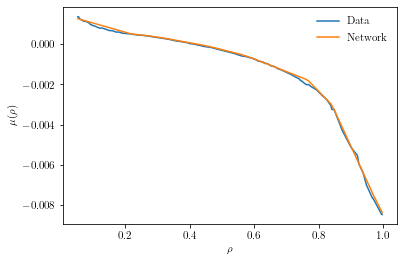

 52%|█████▏    | 2597/5000 [00:11<00:10, 218.98it/s]

0.010219225659966469


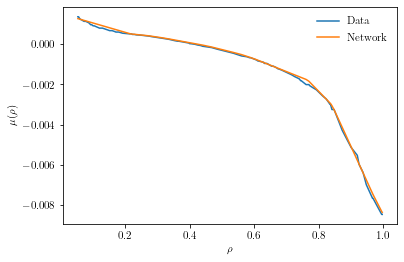

 53%|█████▎    | 2642/5000 [00:12<00:14, 159.78it/s]

0.009775824844837189


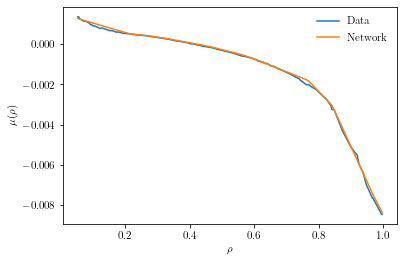

 56%|█████▌    | 2785/5000 [00:12<00:11, 196.73it/s]

0.010362628847360611


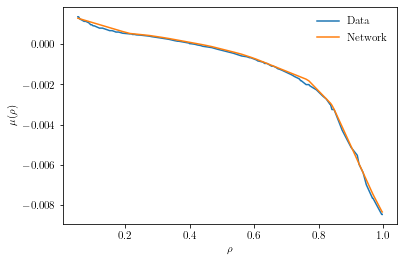

 57%|█████▋    | 2830/5000 [00:13<00:12, 167.57it/s]

0.009754875674843788


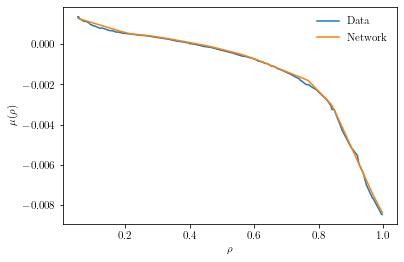

 60%|█████▉    | 2983/5000 [00:13<00:08, 227.72it/s]

0.009240459650754929


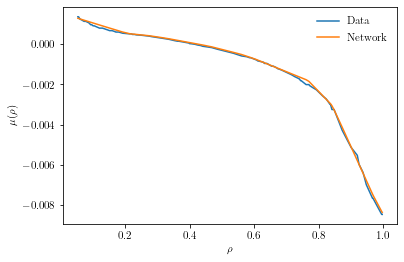

 61%|██████    | 3029/5000 [00:13<00:10, 181.21it/s]

0.009604725055396557


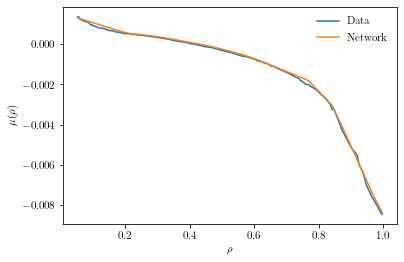

 64%|██████▎   | 3181/5000 [00:14<00:07, 235.12it/s]

0.009788261726498604


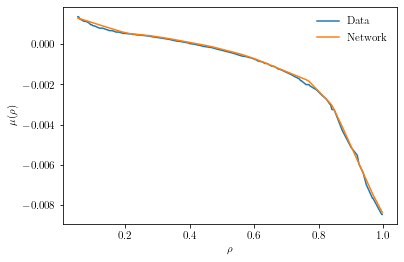

 65%|██████▍   | 3227/5000 [00:14<00:09, 183.53it/s]

0.009605427272617817


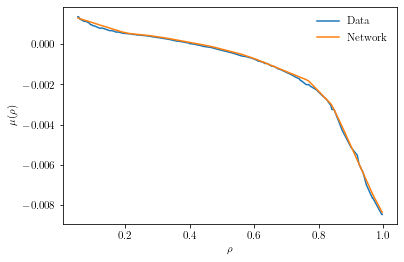

 68%|██████▊   | 3379/5000 [00:15<00:06, 236.47it/s]

0.009512084536254406


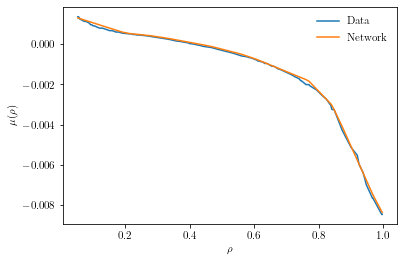

 70%|██████▉   | 3488/5000 [00:15<00:06, 242.31it/s]

0.00918674748390913


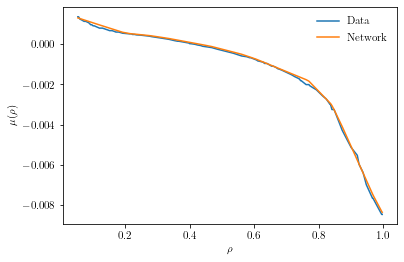

 71%|███████   | 3532/5000 [00:16<00:08, 170.59it/s]

0.009309026412665844


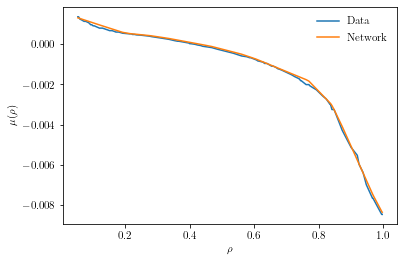

 74%|███████▎  | 3686/5000 [00:16<00:05, 228.06it/s]

0.009315538220107555


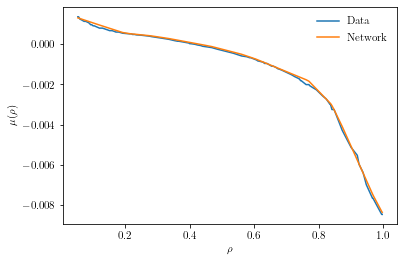

 75%|███████▍  | 3733/5000 [00:17<00:06, 189.91it/s]

0.009367930702865124


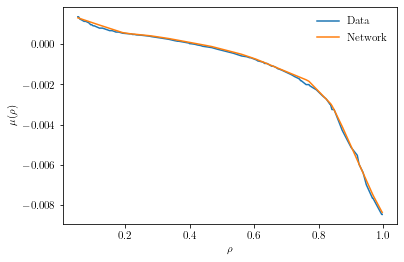

 78%|███████▊  | 3886/5000 [00:17<00:04, 249.83it/s]

0.010145523585379124


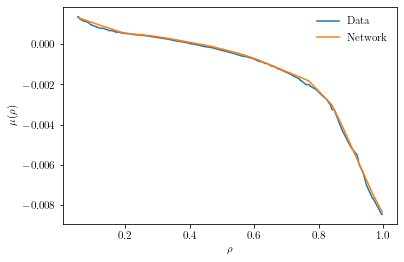

 79%|███████▊  | 3934/5000 [00:17<00:05, 205.02it/s]

0.009218204766511917


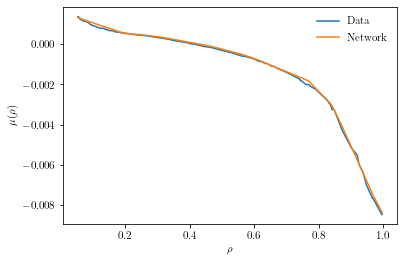

 82%|████████▏ | 4085/5000 [00:18<00:03, 259.47it/s]

0.008623752743005753


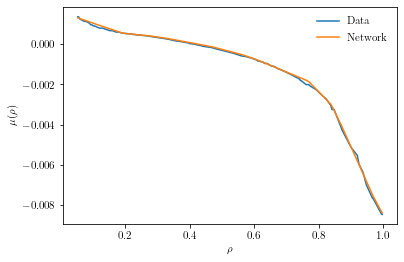

 83%|████████▎ | 4133/5000 [00:18<00:04, 210.83it/s]

0.009402355179190636


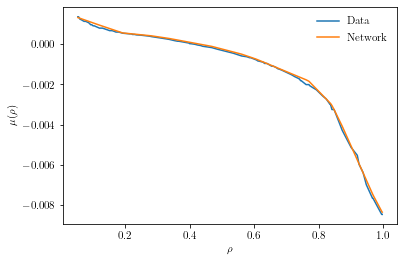

 86%|████████▌ | 4288/5000 [00:19<00:02, 265.39it/s]

0.008811288513243198


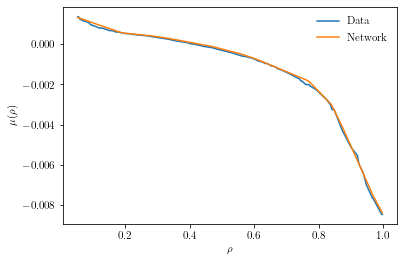

 87%|████████▋ | 4337/5000 [00:19<00:03, 213.21it/s]

0.009469227865338326


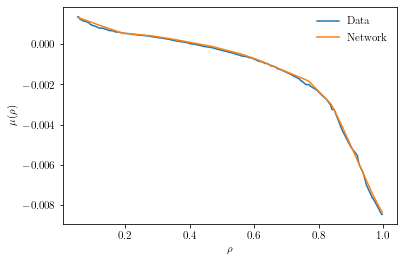

 89%|████████▉ | 4472/5000 [00:19<00:02, 255.26it/s]

0.009253880009055138


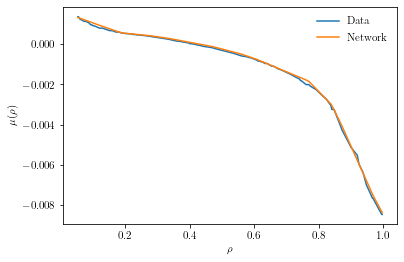

 92%|█████████▏| 4598/5000 [00:20<00:01, 243.77it/s]

0.008353528566658497


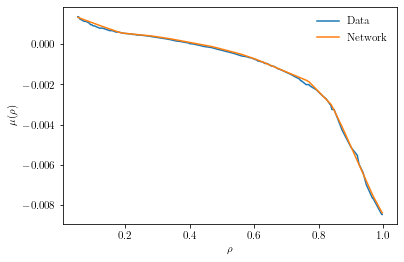

 94%|█████████▎| 4684/5000 [00:20<00:01, 203.16it/s]

0.009368205443024635


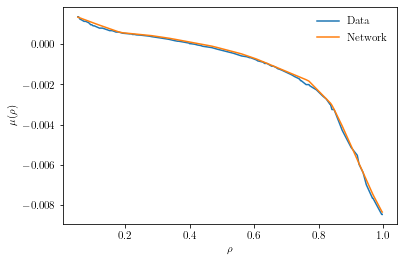

 94%|█████████▍| 4720/5000 [00:21<00:01, 146.16it/s]

0.008601164445281029


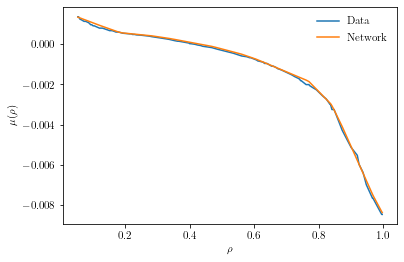

 98%|█████████▊| 4880/5000 [00:21<00:00, 205.12it/s]

0.008996411226689816


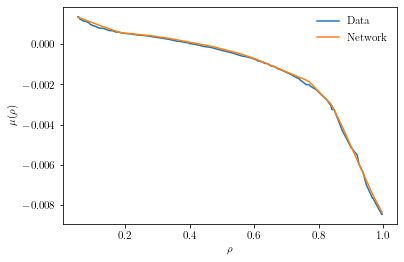

100%|█████████▉| 4995/5000 [00:22<00:00, 212.58it/s]

0.00819050706923008


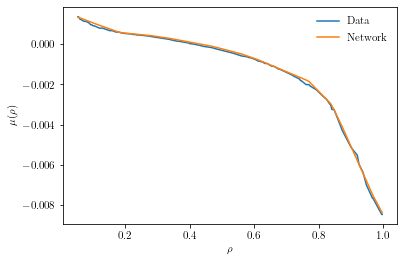

100%|██████████| 5000/5000 [00:22<00:00, 220.83it/s]


Training for model 8


  2%|▏         | 80/5000 [00:00<00:06, 794.18it/s]

0.0472874790430069


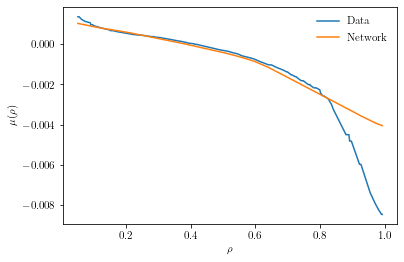

  4%|▍         | 194/5000 [00:00<00:18, 265.68it/s]

0.038685716688632965


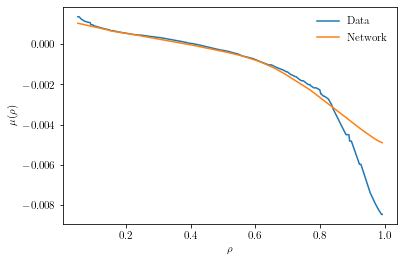

  5%|▍         | 235/5000 [00:00<00:24, 194.42it/s]

0.033327531069517136


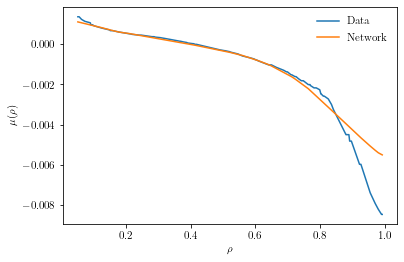

  8%|▊         | 378/5000 [00:01<00:19, 237.83it/s]

0.027567729353904724


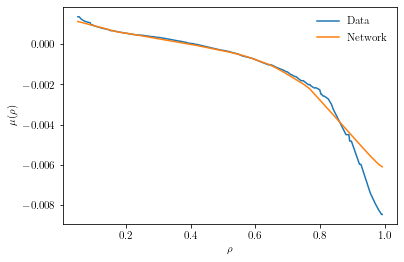

 10%|▉         | 494/5000 [00:01<00:19, 228.29it/s]

0.022099602967500687


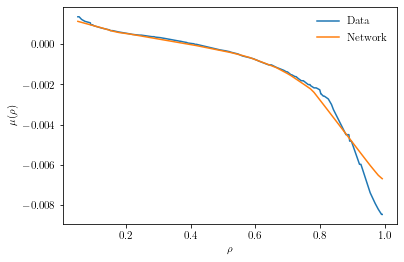

 11%|█         | 539/5000 [00:02<00:24, 185.23it/s]

0.018245719373226166


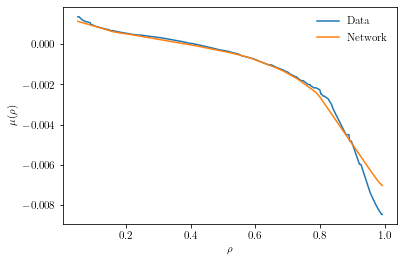

 14%|█▎        | 687/5000 [00:02<00:18, 235.28it/s]

0.017222896218299866


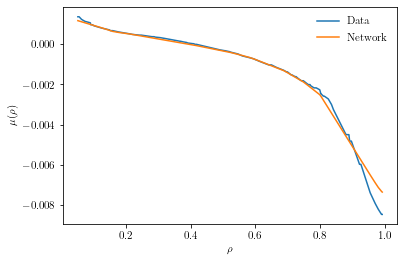

 15%|█▍        | 734/5000 [00:03<00:22, 190.25it/s]

0.0135340616106987


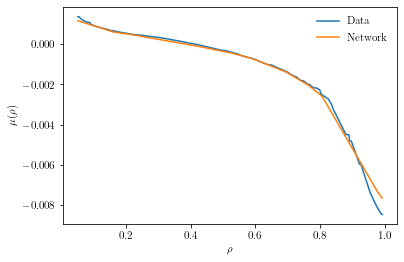

 18%|█▊        | 875/5000 [00:03<00:17, 242.22it/s]

0.014130383729934692


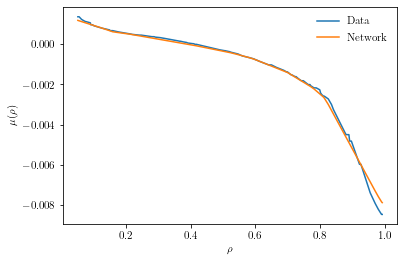

 18%|█▊        | 920/5000 [00:03<00:22, 179.57it/s]

0.011207086965441704


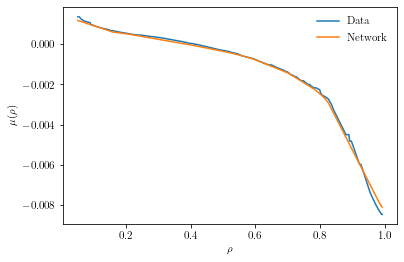

 21%|██▏       | 1063/5000 [00:04<00:17, 229.75it/s]

0.010379147715866566


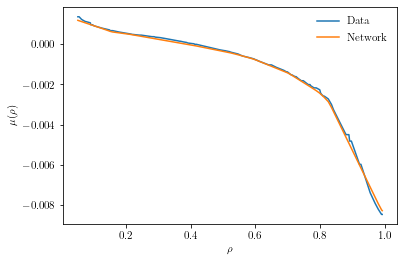

 23%|██▎       | 1150/5000 [00:05<00:24, 159.33it/s]

0.009810634888708591


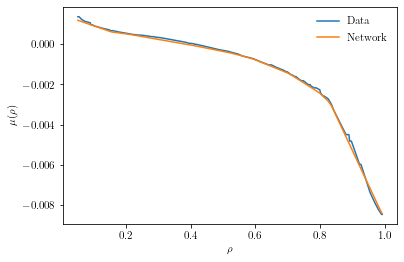

 26%|██▌       | 1278/5000 [00:05<00:21, 173.47it/s]

0.009231377393007278


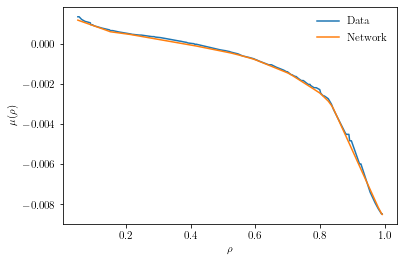

 26%|██▋       | 1320/5000 [00:06<00:26, 139.21it/s]

0.009319375269114971


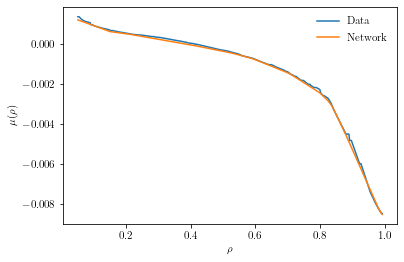

 29%|██▉       | 1461/5000 [00:06<00:18, 186.94it/s]

0.009227659553289413


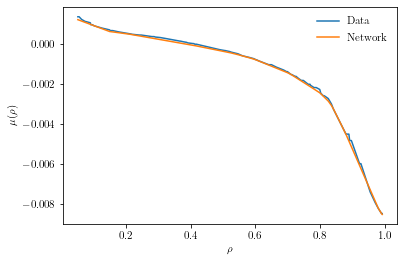

 31%|███▏      | 1572/5000 [00:07<00:16, 210.49it/s]

0.008464318700134754


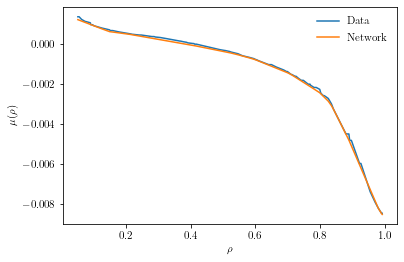

 33%|███▎      | 1667/5000 [00:07<00:17, 195.67it/s]

0.008843601681292057


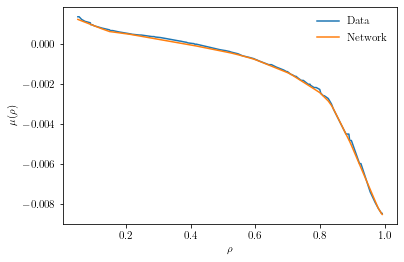

 36%|███▌      | 1790/5000 [00:08<00:15, 204.32it/s]

0.008934424258768559


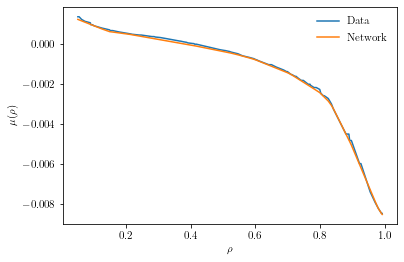

 37%|███▋      | 1836/5000 [00:08<00:18, 171.96it/s]

0.008326291106641293


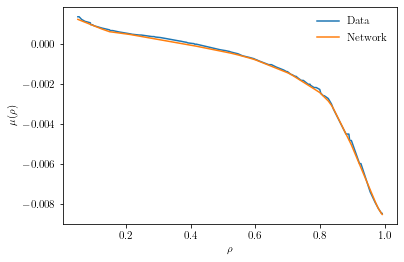

 40%|███▉      | 1975/5000 [00:09<00:13, 225.13it/s]

0.008127962239086628


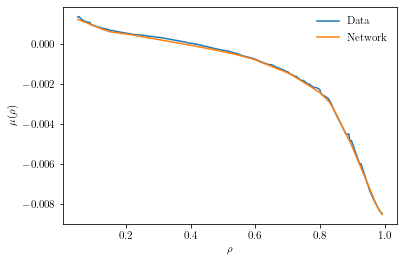

 41%|████▏     | 2074/5000 [00:10<00:17, 165.00it/s]

0.007617105729877949


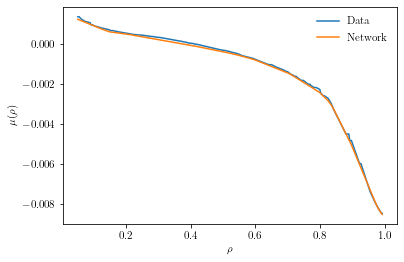

 44%|████▎     | 2183/5000 [00:10<00:19, 141.09it/s]

0.007786544971168041


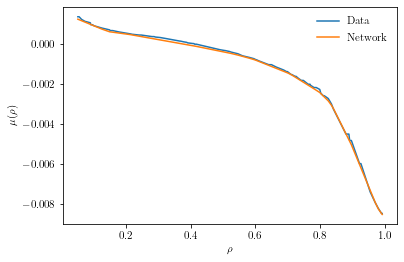

 46%|████▌     | 2297/5000 [00:11<00:15, 173.10it/s]

0.008044695481657982


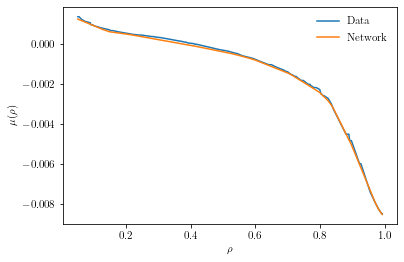

 47%|████▋     | 2342/5000 [00:11<00:16, 161.07it/s]

0.007834491319954395


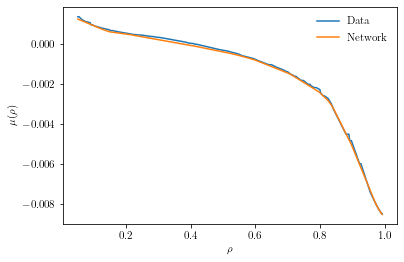

 50%|████▉     | 2488/5000 [00:12<00:12, 204.57it/s]

0.007857108488678932


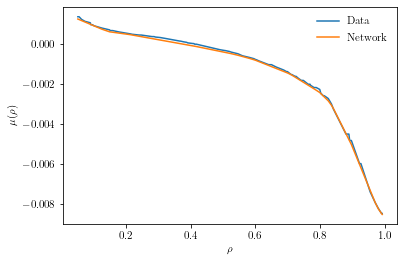

 51%|█████     | 2535/5000 [00:12<00:13, 182.18it/s]

0.007077159825712442


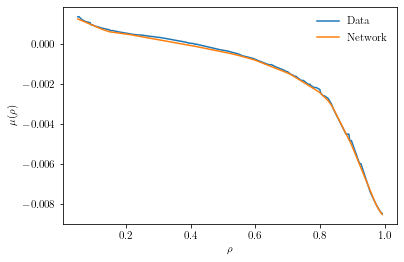

 53%|█████▎    | 2663/5000 [00:13<00:11, 198.99it/s]

0.007132146507501602


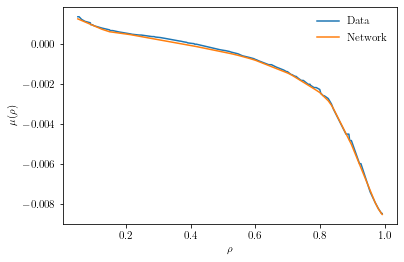

 55%|█████▌    | 2765/5000 [00:14<00:16, 138.13it/s]

0.00715874508023262


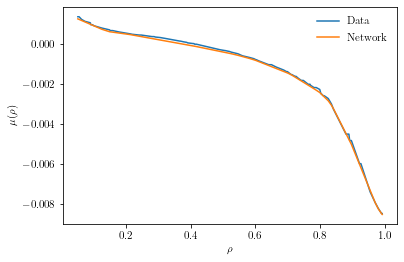

 58%|█████▊    | 2879/5000 [00:14<00:11, 189.84it/s]

0.006758685223758221


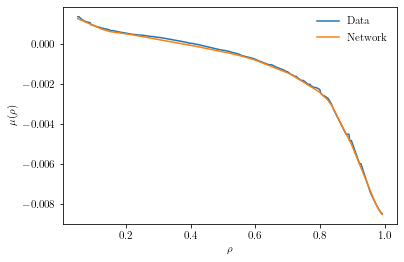

 60%|█████▉    | 2990/5000 [00:15<00:11, 181.16it/s]

0.007254906930029392


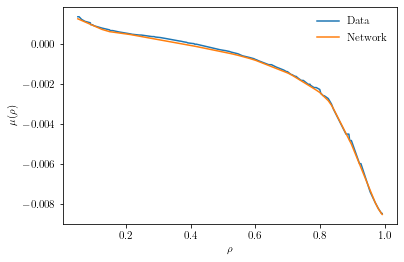

 61%|██████    | 3032/5000 [00:15<00:16, 117.50it/s]

0.007385469041764736


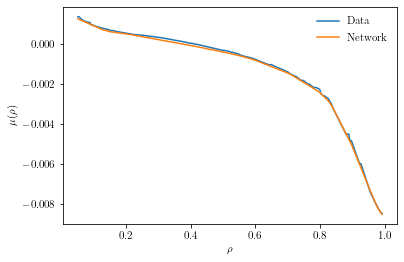

 64%|██████▍   | 3193/5000 [00:16<00:08, 206.14it/s]

0.007190012838691473


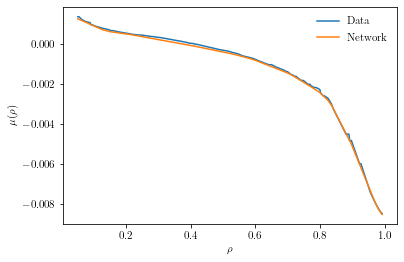

 65%|██████▍   | 3231/5000 [00:16<00:11, 157.48it/s]

0.007260125130414963


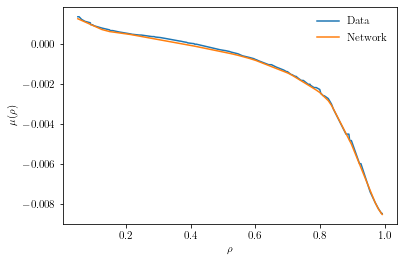

 67%|██████▋   | 3369/5000 [00:17<00:07, 206.24it/s]

0.007147608790546656


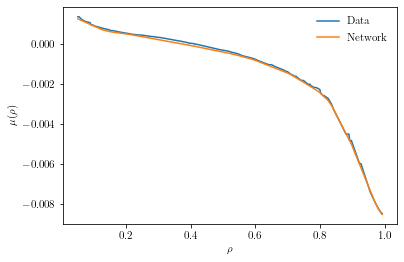

 70%|██████▉   | 3476/5000 [00:17<00:07, 205.14it/s]

0.007161843124777079


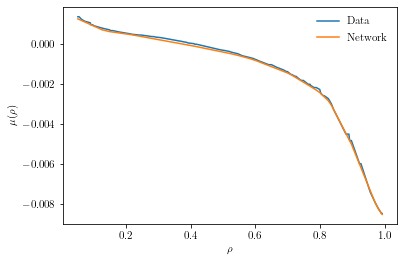

 71%|███████▏  | 3571/5000 [00:18<00:07, 191.28it/s]

0.007283985614776611


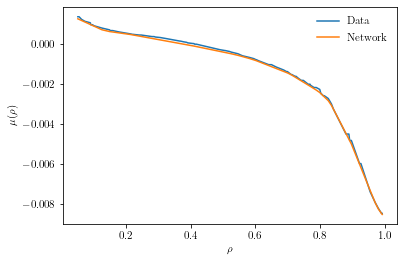

 74%|███████▍  | 3690/5000 [00:19<00:06, 192.23it/s]

0.007060293573886156


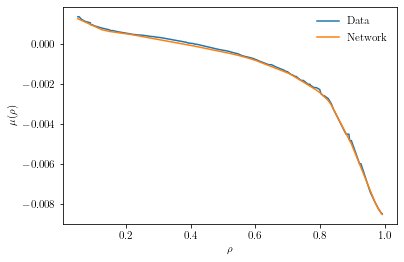

 76%|███████▌  | 3785/5000 [00:19<00:07, 170.24it/s]

0.0072563872672617435


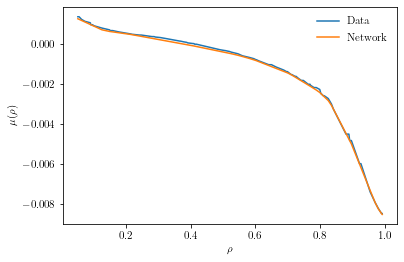

 77%|███████▋  | 3857/5000 [00:20<00:07, 161.59it/s]

0.0074867969378829


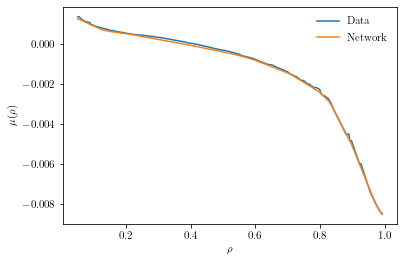

 79%|███████▉  | 3965/5000 [00:20<00:05, 174.31it/s]

0.007053877227008343


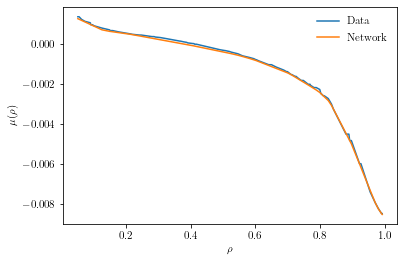

 81%|████████▏ | 4069/5000 [00:21<00:05, 170.53it/s]

0.006454476621001959


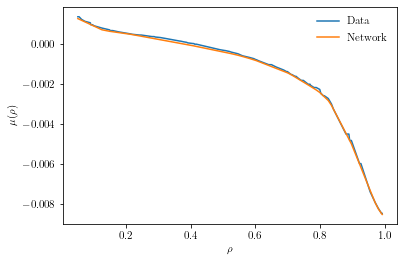

 83%|████████▎ | 4163/5000 [00:21<00:04, 186.97it/s]

0.006324495654553175


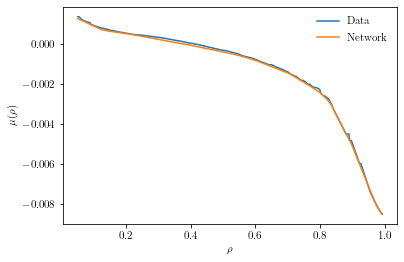

 85%|████████▌ | 4261/5000 [00:22<00:04, 179.10it/s]

0.007460430264472961


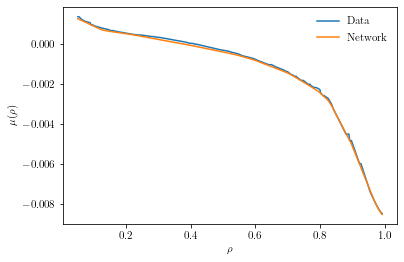

 87%|████████▋ | 4359/5000 [00:22<00:03, 168.07it/s]

0.007442256901413202


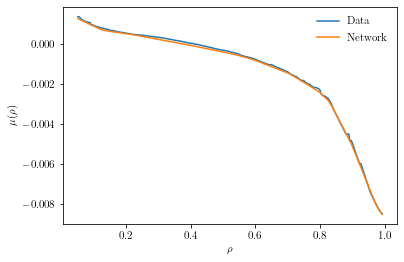

 90%|████████▉ | 4497/5000 [00:23<00:02, 212.66it/s]

0.007282721344381571


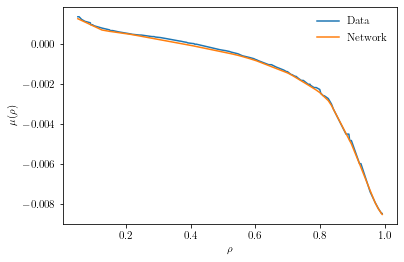

 92%|█████████▏| 4590/5000 [00:24<00:02, 190.75it/s]

0.00722708273679018


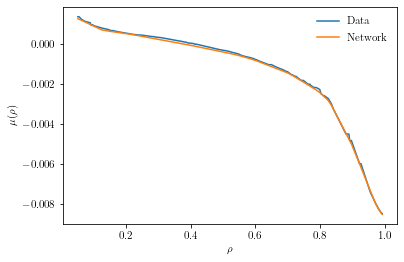

 94%|█████████▎| 4680/5000 [00:24<00:01, 183.84it/s]

0.007121988572180271


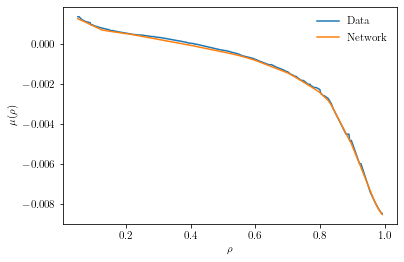

 95%|█████████▌| 4773/5000 [00:25<00:01, 177.36it/s]

0.007302458863705397


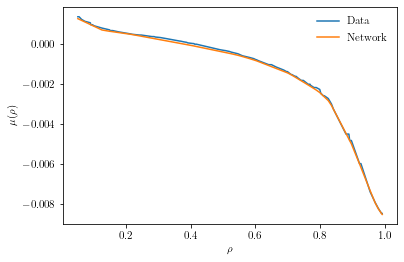

 97%|█████████▋| 4873/5000 [00:25<00:00, 180.60it/s]

0.007045275531709194


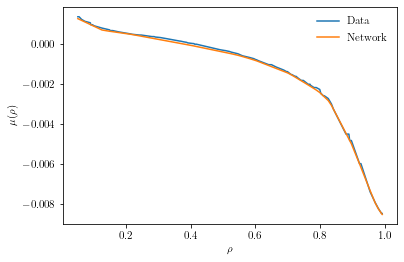

100%|█████████▉| 4984/5000 [00:26<00:00, 198.84it/s]

0.007024560589343309


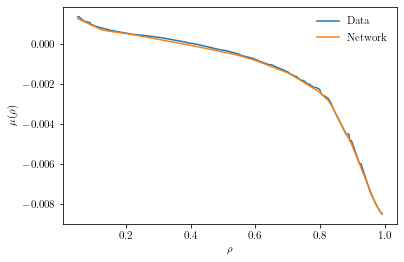

100%|██████████| 5000/5000 [00:26<00:00, 188.63it/s]


Training for model 9


  2%|▏         | 81/5000 [00:00<00:06, 808.04it/s]

0.04567649960517883


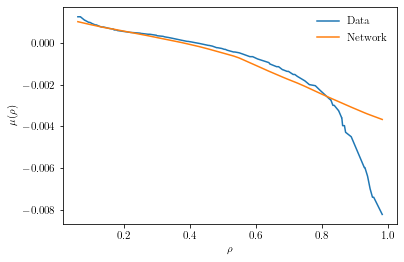

  3%|▎         | 149/5000 [00:00<00:20, 236.90it/s]

0.03154617175459862


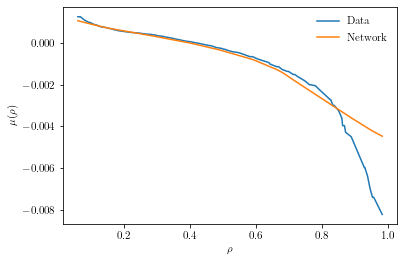

  5%|▌         | 255/5000 [00:01<00:20, 229.88it/s]

0.025189734995365143


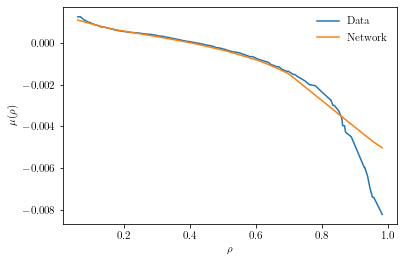

  7%|▋         | 358/5000 [00:01<00:22, 209.48it/s]

0.02209819294512272


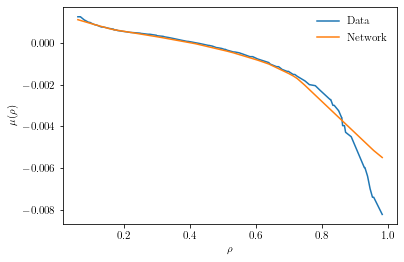

  9%|▉         | 462/5000 [00:02<00:22, 205.79it/s]

0.01922539435327053


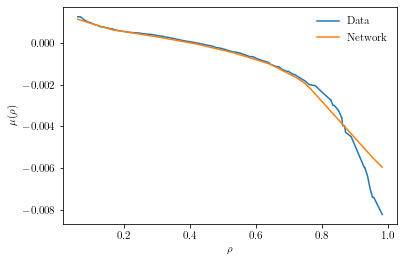

 11%|█         | 553/5000 [00:02<00:23, 189.51it/s]

0.01622699946165085


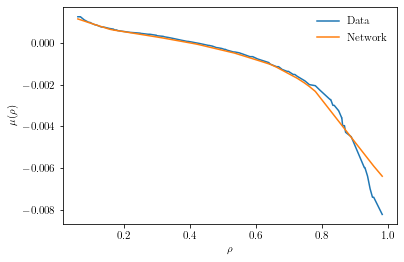

 13%|█▎        | 657/5000 [00:03<00:21, 203.82it/s]

0.014286313205957413


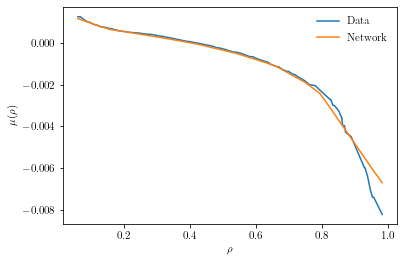

 15%|█▌        | 771/5000 [00:03<00:21, 199.34it/s]

0.011937553063035011


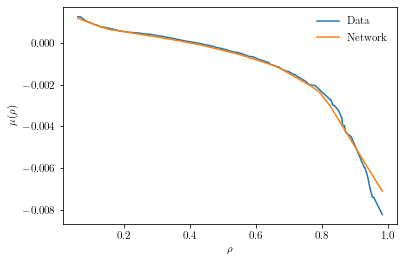

 17%|█▋        | 857/5000 [00:04<00:22, 183.11it/s]

0.010140619240701199


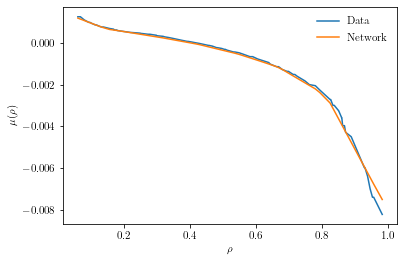

 19%|█▉        | 953/5000 [00:04<00:21, 191.94it/s]

0.0075066532008349895


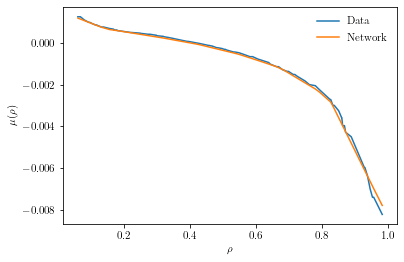

 22%|██▏       | 1084/5000 [00:05<00:18, 213.11it/s]

0.007011915557086468


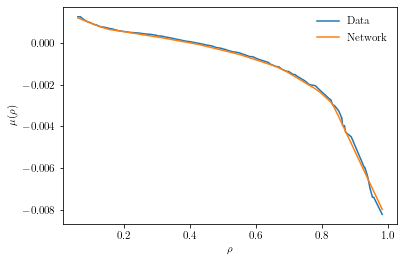

 23%|██▎       | 1173/5000 [00:05<00:19, 200.78it/s]

0.006596971768885851


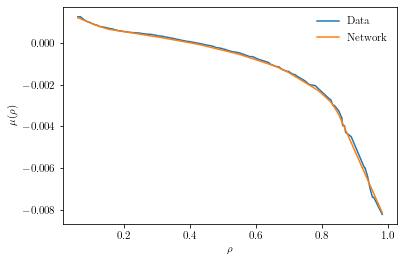

 25%|██▌       | 1261/5000 [00:06<00:20, 186.37it/s]

0.006236497778445482


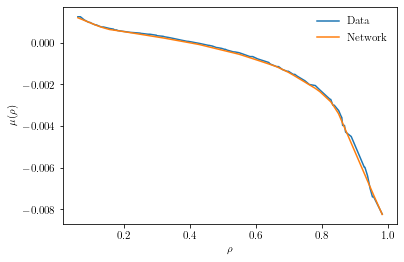

 28%|██▊       | 1398/5000 [00:07<00:18, 196.84it/s]

0.006300033535808325


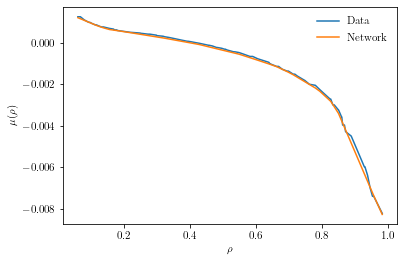

 30%|██▉       | 1491/5000 [00:07<00:21, 163.38it/s]

0.006147167179733515


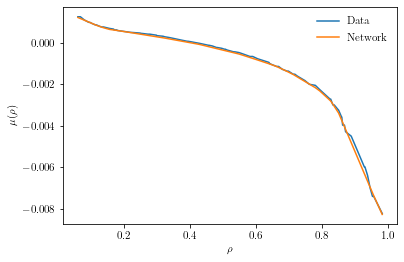

 32%|███▏      | 1589/5000 [00:08<00:20, 168.69it/s]

0.006211419589817524


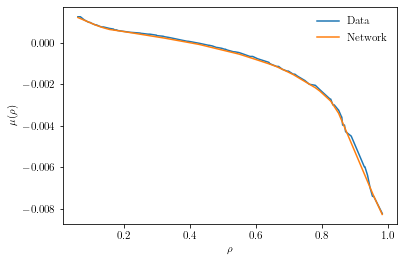

 34%|███▍      | 1695/5000 [00:09<00:21, 153.24it/s]

0.00634168041869998


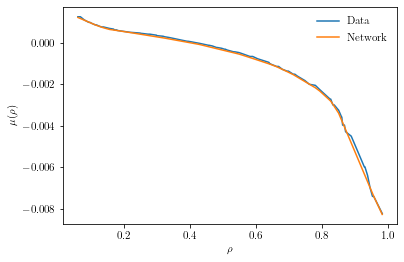

 35%|███▍      | 1734/5000 [00:09<00:27, 117.05it/s]

0.005863847676664591


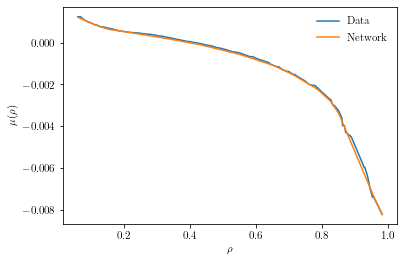

 37%|███▋      | 1855/5000 [00:10<00:18, 165.92it/s]

0.006075318902730942


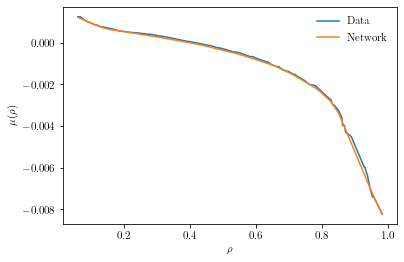

 40%|███▉      | 1992/5000 [00:10<00:13, 222.03it/s]

0.0064592487178742886


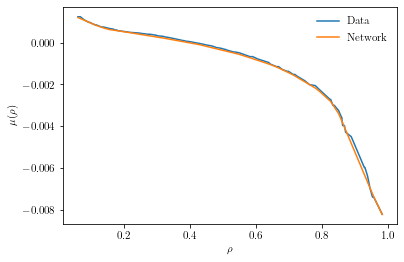

 42%|████▏     | 2097/5000 [00:11<00:13, 208.60it/s]

0.005639128852635622


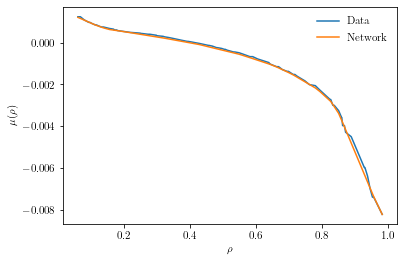

 44%|████▍     | 2196/5000 [00:11<00:14, 194.50it/s]

0.006521367002278566


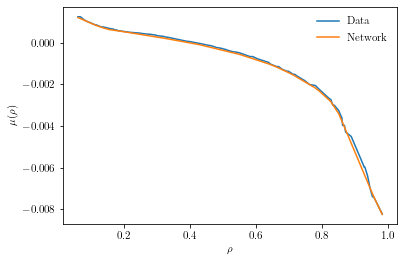

 46%|████▌     | 2286/5000 [00:12<00:15, 174.35it/s]

0.006061499007046223


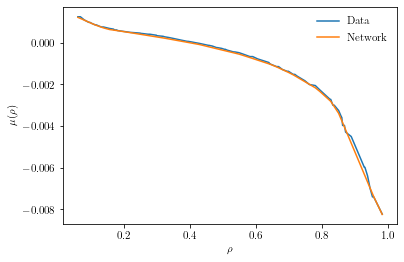

 48%|████▊     | 2375/5000 [00:12<00:16, 156.77it/s]

0.006032111123204231


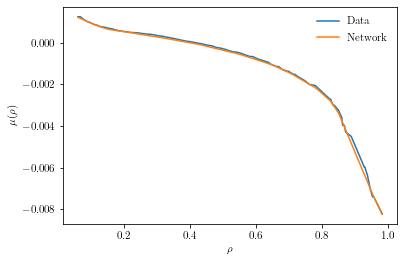

 49%|████▉     | 2472/5000 [00:13<00:16, 153.48it/s]

0.005948951933532953


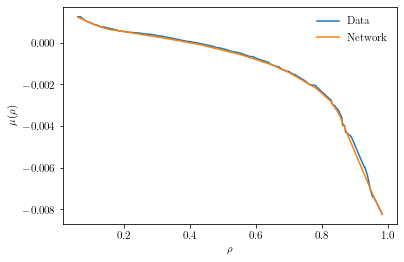

 51%|█████▏    | 2569/5000 [00:13<00:14, 170.35it/s]

0.0055305855348706245


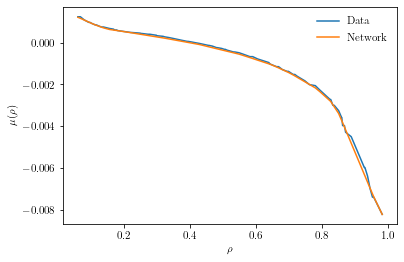

 53%|█████▎    | 2651/5000 [00:14<00:15, 149.74it/s]

0.006269445642828941


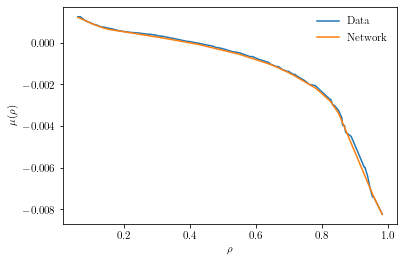

 55%|█████▌    | 2764/5000 [00:15<00:12, 176.25it/s]

0.005986473988741636


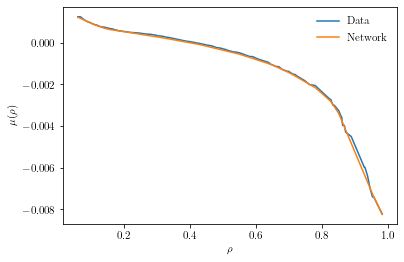

 57%|█████▋    | 2864/5000 [00:15<00:11, 178.59it/s]

0.005848703905940056


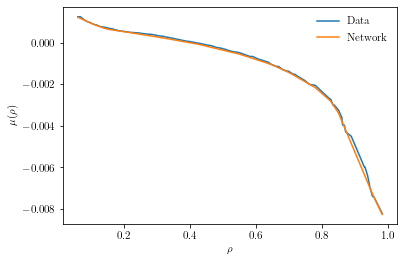

 59%|█████▉    | 2953/5000 [00:16<00:11, 176.50it/s]

0.005904787220060825


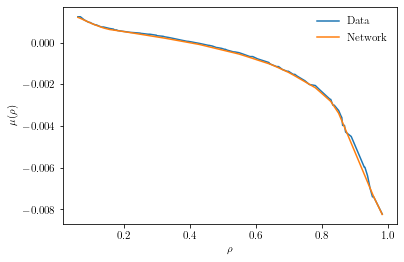

 61%|██████    | 3061/5000 [00:16<00:10, 190.54it/s]

0.005836905911564827


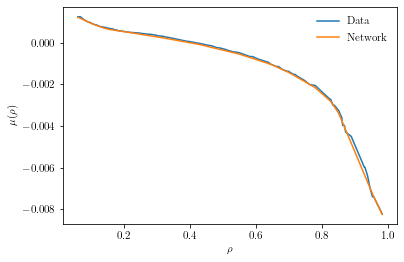

 63%|██████▎   | 3161/5000 [00:17<00:09, 191.14it/s]

0.005803815554827452


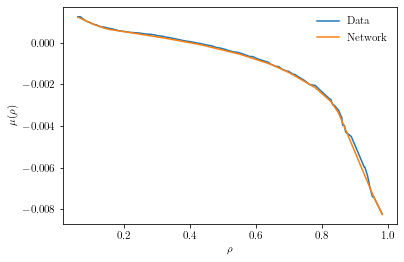

 65%|██████▌   | 3266/5000 [00:17<00:09, 192.01it/s]

0.005419264547526836


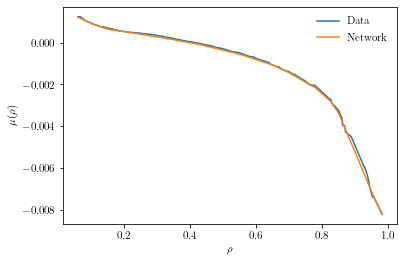

 67%|██████▋   | 3364/5000 [00:18<00:08, 193.12it/s]

0.006260182708501816


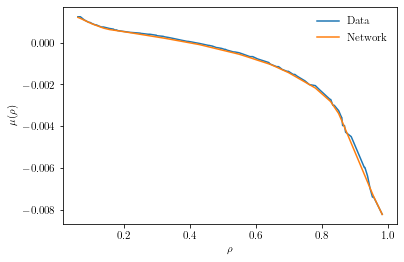

 69%|██████▉   | 3470/5000 [00:18<00:07, 196.90it/s]

0.005879042204469442


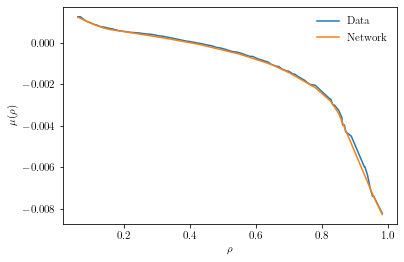

 71%|███████▏  | 3568/5000 [00:19<00:07, 190.92it/s]

0.005614213179796934


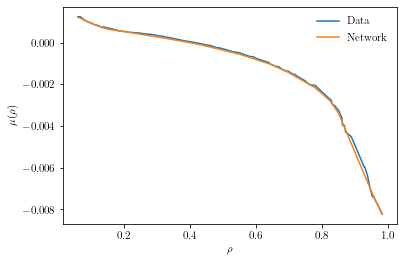

 73%|███████▎  | 3666/5000 [00:19<00:06, 190.75it/s]

0.005453113466501236


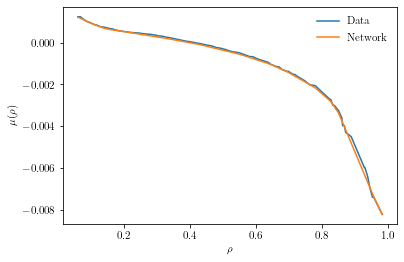

 75%|███████▌  | 3771/5000 [00:20<00:06, 188.25it/s]

0.005617784336209297


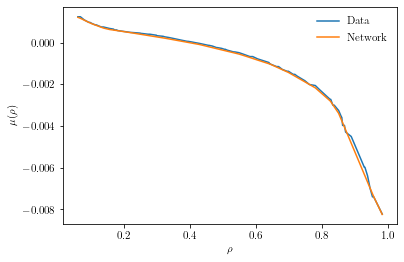

 77%|███████▋  | 3872/5000 [00:20<00:05, 189.91it/s]

0.005509221460670233


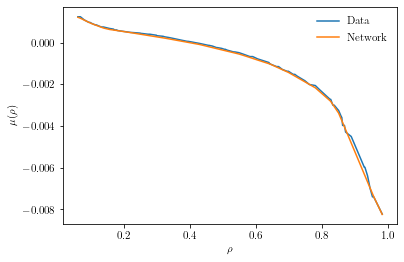

 79%|███████▉  | 3960/5000 [00:21<00:05, 176.94it/s]

0.005455424077808857


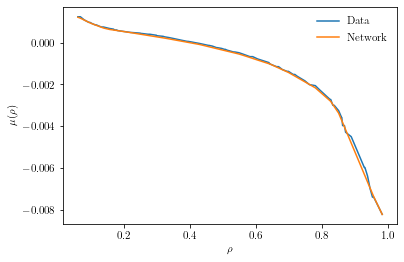

 81%|████████▏ | 4065/5000 [00:21<00:05, 185.38it/s]

0.005661735311150551


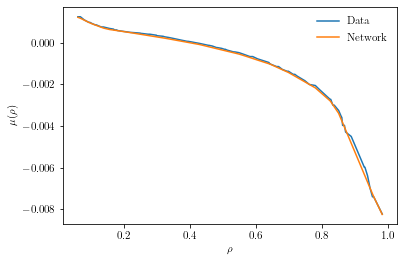

 83%|████████▎ | 4162/5000 [00:22<00:04, 191.30it/s]

0.005418084096163511


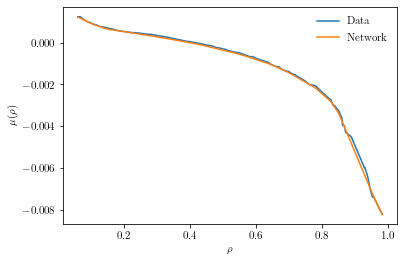

 85%|████████▌ | 4271/5000 [00:22<00:03, 197.87it/s]

0.005427078809589148


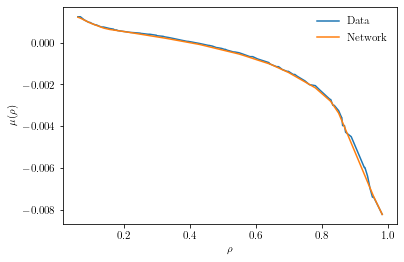

 87%|████████▋ | 4374/5000 [00:23<00:03, 206.06it/s]

0.0054451837204396725


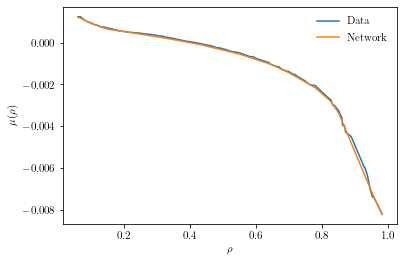

 90%|████████▉ | 4487/5000 [00:23<00:02, 219.51it/s]

0.005497662350535393


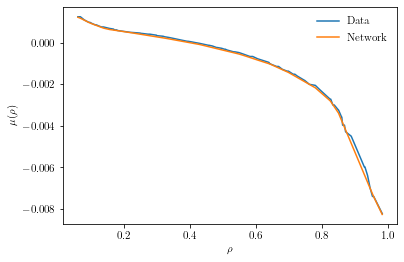

 92%|█████████▏| 4590/5000 [00:24<00:01, 209.35it/s]

0.005525288637727499


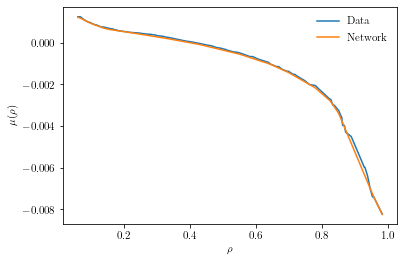

 94%|█████████▎| 4679/5000 [00:24<00:01, 188.36it/s]

0.005439343396574259


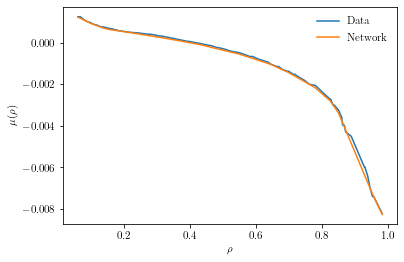

 95%|█████████▌| 4765/5000 [00:25<00:01, 166.64it/s]

0.0062850588001310825


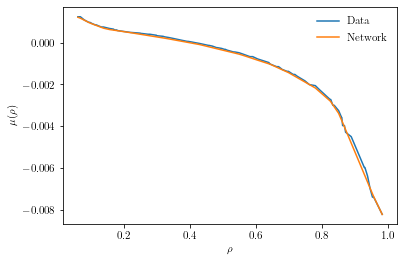

 97%|█████████▋| 4855/5000 [00:26<00:00, 150.69it/s]

0.005666120443493128


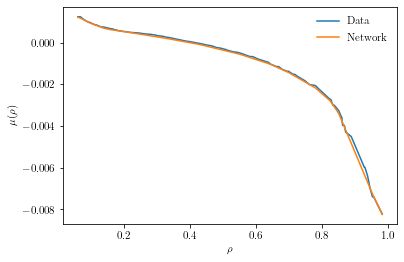

 99%|█████████▉| 4966/5000 [00:26<00:00, 173.73it/s]

0.005441885441541672


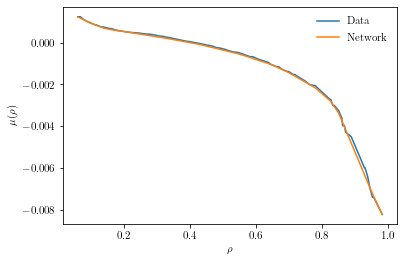

100%|██████████| 5000/5000 [00:27<00:00, 184.78it/s]


In [121]:
model_dir = "./dump/N_"+str(N)+"_cp_mu_"+str(kappa) +"/" 
os.makedirs(model_dir, exist_ok=True)
data = dataset(data_set)
avg_model = AverageMu()
mu = train_avg_mu( avg_model,data,model_dir  ) 
model_name = 'mu_avg_net.ckpt'

os.makedirs(os.path.dirname(model_dir),exist_ok=True)
#The model is trained to retrieve the adsorbing state rho = 0 too. But this leads to discontinuities in 
#the derivative of 

In [31]:
torch.save(
            {'model': avg_model.state_dict(),
            "weights": avg_model.weights,},
            os.path.join(model_dir, model_name)
            )


In [27]:
# basic dissusion model
class Sigma2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Sigma2, self).__init__()
        self.sigma_net = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, output_size),
                    nn.Sigmoid()
                    )

    def forward(self,v):
            sigma2 = self.sigma_net( v[2])**2
            return sigma2 

In [28]:
class WeightedSigma(nn.Module):
        """
        A model for the diffusion which is a weighted average of other models
        """
        def __init__(   self,
                n_train = 10,
                input_size=1,
                hidden_size=64,
                output_size=1,
                ):
                super(WeightedSigma, self).__init__()
                self.funcs = nn.ModuleList([
                Sigma2(
                        input_size, hidden_size, output_size
                        ) for _ in range(n_train)])
                self.weights = torch.ones(n_train,requires_grad=False)
                self.n_train = n_train

        def forward(self,x):
                y = torch.zeros_like(x)
                for idx in range(self.n_train):
                        y = y+ (1/self.weights)[idx].flatten()*self.funcs[idx].sigma_net.forward(x)
                return y/(1/self.weights).sum()


In [29]:
#load the data

class Data_ctime(Dataset):
    def __init__(self,
                    file_name,
                    device,
                    mult = 1.,
                    every = 50,
                    t_step=1,
                    n_trajs=90,
                    t_max = 200000,
                    N=100,
                    ):

        t_max = int(t_max/N)
        self.ds = h5py.File(file_name,'r')
        print("t_max")
        print(t_max)
        n_trajs = n_trajs+10
        self.x = np.zeros(n_trajs*t_max).reshape( n_trajs,t_max  )
        self.times = np.arange(n_trajs*t_max).reshape( n_trajs,t_max  )
        for j in range(1,n_trajs):
                m = np.array(self.ds["mag_"+str(j)])[0::t_step]
                #t = np.array(self.ds["T_"+str(j)])[0::t_step]
                #self.times[j-1,:][:len(t)]=t[:len(m)]
                self.x[j-1,:][:len(m)]=m[:len(m)]
        n_trajs = n_trajs-10
        self.t_step = t_step
        self.x = torch.from_numpy(self.x.reshape(self.x.shape[0],self.x.shape[1],1)).float()
        self.times = torch.from_numpy(self.times.reshape(self.x.shape[0],self.x.shape[1],1)).float()
        #self.time = torch.tensor([t for t in np.arange(0,len(self.x) ,t_step)]) 
        #self.x = self.x[:len(self.time)].to(device)
        #self.time = self.time[0::every][:len(self.x)].to(device)
        self.num = self.x.shape[0]
        self.dataset = torch.tensor([],device=device)
        # data are organised in tuples [mag(time), mag(time + delta_t), time, time+delta_t]
        for i in range(1, n_trajs +1 ):
                m = self.x[i]
                t = self.times[i]
                dt = t[:-1]-t[1:]
                dt[dt==0]=1
                qv = torch.cumsum(( (m[:-1]-m[1:]) )**2,0)[0::every]
                dt = torch.ones_like(qv)*every*t_step
                m = m[0::every]
                len_qv = qv.shape[0]
                new = torch.cat(
                            (
                                qv[:-1].reshape(len_qv-1,1), # [X]_t at time t 
                                qv[1:].reshape(len_qv-1,1), # [X]_t+dt at time t + dt
                                m[:(len_qv-1)].reshape(len_qv-1,1), #X_t at time t
                                dt[:(len_qv-1)].reshape(len_qv-1,1)),
                                dim = 1
                                )
                self.dataset = torch.cat((self.dataset,new))
        self.data_length = len(self.dataset)
        self.dataset = self.dataset.reshape(self.data_length,4,1)
    def __getitem__(self, idx):
        return self.dataset[(idx+1)% self.data_length].float()
    def __len__(self):
        return self.num


In [30]:
#train the models

def train_sigma(model,
                file_name,
                train_dir,
                t_step,
                batch_size=1000,
                input_size=1,
                hidden_size=64,
                output_size=1,
                num_iters=5000,
                mult = 1.,
                stop_every= 400,
                every=50,
                ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = Data_ctime(
            file_name = file_name,
            device = device,
            every=every,
            t_step = t_step)
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)
    for global_step in tqdm.tqdm(range(1, num_iters+1)):
            xs = torch.transpose(next(iter(infinite_train_dataloader)),0,1)
            model.zero_grad()
            #loss = model(xs)
            loss = torch.abs( (xs[1] -xs[0])/xs[3] -  model(xs)).mean()
            if global_step%stop_every==0:
                    print(loss)
            loss.backward()
            optimizer.step()
    torch.save(
            {'model': model.state_dict(),
             'optimizer': optimizer.state_dict()},
            os.path.join(train_dir, f'sigma_net.ckpt')
            )
    return model, dataset,loss.detach().item()


In [31]:
# some parameters

n_train = 2
input_size = output_size = 1
hidden_size = 64
every =50
train_dir = "dump/N_"+str(N)+"_cp_mu_ctime_"+str(kappa )+"/"
os.makedirs(train_dir,exist_ok=True)
sigma = WeightedSigma()

for idx in range(n_train):
            model = Sigma2(
                    input_size, hidden_size, output_size
                    )
            sigma.funcs[idx],_,sigma.weights[idx] = train_sigma(model,data_set,train_dir,t_step,every=every)

torch.save(
            {'model': sigma.state_dict(),
             'weights':sigma.weights,
             },
            os.path.join(train_dir, f'weighted_sigma_net.ckpt')
            )


  0%|          | 0/5000 [00:00<?, ?it/s]

t_max
2000


  9%|▉         | 473/5000 [00:01<00:11, 395.02it/s]

tensor(2.3755e-05, grad_fn=<MeanBackward0>)


 17%|█▋        | 852/5000 [00:02<00:09, 423.99it/s]

tensor(1.7415e-05, grad_fn=<MeanBackward0>)


 25%|██▍       | 1247/5000 [00:03<00:08, 435.99it/s]

tensor(1.1067e-05, grad_fn=<MeanBackward0>)


 34%|███▎      | 1687/5000 [00:04<00:07, 435.30it/s]

tensor(6.7863e-06, grad_fn=<MeanBackward0>)


 42%|████▏     | 2082/5000 [00:05<00:06, 436.33it/s]

tensor(5.6066e-06, grad_fn=<MeanBackward0>)


 50%|████▉     | 2478/5000 [00:06<00:05, 425.67it/s]

tensor(5.2175e-06, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2874/5000 [00:06<00:04, 438.40it/s]

tensor(5.0764e-06, grad_fn=<MeanBackward0>)


 65%|██████▌   | 3266/5000 [00:07<00:04, 428.83it/s]

tensor(4.9602e-06, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3662/5000 [00:08<00:03, 434.03it/s]

tensor(5.0226e-06, grad_fn=<MeanBackward0>)


 81%|████████  | 4056/5000 [00:09<00:02, 431.03it/s]

tensor(4.8118e-06, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4450/5000 [00:10<00:01, 426.53it/s]

tensor(4.8425e-06, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4849/5000 [00:11<00:00, 423.28it/s]

tensor(4.8203e-06, grad_fn=<MeanBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

t_max
2000


  9%|▉         | 459/5000 [00:01<00:12, 373.62it/s]

tensor(2.1153e-05, grad_fn=<MeanBackward0>)


 17%|█▋        | 855/5000 [00:02<00:12, 339.30it/s]

tensor(1.7620e-05, grad_fn=<MeanBackward0>)


 25%|██▌       | 1270/5000 [00:03<00:08, 416.08it/s]

tensor(1.6144e-05, grad_fn=<MeanBackward0>)


 33%|███▎      | 1632/5000 [00:04<00:09, 341.22it/s]

tensor(1.1418e-05, grad_fn=<MeanBackward0>)


 41%|████      | 2033/5000 [00:05<00:09, 324.97it/s]

tensor(6.1589e-06, grad_fn=<MeanBackward0>)


 49%|████▉     | 2445/5000 [00:06<00:06, 374.60it/s]

tensor(5.0958e-06, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2852/5000 [00:07<00:06, 330.79it/s]

tensor(5.1067e-06, grad_fn=<MeanBackward0>)


 65%|██████▍   | 3246/5000 [00:08<00:06, 290.97it/s]

tensor(4.8926e-06, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3667/5000 [00:10<00:03, 357.23it/s]

tensor(4.6354e-06, grad_fn=<MeanBackward0>)


 81%|████████▏ | 4067/5000 [00:11<00:02, 392.85it/s]

tensor(4.5441e-06, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4451/5000 [00:12<00:01, 417.86it/s]

tensor(4.4978e-06, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4843/5000 [00:13<00:00, 425.67it/s]

tensor(4.3934e-06, grad_fn=<MeanBackward0>)


100%|██████████| 5000/5000 [00:13<00:00, 364.08it/s]


In [32]:
# plot results

def plot_sigma(sigma,mu,dataset,dt,):
    with torch.no_grad():
        x = torch.linspace(0,1,100).reshape(100,1)
        plt.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
            "font.size":9
         })
        plt.subplots_adjust(bottom=0.19)
        fig, (ax1,ax2) = plt.subplots(1, 2)
        fig.set_size_inches(w=4.7747/1.35, h=2.9841875*0.65)
        fig.tight_layout(pad=1.8)

        ax1.ticklabel_format(style="sci",scilimits=(-0.2,0))
        ax1.plot(x.flatten(),model.sigma_net(x).flatten(),c="tab:red",label = r"$\sigma_\theta$")
        ax1.plot(x.flatten(),mu(x)*dt,c="tab:blue",alpha = 0.8,label = r"$\mu_\theta$")
        ax1.set_xlabel(r"$\rho$")
        box = ax1.get_position()
        ax1.set_position([box.x0-0.07, box.y0, box.width*1.3, box.height])
        ax1.legend(frameon=False)
        qv = []
        dt_qv = []
        t = []
        pred = []
        x = []
        for i in range(0, 30):
            v = dataset[i]
            qv.append(v[2])
            t.append(v[3])
            dt_qv.append((v[1]-v[0])/v[3])
            pred.append((model.sigma_net(v[2])**2).flatten())
            x.append(v[2])
        t = torch.cumsum(torch.tensor(t),0)
        ax2.ticklabel_format(style="sci",scilimits=(-0.2,0))
        ax2.plot(t,dt_qv,color = "dimgrey",label =r"$\Delta_t[\rho]_t$")
        ax2.plot(t,torch.tensor(pred).flatten(),color = "black",label= r"$\sigma_\theta^2(\rho_t)$"  )
        #ax2.plot(t, qv,color = "tab:red",label= r"$\rho_t$"  )
        ax1.text(-0.15, 1.1, "(a)", transform=ax1.transAxes)
        ax2.text(-0.15, 1.1, "(b)", transform=ax2.transAxes)
        box = ax2.get_position()
        ax2.set_position([box.x0-0.04, box.y0, box.width*1.3, box.height])
        ax2.legend(frameon=False)

        ax2.set_xlabel(r"$t$")
        name_fig = "./images/sigma2_kappa_%.3f.pdf"%kappa
        plt.savefig( name_fig)
        


t_max
2000


<Figure size 432x288 with 0 Axes>

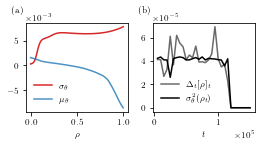

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Data_ctime(
            file_name = data_set,
            device = device,
            every=every,
            t_step = t_step)

plot_sigma(sigma,mu,dataset,dt=0.01)

In [113]:
import torchsde
from math import sqrt
class ContactProcess(object):
    """Brownian motion.
    dX = mu dt  + sigma dW
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, mu , sigma,dt = 0.01,N=100):
        super( ContactProcess , self).__init__()
        self.mu = mu
        self.sigma = sigma
        self.dt = dt

    def f(self, t, y): 
        return  N*self.mu(y)

    def g(self, t, y): 
        return sqrt(N)*self.sigma(y)/sqrt(dt)#torch.sqrt(torch.tensor([dt]))
    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts) 
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1)) 
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs


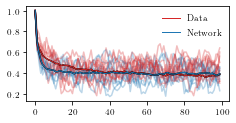

In [124]:
def trajs_cp(mu,
             sigma,
             file_name,
             dt = 0.01,
             t0 = 0.,
             t1 = 1.,
             batch_size=10,
             ):
    with torch.no_grad():
        device="cpu"
        len_t = int(t1/dt)
        noise_std = 1.# sqrt(dt)
        normalize = False
        ts = torch.linspace(t0,t1,len_t)
        cp = ContactProcess(mu,sigma)
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(w=4.7747/1.35, h=2.9841875*0.65)
        fig.tight_layout(pad=1.5)
        x0 = torch.ones((10*batch_size, 1), device=device)
        xs = cp.sample(x0,ts,noise_std,normalize)
        for i in range(batch_size-1):
            ax1.plot(xs[:,i,:].reshape(len_t),c="tab:blue",alpha = 0.3)
        ds = h5py.File(file_name,'r')
        data = np.zeros(Num_traj*len_t).reshape(Num_traj,len_t)
        for i in range(1,Num_traj):
            xi = np.array(ds["mag_"+str(i)])[0::N]
            data[i-1,:len(xi)]= xi[:len_t]
        for i in range(batch_size-1):
            ax1.plot(data[i][:len_t], c="tab:red",alpha=0.3)
        ax1.plot(np.array(data[:][:len_t]).mean(axis=0), c="black")
        ax1.plot(np.array(data[:][:len_t]).mean(axis=0), c="tab:red",linewidth=1.,label="Data")
        ax1.plot(xs.mean(axis=1).reshape(len_t), c="black")
        ax1.plot(xs.mean(axis=1).reshape(len_t), c="tab:blue",linewidth=1.,label="Network")
        #ps_data = data[data[:,-1]!=0] 
        #ax1.plot( ps_data[:,:len_t].mean(axis=0), c="black")
        #ax1.plot( ps_data[:,:len_t].mean(axis=0), c="tab:green",linewidth=1.,
        #                       label = "Post-selected data")

        ax1.legend(frameon=False)
        plt.show()
trajs_cp(mu,sigma,data_set)
